### Task 1: Feasibility and Impact of Adversarial Attacks

In [45]:
import numpy as np
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib
import random
import os
import warnings
warnings.filterwarnings('ignore')
import copy
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss

In [2]:
def load_mat_data(file_path, data_key):
    """
    Load data from a .mat file and extract the specific key.
    
    Parameters:
    -----------
    file_path : str
        Path to the MAT file
    data_key : str
        Key to extract from the MAT file
        
    Returns:
    --------
    numpy.ndarray
        Extracted data
    """
    data = scipy.io.loadmat(file_path)
    return data[data_key][0][0]

def load_iaprtc_dataset(data_dir="./IAPRTC/"):
    """
    Load the IAPRTC-12 dataset from MAT files.
    
    Parameters:
    -----------
    data_dir : str, default="./IAPRTC/"
        Directory containing the dataset files
        
    Returns:
    --------
    tuple
        (train_features, train_labels, test_features, test_labels)
    """
    # Define file paths
    train_features_path = f"{data_dir}IAPRTC-12_TrainFeat.mat"
    train_labels_path = f"{data_dir}IAPRTC-12_TrainLabels.mat"
    test_features_path = f"{data_dir}IAPRTC-12_TestFeat.mat"
    test_labels_path = f"{data_dir}IAPRTC-12_TestLabels.mat"
    
    # Load data
    train_features = load_mat_data(train_features_path, 'I_x_tr')
    train_labels = load_mat_data(train_labels_path, 'I_z_tr')
    test_features = load_mat_data(test_features_path, 'I_x_te')
    test_labels = load_mat_data(test_labels_path, 'I_z_te')
    
    return train_features, train_labels, test_features, test_labels

def print_dataset_info(train_features, train_labels, test_features, test_labels):
    """
    Print information about the dataset shapes.
    
    Parameters:
    -----------
    train_features : numpy.ndarray
        Training features
    train_labels : numpy.ndarray
        Training labels
    test_features : numpy.ndarray
        Test features
    test_labels : numpy.ndarray
        Test labels
    """
    print(f"Train Features: {train_features.shape}, Train Labels: {train_labels.shape}")
    print(f"Test Features: {test_features.shape}, Test Labels: {test_labels.shape}")

In [3]:
train_features, train_labels, test_features, test_labels = load_iaprtc_dataset()
print_dataset_info(train_features, train_labels, test_features, test_labels)

Train Features: (17665, 2048), Train Labels: (17665, 291)
Test Features: (1962, 2048), Test Labels: (1962, 291)


In [4]:
def load_preprocessors(paths):
    """
    Load data preprocessing models from saved files.
    
    Parameters:
    -----------
    paths : dict
        Dictionary containing paths to saved preprocessor models
        
    Returns:
    --------
    tuple
        (scaler, pca) - The loaded preprocessing models
    """
    scaler = joblib.load(paths['scaler'])
    pca = joblib.load(paths['pca'])
    return scaler, pca

def apply_transformations(features, scaler, pca):
    """
    Apply preprocessing transformations to features.
    
    Parameters:
    -----------
    features : array-like
        Features to transform
    scaler : object
        Fitted StandardScaler
    pca : object
        Fitted PCA model
        
    Returns:
    --------
    tuple
        (scaled_features, reduced_features)
    """
    scaled_features = scaler.transform(features)
    reduced_features = pca.transform(scaled_features)
    return scaled_features, reduced_features

def load_model(model_path, model_name):
    """
    Load a single model with error handling.
    
    Parameters:
    -----------
    model_path : str
        Path to the saved model file
    model_name : str
        Name of the model for display purposes
        
    Returns:
    --------
    object or None
        Loaded model if successful, None if an error occurs
    """
    try:
        model = joblib.load(model_path)
        print(f"Loaded {model_name} model")
        return model
    except Exception as e:
        print(f"Error loading {model_name} model: {e}")
        return None

def load_trained_models(model_configs):
    """
    Load all trained models based on configuration.
    
    Parameters:
    -----------
    model_configs : dict
        Dictionary mapping model names to their file paths
        
    Returns:
    --------
    dict
        Dictionary of successfully loaded models
    """
    trained_models = {}
    
    for model_name, model_path in model_configs.items():
        model = load_model(model_path, model_name)
        if model is not None:
            trained_models[model_name] = model
            
    return trained_models

In [5]:
preprocessor_paths = {
    'scaler': 'scaler.pkl',
    'pca': 'pca_model.pkl'
}

model_configs = {
    'Linear SVM': 'linear_svm.pkl',
    'Logistic Regression': 'logistic_regression.pkl',
    'Softmax Regression': 'softmax_regression.pkl',
    'Decision Tree': 'decision_tree.pkl',
    'Weighted KNN': 'weighted_knn.pkl'  
}

scaler, pca = load_preprocessors(preprocessor_paths)

X_test_scaled, X_test_reduced = apply_transformations(test_features, scaler, pca)

trained_models = load_trained_models(model_configs)

Loaded Linear SVM model
Loaded Logistic Regression model
Loaded Softmax Regression model
Loaded Decision Tree model
Loaded Weighted KNN model


In [6]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluate a multilabel classification model using various metrics.
    
    Parameters:
    -----------
    model : classifier object
        The trained model with a predict method
    X_test : array-like
        Test features
    y_test : array-like
        True test labels
    
    Returns:
    --------
    dict
        Dictionary containing evaluation metrics for multilabel classification
    """
    # Get model predictions
    y_pred = model.predict(X_test)
    
    # Define metrics to calculate with their parameters
    metrics = {
        'accuracy': (accuracy_score, {}),
        'precision_micro': (precision_score, {'average': 'micro'}),
        'precision_macro': (precision_score, {'average': 'macro'}),
        'recall_micro': (recall_score, {'average': 'micro'}),
        'recall_macro': (recall_score, {'average': 'macro'}),
        'f1_micro': (f1_score, {'average': 'micro'}),
        'f1_macro': (f1_score, {'average': 'macro'}),
        'hamming_loss': (hamming_loss, {})
    }
    
    # Calculate all metrics
    results = {}
    for metric_name, (metric_func, params) in metrics.items():
        results[metric_name] = metric_func(y_test, y_pred, **params)
    
    return results

In [7]:
def evaluate_all_models(trained_models, features, reduced_features, labels, prefix=""):
    """
    Evaluate all models and collect performance metrics.
    
    Parameters:
    -----------
    trained_models : dict
        Dictionary of trained models
    features : array-like
        Features to evaluate on
    labels : array-like
        True labels
    prefix : str, default=""
        Prefix for console output
        
    Returns:
    --------
    dict
        Dictionary containing evaluation metrics for each model
    """
    results = {}
    print(f"\nEvaluating {prefix}model performance...")
    
    for name, model in trained_models.items():
        print(f"Evaluating {name}...")
        if name != 'Weighted KNN':
            metrics = evaluate_model(model, features, labels)
        else:
            metrics = evaluate_model(model, reduced_features, labels)
        results[name] = metrics
        print(f"  Accuracy: {metrics['accuracy']:.4f}, F1 (micro): {metrics['f1_micro']:.4f}")
    
    return results

def create_metrics_dataframe(results):
    """
    Create a DataFrame from model evaluation results.
    
    Parameters:
    -----------
    results : dict
        Dictionary containing model evaluation metrics
        
    Returns:
    --------
    pd.DataFrame
        DataFrame containing formatted metrics
    """
    metrics_df = pd.DataFrame({
        'Model': [],
        'Accuracy': [],
        'Precision (micro)': [],
        'Recall (micro)': [],
        'F1 (micro)': [],
        'Hamming Loss': []
    })
    
    for name, metrics in results.items():
        metrics_df = pd.concat([metrics_df, pd.DataFrame({
            'Model': [name],
            'Accuracy': [metrics['accuracy']],
            'Precision (micro)': [metrics['precision_micro']],
            'Recall (micro)': [metrics['recall_micro']],
            'F1 (micro)': [metrics['f1_micro']],
            'Hamming Loss': [metrics['hamming_loss']]
        })])
    
    return metrics_df

def display_and_save_results(metrics_df, title="Model performance", output_file=None):
    """
    Display results and optionally save to CSV.
    
    Parameters:
    -----------
    metrics_df : pd.DataFrame
        DataFrame containing metrics
    title : str, default="Model performance"
        Title for console output
    output_file : str, optional
        Path to save results CSV
    """
    print(f"\n{title}:")
    print(metrics_df.to_string(index=False))
    
    if output_file:
        metrics_df.to_csv(output_file, index=False)
        print(f"Results saved to {output_file}")

In [8]:
base_results = evaluate_all_models(trained_models, X_test_scaled, X_test_reduced, test_labels, prefix="base ")
base_df = create_metrics_dataframe(base_results)
display_and_save_results(base_df, title="Base model performance", output_file="base_model_performance.csv")


Evaluating base model performance...
Evaluating Linear SVM...
  Accuracy: 0.0183, F1 (micro): 0.3475
Evaluating Logistic Regression...
  Accuracy: 0.0000, F1 (micro): 0.1302
Evaluating Softmax Regression...
  Accuracy: 0.0000, F1 (micro): 0.1302
Evaluating Decision Tree...
  Accuracy: 0.0102, F1 (micro): 0.3342
Evaluating Weighted KNN...
  Accuracy: 0.0347, F1 (micro): 0.5417

Base model performance:
              Model  Accuracy  Precision (micro)  Recall (micro)  F1 (micro)  Hamming Loss
         Linear SVM  0.018349           0.756601        0.225550    0.347505      0.016397
Logistic Regression  0.000000           0.070424        0.862390    0.130215      0.223035
 Softmax Regression  0.000000           0.070424        0.862390    0.130215      0.223035
      Decision Tree  0.010194           0.529967        0.244006    0.334159      0.018825
       Weighted KNN  0.034659           0.852068        0.397087    0.541718      0.013007
Results saved to base_model_performance.csv


### White-Box Attack (FGSM)

In [37]:
def fgsm_attack(model, x, y, epsilon=10.0):
    """
    Fast Gradient Sign Method (FGSM) attack for multilabel classification.
    Uses numerical gradient estimation compatible with any sklearn model.
    
    Parameters:
    -----------
    model : trained model
        Target model to attack
    x : array-like
        Original input example (single instance)
    y : array-like
        Original labels (multilabel format)
    epsilon : float
        Attack strength parameter
        
    Returns:
    --------
    x_adv : array-like
        Adversarial example
    """
    x_adv = x.copy()
    delta = 0.01  # Step size for gradient approximation
    
    # Numerical gradient estimation
    grad = np.zeros_like(x)
    
    # Get original prediction
    original_pred = model.predict(x.reshape(1, -1))[0]
    
    # Calculate original agreement (higher means more correct predictions)
    original_agreement = np.sum(original_pred == y)
    
    # For high-dimensional data, estimate gradient on a subset of features
    n_features = min(200, x.shape[0])  # Sample at most 200 features
    feature_indices = np.random.choice(x.shape[0], n_features, replace=False)
    
    for i in feature_indices:
        # Create perturbed versions
        x_plus = x.copy()
        x_plus[i] += delta
        
        x_minus = x.copy()
        x_minus[i] -= delta
        
        # Get predictions for perturbed inputs
        pred_plus = model.predict(x_plus.reshape(1, -1))[0]
        pred_minus = model.predict(x_minus.reshape(1, -1))[0]
        
        # Calculate change in agreement (we want to decrease agreement)
        agreement_plus = np.sum(pred_plus == y)
        agreement_minus = np.sum(pred_minus == y)
        
        # Central difference approximation of gradient
        # We want to maximize misclassifications, so negative gradient of agreement
        grad[i] = (agreement_plus - agreement_minus) / (2 * delta)
    
    # Apply FGSM update: move in direction that reduces agreement with true labels
    # We use negative sign because we want to reduce agreement
    x_adv -= epsilon * np.sign(grad)
    
    # Ensure the perturbation is within epsilon bounds from original x
    x_adv = np.clip(x_adv, x - epsilon, x + epsilon)
    
    # Additional clip to ensure values are in valid range (assuming normalized data)
    x_adv = np.clip(x_adv, 0, 1)
    
    return x_adv

In [38]:
def generate_adversarial_examples_whitebox(model, X, y, attack_type='fgsm', epsilon=10.0, 
                                          sample_size=None, progress=True, model_name=None):
    """
    Generate adversarial examples using white box attacks with FGSM.
    
    Parameters:
    -----------
    model : classifier object
        Trained model with predict method
    X : numpy.ndarray
        Input features
    y : numpy.ndarray
        True labels
    attack_type : str, default='fgsm'
        Type of attack ('fgsm' or 'pgd')
    epsilon : float, default=10.0
        Attack strength parameter
    sample_size : int, optional
        Number of samples to attack (if None, attack all)
    progress : bool, default=True
        Whether to show progress bar
    model_name : str, optional
        Name of the model (needed for KNN special handling)
        
    Returns:
    --------
    tuple
        (X_adv, indices) - Adversarial examples and their indices
    """
    if sample_size is None:
        sample_size = X.shape[0]
    else:
        sample_size = min(sample_size, X.shape[0])
    
    # Randomly select samples
    indices = np.random.choice(X.shape[0], sample_size, replace=False)
    X_selected = X[indices]
    y_selected = y[indices]
    
    X_adv = np.zeros_like(X_selected)
    
    iterator = tqdm(range(sample_size)) if progress else range(sample_size)
    for i in iterator:
        x = X_selected[i]
        true_y = y_selected[i]
        
        # Special handling for KNN if needed
        if model_name == 'Weighted KNN':
            # For KNN, we need to handle differently since it uses reduced features
            # This would require access to the PCA object, which might not be available directly
            # A simpler approach would be to use random perturbation for KNN
            noise = np.random.normal(0, epsilon/3, size=x.shape)
            X_adv[i] = np.clip(x + noise, x - epsilon, x + epsilon)
        else:
            # Use FGSM attack
            X_adv[i] = fgsm_attack(model, x, true_y, epsilon)
    
    return X_adv, indices

In [39]:
def evaluate_adversarial_examples(model, X_clean, X_adv, y_true, model_name, attack_name):
    """
    Evaluate a model's performance on clean and adversarial examples.
    
    Parameters:
    -----------
    model : classifier object
        Model to evaluate
    X_clean : numpy.ndarray
        Original test examples
    X_adv : numpy.ndarray
        Adversarial examples
    y_true : numpy.ndarray
        True labels
    model_name : str
        Name of the model
    attack_name : str
        Name of the attack
        
    Returns:
    --------
    dict
        Dictionary containing evaluation metrics
    """
    # Predict on clean examples
    y_pred_clean = model.predict(X_clean)
    
    # Predict on adversarial examples
    y_pred_adv = model.predict(X_adv)
    
    # Calculate performance metrics
    clean_metrics = {
        'accuracy': accuracy_score(y_true, y_pred_clean),
        'precision_micro': precision_score(y_true, y_pred_clean, average='micro'),
        'recall_micro': recall_score(y_true, y_pred_clean, average='micro'),
        'f1_micro': f1_score(y_true, y_pred_clean, average='micro'),
        'hamming_loss': hamming_loss(y_true, y_pred_clean)
    }
    
    adv_metrics = {
        'accuracy': accuracy_score(y_true, y_pred_adv),
        'precision_micro': precision_score(y_true, y_pred_adv, average='micro'),
        'recall_micro': recall_score(y_true, y_pred_adv, average='micro'),
        'f1_micro': f1_score(y_true, y_pred_adv, average='micro'),
        'hamming_loss': hamming_loss(y_true, y_pred_adv)
    }
    
    # Calculate attack effectiveness metrics
    
    # 1. Label change rate: percentage of examples where any label changed
    label_change_rate = np.mean(np.any(y_pred_clean != y_pred_adv, axis=1))
    
    # 2. Prediction flip rate: percentage of individual label predictions that changed
    prediction_flip_rate = np.mean(y_pred_clean != y_pred_adv)
    
    # 3. L2 distortion: average L2 norm of perturbations
    l2_distortion = np.mean(np.sqrt(np.sum((X_adv - X_clean)**2, axis=1)))
    
    # Calculate performance drops
    accuracy_drop = clean_metrics['accuracy'] - adv_metrics['accuracy']
    f1_drop = clean_metrics['f1_micro'] - adv_metrics['f1_micro']
    
    # Compile results
    results = {
        'model': model_name,
        'attack': attack_name,
        'clean_accuracy': clean_metrics['accuracy'],
        'clean_precision': clean_metrics['precision_micro'],
        'clean_recall': clean_metrics['recall_micro'],
        'clean_f1': clean_metrics['f1_micro'],
        'clean_hamming_loss': clean_metrics['hamming_loss'],
        'adv_accuracy': adv_metrics['accuracy'],
        'adv_precision': adv_metrics['precision_micro'],
        'adv_recall': adv_metrics['recall_micro'],
        'adv_f1': adv_metrics['f1_micro'],
        'adv_hamming_loss': adv_metrics['hamming_loss'],
        'accuracy_drop': accuracy_drop,
        'f1_drop': f1_drop,
        'label_change_rate': label_change_rate,
        'prediction_flip_rate': prediction_flip_rate,
        'l2_distortion': l2_distortion
    }
    
    return results

In [42]:
# Define attack parameters
sample_size = 50  # Use a smaller subset for demonstration
epsilons = [0.2]  # Try multiple epsilon values
attack_types = ['fgsm']  # We'll use FGSM for all models

# Create results storage
all_results = []

# Run attacks on all models
print("\n" + "="*70)
print("RUNNING ADVERSARIAL ATTACKS ON ALL MODELS")
print("="*70)

for model_name, model in trained_models.items():
    print(f"\n{'='*50}")
    print(f"Attacking {model_name}...")
    print(f"{'='*50}")
    
    # Select appropriate features based on model
    if model_name != 'Weighted KNN':
        features = X_test_scaled
    else:
        features = X_test_reduced
    
    # Run attacks with different epsilon values
    for epsilon in epsilons:
        for attack_type in attack_types:
            print(f"\nRunning {attack_type.upper()} attack with ε={epsilon} on {model_name}...")
            
            try:
                # Generate adversarial examples
                start_time = time.time()
                X_adv, indices = generate_adversarial_examples_whitebox(
                    model, features, test_labels, 
                    attack_type=attack_type, 
                    epsilon=epsilon, 
                    sample_size=sample_size,
                    model_name=model_name
                )
                attack_time = time.time() - start_time
                
                # Evaluate attack
                results = evaluate_adversarial_examples(
                    model, features[indices], X_adv, test_labels[indices], 
                    model_name, f"{attack_type.upper()}-ε{epsilon}"
                )
                
                # Add timing information
                results['attack_time'] = attack_time
                results['epsilon'] = epsilon
                
                # Print results
                print(f"  Clean F1: {results['clean_f1']:.4f}")
                print(f"  Adversarial F1: {results['adv_f1']:.4f}")
                print(f"  F1 Drop: {results['f1_drop']:.4f}")
                print(f"  Label Change Rate: {results['label_change_rate']:.4f}")
                print(f"  Time: {attack_time:.2f}s")
                
                all_results.append(results)
                
            except Exception as e:
                print(f"  Attack failed: {str(e)}")

# Convert results to DataFrame
results_df = pd.DataFrame(all_results)

# Save full results to CSV
results_df.to_csv("adversarial_attack_results.csv", index=False)

# Create a summary table
summary_columns = ['model', 'attack', 'epsilon', 'clean_f1', 'adv_f1', 'f1_drop', 
                  'label_change_rate', 'prediction_flip_rate', 'l2_distortion', 'attack_time']
summary_df = results_df[summary_columns].sort_values(by=['model', 'f1_drop'], ascending=[True, False])

print("\nAdversarial Attack Summary:")
pd.set_option('display.max_rows', None)  
pd.set_option('display.width', 1000)
print(summary_df)


RUNNING ADVERSARIAL ATTACKS ON ALL MODELS

Attacking Linear SVM...

Running FGSM attack with ε=0.2 on Linear SVM...


  0%|          | 0/50 [00:00<?, ?it/s]

  Clean F1: 0.3665
  Adversarial F1: 0.0000
  F1 Drop: 0.3665
  Label Change Rate: 0.8000
  Time: 253.19s

Attacking Logistic Regression...

Running FGSM attack with ε=0.2 on Logistic Regression...


  0%|          | 0/50 [00:00<?, ?it/s]

  Clean F1: 0.1367
  Adversarial F1: 0.1521
  F1 Drop: -0.0154
  Label Change Rate: 1.0000
  Time: 413.19s

Attacking Softmax Regression...

Running FGSM attack with ε=0.2 on Softmax Regression...


  0%|          | 0/50 [00:00<?, ?it/s]

  Clean F1: 0.1200
  Adversarial F1: 0.1334
  F1 Drop: -0.0133
  Label Change Rate: 1.0000
  Time: 628.89s

Attacking Decision Tree...

Running FGSM attack with ε=0.2 on Decision Tree...


  0%|          | 0/50 [00:00<?, ?it/s]

  Clean F1: 0.4044
  Adversarial F1: 0.1190
  F1 Drop: 0.2854
  Label Change Rate: 0.9400
  Time: 728.84s

Attacking Weighted KNN...

Running FGSM attack with ε=0.2 on Weighted KNN...


  0%|          | 0/50 [00:00<?, ?it/s]

  Clean F1: 0.5708
  Adversarial F1: 0.5433
  F1 Drop: 0.0274
  Label Change Rate: 0.2600
  Time: 0.02s

Adversarial Attack Summary:
                 model     attack  epsilon  clean_f1    adv_f1   f1_drop  label_change_rate  prediction_flip_rate  l2_distortion  attack_time
3        Decision Tree  FGSM-ε0.2      0.2  0.404444  0.119048  0.285397               0.94              0.010722      35.298445   728.835528
0           Linear SVM  FGSM-ε0.2      0.2  0.366460  0.000000  0.366460               0.80              0.005017      34.669703   253.191939
1  Logistic Regression  FGSM-ε0.2      0.2  0.136683  0.152124 -0.015440               1.00              0.163849      34.301787   413.188920
2   Softmax Regression  FGSM-ε0.2      0.2  0.120043  0.133386 -0.013343               1.00              0.151821      34.020178   628.888436
4         Weighted KNN  FGSM-ε0.2      0.2  0.570755  0.543326  0.027429               0.26              0.001031       0.937978     0.016634


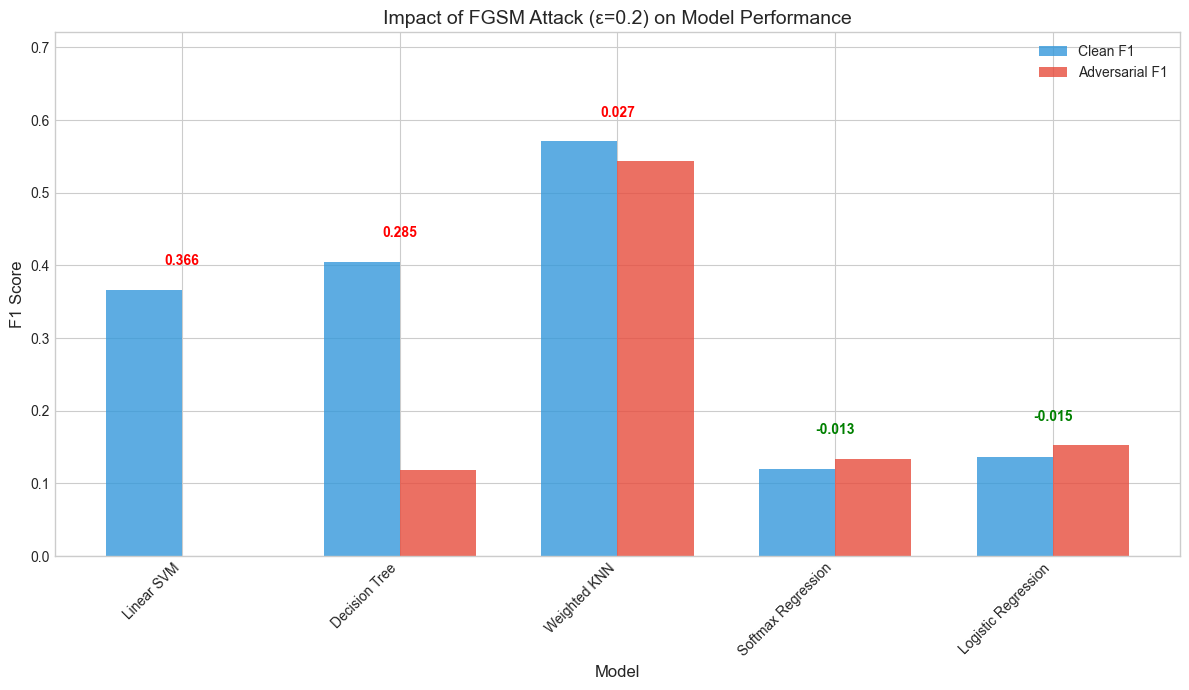

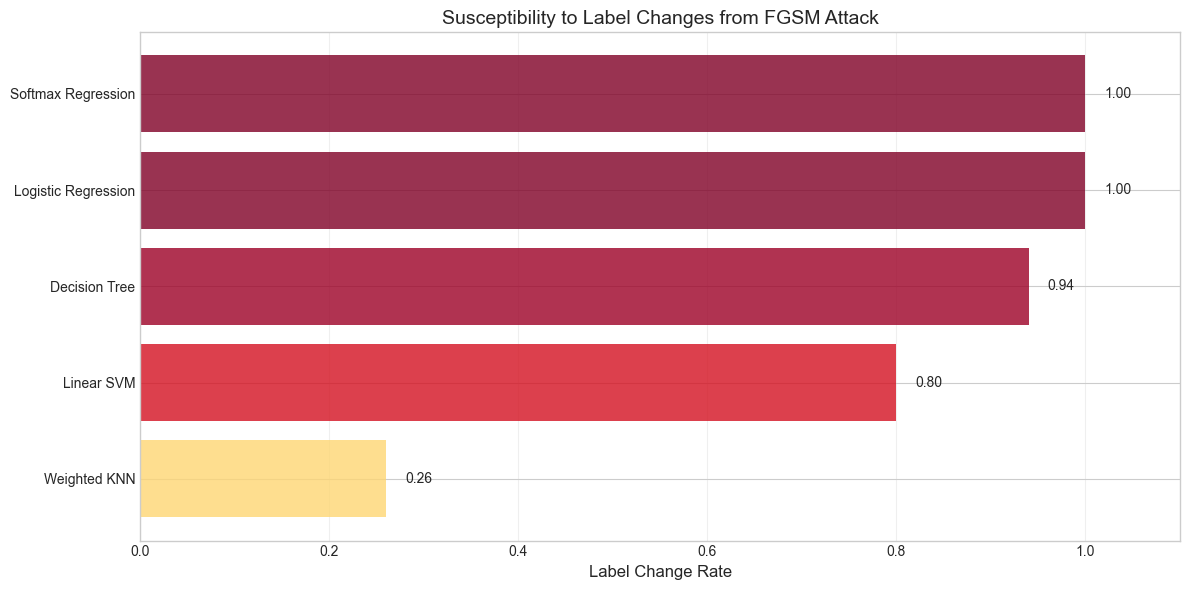

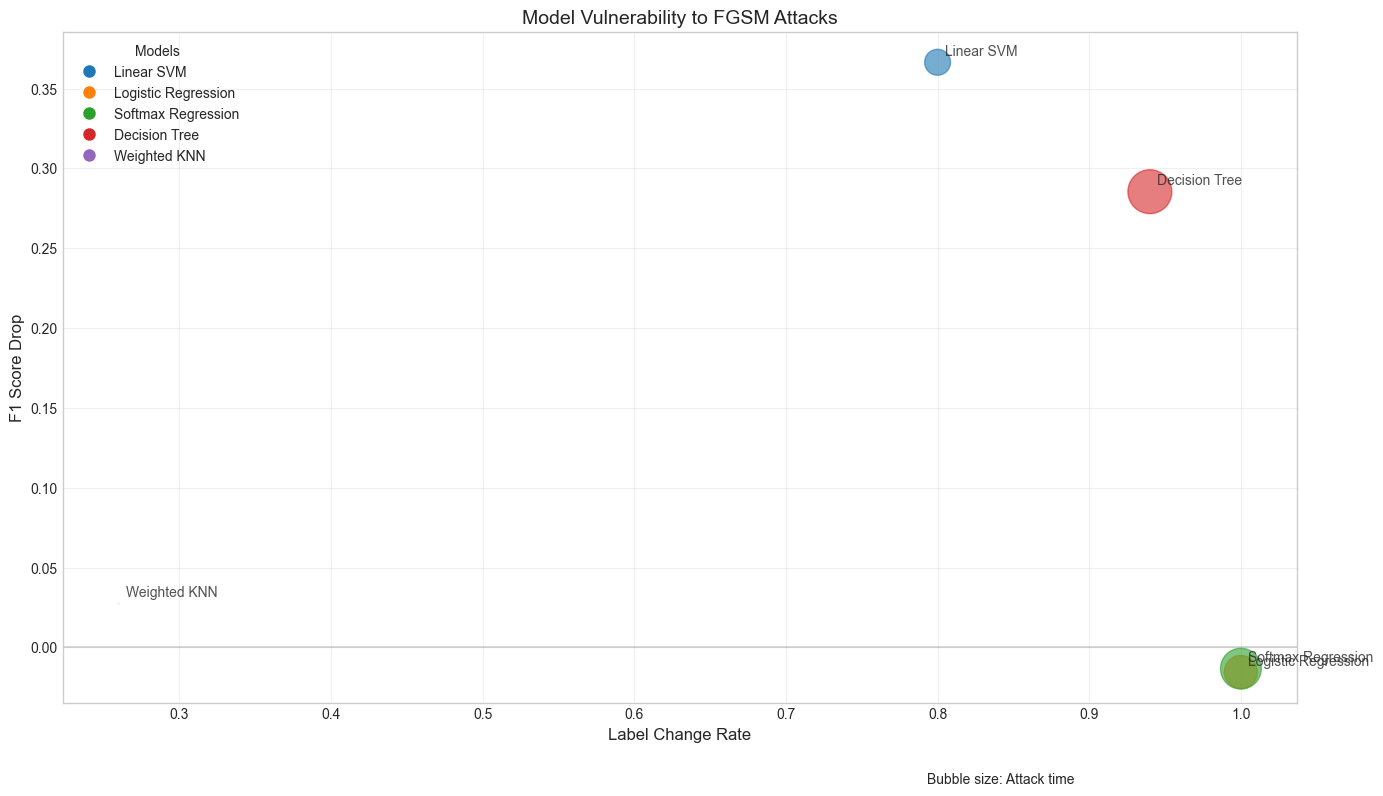

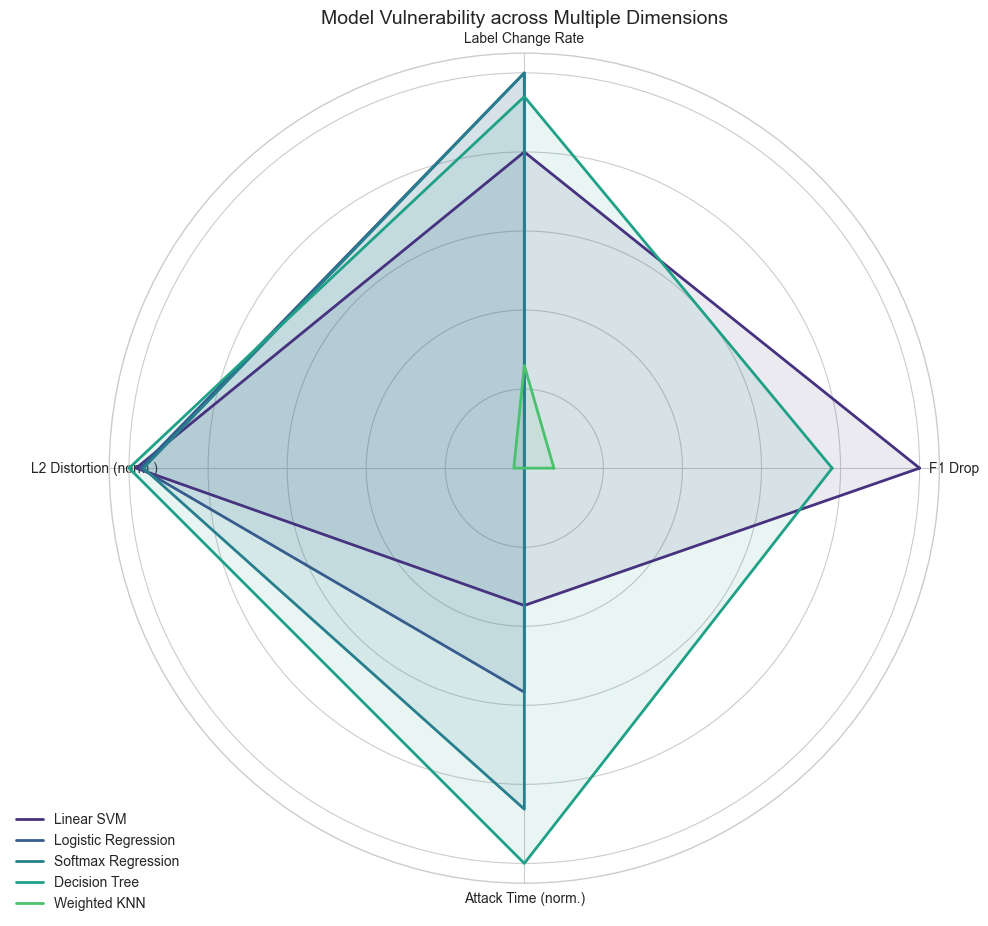

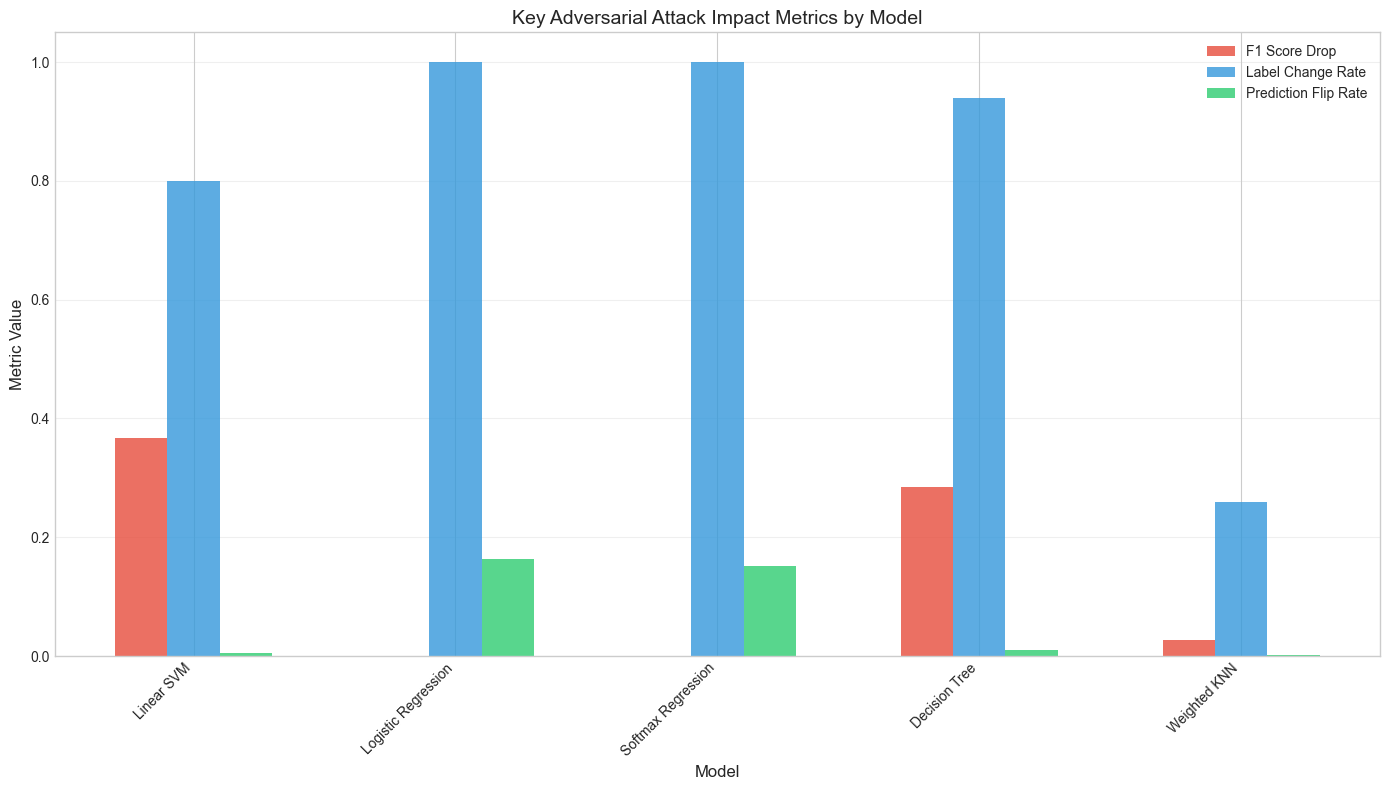

In [46]:
# Set style for better visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# 1. F1 scores before and after attacks
plt.figure(figsize=(12, 7))
bar_width = 0.35
models = results_df['model'].values
x = np.arange(len(models))

# Sort by F1 drop for better visualization
sorted_indices = results_df['f1_drop'].argsort()[::-1]  # Sort by F1 drop (descending)
models = results_df['model'].values[sorted_indices]
clean_f1 = results_df['clean_f1'].values[sorted_indices]
adv_f1 = results_df['adv_f1'].values[sorted_indices]
f1_drop = results_df['f1_drop'].values[sorted_indices]

# Create bars
plt.bar(x - bar_width/2, clean_f1, bar_width, label='Clean F1', color='#3498db', alpha=0.8)
plt.bar(x + bar_width/2, adv_f1, bar_width, label='Adversarial F1', color='#e74c3c', alpha=0.8)

# Add F1 drop annotations
for i, drop in enumerate(f1_drop):
    color = 'red' if drop > 0 else 'green'
    plt.annotate(f'{drop:.3f}', 
                 xy=(i, max(clean_f1[i], adv_f1[i]) + 0.03),
                 ha='center', va='bottom',
                 color=color, fontweight='bold')

# Customize plot
plt.xlabel('Model', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('Impact of FGSM Attack (ε=0.2) on Model Performance', fontsize=14)
plt.xticks(x, models, rotation=45, ha='right')
plt.legend(loc='upper right')
plt.ylim(0, max(max(clean_f1), max(adv_f1)) + 0.15)
plt.tight_layout()
plt.savefig('f1_score_comparison.png', dpi=300)
plt.show()

# 2. Label Change Rate - horizontal bar chart
plt.figure(figsize=(12, 6))

# Sort by label change rate
sorted_indices = results_df['label_change_rate'].argsort()
models = results_df['model'].values[sorted_indices]
label_change = results_df['label_change_rate'].values[sorted_indices]

# Create color gradient based on values
colors = plt.cm.YlOrRd(label_change)

# Create horizontal bars
plt.barh(models, label_change, color=colors, alpha=0.8)

# Add value labels
for i, value in enumerate(label_change):
    plt.text(value + 0.02, i, f'{value:.2f}', va='center')

# Customize plot
plt.xlabel('Label Change Rate', fontsize=12)
plt.title('Susceptibility to Label Changes from FGSM Attack', fontsize=14)
plt.xlim(0, 1.1)  # Since label_change_rate is a percentage
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('label_change_rate.png', dpi=300)
plt.show()

# 3. Multi-metric visualization with bubble chart
plt.figure(figsize=(14, 8))

# Create size values for bubbles (based on attack time, normalized)
max_time = results_df['attack_time'].max()
sizes = results_df['attack_time'] / max_time * 1000  # Scale for better visibility

# Prepare data
models = results_df['model'].values
label_changes = results_df['label_change_rate'].values
f1_drops = results_df['f1_drop'].values

# Create a color map for models
model_colors = {model: plt.cm.tab10(i) for i, model in enumerate(results_df['model'].unique())}
colors = [model_colors[model] for model in models]

# Create the scatter plot
scatter = plt.scatter(label_changes, f1_drops, s=sizes, c=colors, alpha=0.6)

# Add model names as annotations
for i, model in enumerate(models):
    plt.annotate(model, (label_changes[i], f1_drops[i]),
                xytext=(5, 5), textcoords='offset points',
                fontsize=10, alpha=0.8)

# Create legend for models
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                             markerfacecolor=color, markersize=10, label=model)
                  for model, color in model_colors.items()]
plt.legend(handles=legend_elements, title='Models', loc='upper left')

# Add size legend
plt.annotate('Bubble size: Attack time', xy=(0.7, -0.12), 
            xycoords='axes fraction', fontsize=10)

# Customize plot
plt.xlabel('Label Change Rate', fontsize=12)
plt.ylabel('F1 Score Drop', fontsize=12)
plt.title('Model Vulnerability to FGSM Attacks', fontsize=14)
plt.grid(alpha=0.3)
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.savefig('model_vulnerability_bubble.png', dpi=300)
plt.show()

# 4. Radar/Spider chart for multi-dimensional comparison
from math import pi

# Prepare data for radar chart
categories = ['F1 Drop', 'Label Change Rate', 'L2 Distortion (norm.)', 'Attack Time (norm.)']
models = results_df['model'].values

# Normalize metrics for better comparison
f1_drops = results_df['f1_drop'].values
# Convert negative drops to 0 (improvements shouldn't be counted as "robust")
f1_drops = np.maximum(f1_drops, 0)
max_f1_drop = max(f1_drops) if max(f1_drops) > 0 else 1
f1_drops_norm = f1_drops / max_f1_drop if max_f1_drop > 0 else f1_drops

label_changes = results_df['label_change_rate'].values
l2_dist = results_df['l2_distortion'].values / results_df['l2_distortion'].max()
attack_times = results_df['attack_time'].values / results_df['attack_time'].max()

# Create radar chart
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Number of variables
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Close the loop

# Draw the chart for each model
for i, model in enumerate(models):
    # Prepare values
    values = [f1_drops_norm[i], label_changes[i], l2_dist[i], attack_times[i]]
    values += values[:1]  # Close the loop
    
    # Plot values
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=model)
    ax.fill(angles, values, alpha=0.1)

# Set chart properties
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_yticklabels([])  # Hide radial labels
ax.grid(True)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('Model Vulnerability across Multiple Dimensions', fontsize=14)
plt.tight_layout()
plt.savefig('radar_vulnerability.png', dpi=300)
plt.show()

# 5. Combined metric histogram - highlighting most important metrics
plt.figure(figsize=(14, 8))

# Create a grouped bar chart for key metrics
x = np.arange(len(models))
width = 0.2

# Use only important metrics
metrics = ['f1_drop', 'label_change_rate', 'prediction_flip_rate']
metric_labels = ['F1 Score Drop', 'Label Change Rate', 'Prediction Flip Rate']
colors = ['#e74c3c', '#3498db', '#2ecc71']

for i, (metric, label, color) in enumerate(zip(metrics, metric_labels, colors)):
    # For F1 drop, use absolute value to treat improvements as 0
    values = results_df[metric].values
    if metric == 'f1_drop':
        values = np.maximum(values, 0)
    
    plt.bar(x + (i-1)*width, values, width, label=label, color=color, alpha=0.8)

plt.xlabel('Model', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.title('Key Adversarial Attack Impact Metrics by Model', fontsize=14)
plt.xticks(x, models, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('key_metrics_comparison.png', dpi=300)
plt.show()

### Black Box attack (Boundary attack)

In [47]:
def random_noise_attack(model, x, y, epsilon=0.2, alpha=0.1):
    """
    Random noise attack - adds calibrated noise to input.
    
    Parameters:
    -----------
    model : trained model
        Target model to attack
    x : array-like
        Original input example (single instance)
    y : array-like
        Original labels (multilabel format)
    epsilon : float
        Maximum perturbation size
    alpha : float
        Noise strength factor
        
    Returns:
    --------
    x_adv : array-like
        Adversarial example
    """
    x_adv = x.copy()
    
    # Get original prediction
    original_pred = model.predict(x.reshape(1, -1))[0]
    
    # Add random noise and test if prediction changes
    best_noise = None
    best_diff_count = 0
    
    # Try multiple noise patterns
    for _ in range(10):
        noise = np.random.normal(0, alpha, size=x.shape)
        noise = np.clip(noise, -epsilon, epsilon)  # Constrain noise
        
        x_test = x + noise
        x_test = np.clip(x_test, 0, 1)  # Keep in valid range
        
        # Check if prediction changed
        new_pred = model.predict(x_test.reshape(1, -1))[0]
        diff_count = np.sum(original_pred != new_pred)
        
        if diff_count > best_diff_count:
            best_diff_count = diff_count
            best_noise = noise
    
    if best_noise is not None:
        x_adv = np.clip(x + best_noise, 0, 1)
    
    return x_adv

def boundary_attack(model, x, y, epsilon=0.2, steps=20):
    """
    Simplified boundary attack - tries to find adversarial examples
    by walking around the decision boundary.
    
    Parameters:
    -----------
    model : trained model
        Target model to attack
    x : array-like
        Original input example (single instance)
    y : array-like
        Original labels (multilabel format)
    epsilon : float
        Maximum perturbation size
    steps : int
        Number of steps to take
        
    Returns:
    --------
    x_adv : array-like
        Adversarial example
    """
    x_adv = x.copy()
    
    # Get original prediction
    original_pred = model.predict(x.reshape(1, -1))[0]
    
    # Start with a random perturbation
    noise = np.random.normal(0, epsilon/2, size=x.shape)
    perturbed = np.clip(x + noise, 0, 1)
    
    # Initialize best adversarial example
    best_adv = perturbed
    best_diff = 0
    
    # Walk around the decision boundary
    for _ in range(steps):
        # Get current prediction
        curr_pred = model.predict(perturbed.reshape(1, -1))[0]
        curr_diff = np.sum(curr_pred != original_pred)
        
        if curr_diff > best_diff:
            best_diff = curr_diff
            best_adv = perturbed.copy()
        
        # Add small random direction
        direction = np.random.normal(0, 1, size=x.shape)
        direction = direction / np.linalg.norm(direction)
        
        # Step size decreases over time
        step_size = epsilon * (1 - (_/steps))
        
        # Take step
        perturbed = perturbed + step_size * direction
        
        # Project back to epsilon neighborhood
        delta = perturbed - x
        norm = np.linalg.norm(delta)
        if norm > epsilon:
            delta = delta * epsilon / norm
            perturbed = x + delta
        
        # Keep in valid range
        perturbed = np.clip(perturbed, 0, 1)
    
    if best_diff > 0:
        x_adv = best_adv
    
    return x_adv

def transfer_attack(model, x, y, model_collection, target_name, epsilon=0.2):
    """
    Transfer attack - uses other models to generate adversarial examples.
    
    Parameters:
    -----------
    model : trained model
        Target model to attack
    x : array-like
        Original input example (single instance)
    y : array-like
        Original labels (multilabel format)
    model_collection : dict
        Dictionary of all available models
    target_name : str
        Name of the target model
    epsilon : float
        Maximum perturbation size
        
    Returns:
    --------
    x_adv : array-like
        Adversarial example
    """
    x_adv = x.copy()
    
    # Choose a surrogate model (different from the target)
    surrogate_models = {name: m for name, m in model_collection.items() 
                       if name != target_name}
    
    if not surrogate_models:
        return random_noise_attack(model, x, y, epsilon)
    
    # Randomly select a surrogate model
    surrogate_name = random.choice(list(surrogate_models.keys()))
    surrogate = surrogate_models[surrogate_name]
    
    # Get original predictions from both models
    original_pred = model.predict(x.reshape(1, -1))[0]
    
    best_adv = x.copy()
    best_diff = 0
    
    # Try different perturbation magnitudes
    for scale in [0.25, 0.5, 0.75, 1.0]:
        current_epsilon = scale * epsilon
        
        # Generate noise in random directions
        for _ in range(5):
            noise = np.random.normal(0, current_epsilon/2, size=x.shape)
            noise = np.clip(noise, -current_epsilon, current_epsilon)
            x_test = np.clip(x + noise, 0, 1)
            
            # Check if the surrogate model prediction changes
            surrogate_pred = surrogate.predict(x_test.reshape(1, -1))[0]
            target_pred = model.predict(x_test.reshape(1, -1))[0]
            
            # Count differences in target model prediction
            diff_count = np.sum(original_pred != target_pred)
            
            if diff_count > best_diff:
                best_diff = diff_count
                best_adv = x_test.copy()
    
    if best_diff > 0:
        x_adv = best_adv
        
    return x_adv

In [48]:
class EnsembleModel:
    """
    Ensemble model that combines predictions from multiple models.
    """
    def __init__(self, models, model_names=None, weights=None):
        self.models = list(models.values())
        self.model_names = model_names or list(models.keys())
        
        # Equal weights by default
        if weights is None:
            self.weights = np.ones(len(self.models)) / len(self.models)
        else:
            self.weights = weights / np.sum(weights)
        
        # Track if each model uses reduced features
        self.uses_reduced = [name == 'Weighted KNN' for name in self.model_names]
    
    def predict(self, X):
        """
        Make predictions by averaging predictions from all models.
        
        Parameters:
        -----------
        X : array-like
            Input features (can be a single example or batch)
            
        Returns:
        --------
        np.ndarray
            Binary predictions after majority voting
        """
        # Ensure X is 2D
        if X.ndim == 1:
            X = X.reshape(1, -1)
            
        # Store predictions from each model
        all_preds = []
        
        # Get predictions from each model
        for i, model in enumerate(self.models):
            if not self.uses_reduced[i]:
                pred = model.predict(X)
            else:
                # For models using reduced features, we skip
                # This assumes X_reduced will be passed for such models separately
                continue
                
            all_preds.append(pred * self.weights[i])
        
        # Average predictions
        avg_pred = np.sum(all_preds, axis=0)
        
        # Convert to binary predictions (threshold at 0.5)
        binary_pred = (avg_pred > 0.5).astype(int)
        
        return binary_pred

In [49]:
def generate_adversarial_examples_blackbox(model, X, y, attack_type='random', epsilon=0.2, 
                                          sample_size=None, progress=True, model_name=None,
                                          models_dict=None):
    """
    Generate adversarial examples using black box attacks.
    
    Parameters:
    -----------
    model : classifier object
        Trained model with predict method
    X : numpy.ndarray
        Input features
    y : numpy.ndarray
        True labels
    attack_type : str, default='random'
        Type of attack ('random', 'boundary', or 'transfer')
    epsilon : float, default=0.2
        Attack strength parameter
    sample_size : int, optional
        Number of samples to attack (if None, attack all)
    progress : bool, default=True
        Whether to show progress bar
    model_name : str, optional
        Name of the model (needed for transfer attack)
    models_dict : dict, optional
        Dictionary of all models (needed for transfer attack)
        
    Returns:
    --------
    tuple
        (X_adv, indices) - Adversarial examples and their indices
    """
    if sample_size is None:
        sample_size = X.shape[0]
    else:
        sample_size = min(sample_size, X.shape[0])
    
    # Randomly select samples
    indices = np.random.choice(X.shape[0], sample_size, replace=False)
    X_selected = X[indices]
    y_selected = y[indices]
    
    X_adv = np.zeros_like(X_selected)
    
    iterator = tqdm(range(sample_size)) if progress else range(sample_size)
    for i in iterator:
        x = X_selected[i]
        true_y = y_selected[i]
        
        if attack_type.lower() == 'random':
            X_adv[i] = random_noise_attack(model, x, true_y, epsilon)
        elif attack_type.lower() == 'boundary':
            X_adv[i] = boundary_attack(model, x, true_y, epsilon)
        elif attack_type.lower() == 'transfer' and models_dict is not None and model_name is not None:
            X_adv[i] = transfer_attack(model, x, true_y, models_dict, model_name, epsilon)
        else:
            # Default to random noise attack
            X_adv[i] = random_noise_attack(model, x, true_y, epsilon)
    
    return X_adv, indices

In [50]:
# Create an ensemble model (excluding KNN which uses reduced features)
models_for_ensemble = {name: model for name, model in trained_models.items() 
                      if name != 'Weighted KNN'}
ensemble_model = EnsembleModel(models_for_ensemble)

# Add the ensemble to our models
all_models = trained_models.copy()
all_models['Ensemble'] = ensemble_model

# Define attack parameters
sample_size = 50  # Use a smaller subset for demonstration
epsilons = [0.2]  # Keep epsilon consistent with FGSM attack
attack_types = ['random', 'boundary', 'transfer']  # Try all black box attack types

# Create results storage
blackbox_results = []

# Run attacks on all models
print("\n" + "="*70)
print("RUNNING BLACK BOX ATTACKS ON ALL MODELS")
print("="*70)

for model_name, model in all_models.items():
    print(f"\n{'='*50}")
    print(f"Black box attacking {model_name}...")
    print(f"{'='*50}")
    
    # Select appropriate features based on model
    if model_name != 'Weighted KNN':
        features = X_test_scaled
    else:
        features = X_test_reduced
    
    # Run attacks with different types
    for attack_type in attack_types:
        for epsilon in epsilons:
            print(f"\nRunning {attack_type.upper()} attack with ε={epsilon} on {model_name}...")
            
            try:
                # Generate adversarial examples
                start_time = time.time()
                
                # For transfer attack, we need to pass the model dictionary
                if attack_type.lower() == 'transfer':
                    X_adv, indices = generate_adversarial_examples_blackbox(
                        model, features, test_labels,
                        attack_type=attack_type,
                        epsilon=epsilon,
                        sample_size=sample_size,
                        model_name=model_name,
                        models_dict=all_models
                    )
                else:
                    X_adv, indices = generate_adversarial_examples_blackbox(
                        model, features, test_labels,
                        attack_type=attack_type,
                        epsilon=epsilon,
                        sample_size=sample_size
                    )
                    
                attack_time = time.time() - start_time
                
                # Evaluate attack
                results = evaluate_adversarial_examples(
                    model, features[indices], X_adv, test_labels[indices],
                    model_name, f"{attack_type.upper()}-ε{epsilon}"
                )
                
                # Add timing information
                results['attack_time'] = attack_time
                results['epsilon'] = epsilon
                results['attack_type'] = attack_type
                
                # Print results
                print(f"  Clean F1: {results['clean_f1']:.4f}")
                print(f"  Adversarial F1: {results['adv_f1']:.4f}")
                print(f"  F1 Drop: {results['f1_drop']:.4f}")
                print(f"  Label Change Rate: {results['label_change_rate']:.4f}")
                print(f"  Time: {attack_time:.2f}s")
                
                blackbox_results.append(results)
                
            except Exception as e:
                print(f"  Attack failed: {str(e)}")

# Convert results to DataFrame
blackbox_df = pd.DataFrame(blackbox_results)

# Save full results to CSV
blackbox_df.to_csv("blackbox_attack_results.csv", index=False)

# Create a summary table
summary_columns = ['model', 'attack', 'attack_type', 'epsilon', 'clean_f1', 'adv_f1', 'f1_drop', 
                  'label_change_rate', 'prediction_flip_rate', 'l2_distortion', 'attack_time']
summary_df = blackbox_df[summary_columns].sort_values(by=['model', 'attack_type', 'f1_drop'], 
                                                    ascending=[True, True, False])

print("\nBlack Box Attack Summary:")
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)
print(summary_df)


RUNNING BLACK BOX ATTACKS ON ALL MODELS

Black box attacking Linear SVM...

Running RANDOM attack with ε=0.2 on Linear SVM...


  0%|          | 0/50 [00:00<?, ?it/s]

  Clean F1: 0.3776
  Adversarial F1: 0.0000
  F1 Drop: 0.3776
  Label Change Rate: 0.7600
  Time: 12.51s

Running BOUNDARY attack with ε=0.2 on Linear SVM...


  0%|          | 0/50 [00:00<?, ?it/s]

  Clean F1: 0.3578
  Adversarial F1: 0.0000
  F1 Drop: 0.3578
  Label Change Rate: 0.7800
  Time: 20.99s

Running TRANSFER attack with ε=0.2 on Linear SVM...


  0%|          | 0/50 [00:00<?, ?it/s]

  Attack failed: X has 2048 features, but DecisionTreeClassifier is expecting 200 features as input.

Black box attacking Logistic Regression...

Running RANDOM attack with ε=0.2 on Logistic Regression...


  0%|          | 0/50 [00:00<?, ?it/s]

  Clean F1: 0.1316
  Adversarial F1: 0.1541
  F1 Drop: -0.0224
  Label Change Rate: 1.0000
  Time: 11.57s

Running BOUNDARY attack with ε=0.2 on Logistic Regression...


  0%|          | 0/50 [00:00<?, ?it/s]

  Clean F1: 0.1281
  Adversarial F1: 0.1457
  F1 Drop: -0.0175
  Label Change Rate: 1.0000
  Time: 21.21s

Running TRANSFER attack with ε=0.2 on Logistic Regression...


  0%|          | 0/50 [00:00<?, ?it/s]

  Attack failed: X has 2048 features, but DecisionTreeClassifier is expecting 200 features as input.

Black box attacking Softmax Regression...

Running RANDOM attack with ε=0.2 on Softmax Regression...


  0%|          | 0/50 [00:00<?, ?it/s]

  Clean F1: 0.1300
  Adversarial F1: 0.1601
  F1 Drop: -0.0301
  Label Change Rate: 1.0000
  Time: 10.38s

Running BOUNDARY attack with ε=0.2 on Softmax Regression...


  0%|          | 0/50 [00:00<?, ?it/s]

  Clean F1: 0.1355
  Adversarial F1: 0.1674
  F1 Drop: -0.0319
  Label Change Rate: 1.0000
  Time: 20.22s

Running TRANSFER attack with ε=0.2 on Softmax Regression...


  0%|          | 0/50 [00:00<?, ?it/s]

  Attack failed: X has 2048 features, but DecisionTreeClassifier is expecting 200 features as input.

Black box attacking Decision Tree...

Running RANDOM attack with ε=0.2 on Decision Tree...


  0%|          | 0/50 [00:00<?, ?it/s]

  Clean F1: 0.3508
  Adversarial F1: 0.1375
  F1 Drop: 0.2133
  Label Change Rate: 0.9400
  Time: 15.46s

Running BOUNDARY attack with ε=0.2 on Decision Tree...


  0%|          | 0/50 [00:00<?, ?it/s]

  Clean F1: 0.3397
  Adversarial F1: 0.1515
  F1 Drop: 0.1882
  Label Change Rate: 0.9000
  Time: 28.25s

Running TRANSFER attack with ε=0.2 on Decision Tree...


  0%|          | 0/50 [00:00<?, ?it/s]

  Attack failed: X has 2048 features, but DecisionTreeClassifier is expecting 200 features as input.

Black box attacking Weighted KNN...

Running RANDOM attack with ε=0.2 on Weighted KNN...


  0%|          | 0/50 [00:00<?, ?it/s]

  Clean F1: 0.4961
  Adversarial F1: 0.0000
  F1 Drop: 0.4961
  Label Change Rate: 0.9200
  Time: 15.25s

Running BOUNDARY attack with ε=0.2 on Weighted KNN...


  0%|          | 0/50 [00:00<?, ?it/s]

  Clean F1: 0.5340
  Adversarial F1: 0.0000
  F1 Drop: 0.5340
  Label Change Rate: 0.9200
  Time: 30.58s

Running TRANSFER attack with ε=0.2 on Weighted KNN...


  0%|          | 0/50 [00:00<?, ?it/s]

  Attack failed: X has 200 features, but LogisticRegression is expecting 2048 features as input.

Black box attacking Ensemble...

Running RANDOM attack with ε=0.2 on Ensemble...


  0%|          | 0/50 [00:00<?, ?it/s]

  Clean F1: 0.3687
  Adversarial F1: 0.1079
  F1 Drop: 0.2607
  Label Change Rate: 0.9800
  Time: 48.22s

Running BOUNDARY attack with ε=0.2 on Ensemble...


  0%|          | 0/50 [00:00<?, ?it/s]

  Clean F1: 0.3930
  Adversarial F1: 0.0839
  F1 Drop: 0.3091
  Label Change Rate: 0.8800
  Time: 89.14s

Running TRANSFER attack with ε=0.2 on Ensemble...


  0%|          | 0/50 [00:00<?, ?it/s]

  Attack failed: X has 2048 features, but DecisionTreeClassifier is expecting 200 features as input.

Black Box Attack Summary:
                  model         attack attack_type  epsilon  clean_f1    adv_f1   f1_drop  label_change_rate  prediction_flip_rate  l2_distortion  attack_time
7         Decision Tree  BOUNDARY-ε0.2    boundary      0.2  0.339713  0.151515  0.188198               0.90              0.009622      31.828662    28.247126
6         Decision Tree    RANDOM-ε0.2      random      0.2  0.350797  0.137536  0.213261               0.94              0.010447      32.009277    15.456485
11             Ensemble  BOUNDARY-ε0.2    boundary      0.2  0.393035  0.083916  0.309119               0.88              0.008797      29.672726    89.141680
10             Ensemble    RANDOM-ε0.2      random      0.2  0.368664  0.107937  0.260727               0.98              0.010653      33.580611    48.220931
1            Linear SVM  BOUNDARY-ε0.2    boundary      0.2  0.357771  0.0000

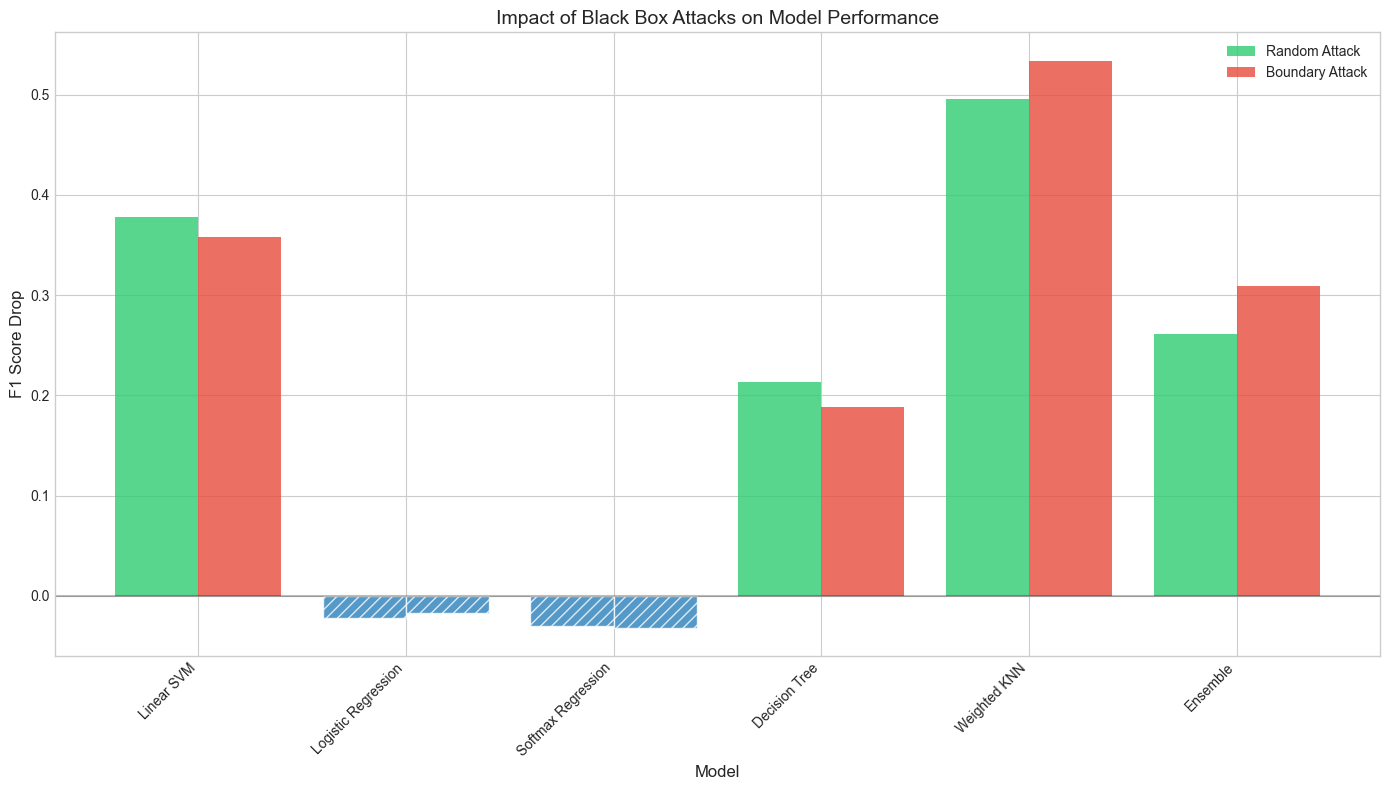

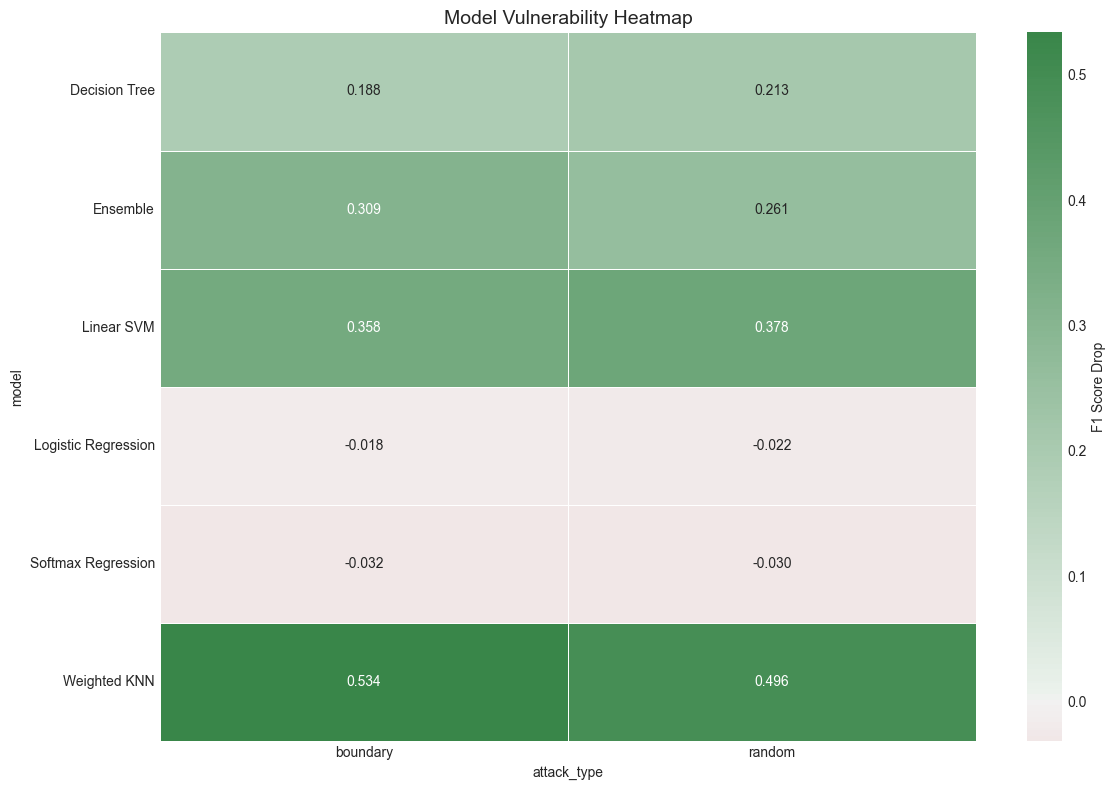

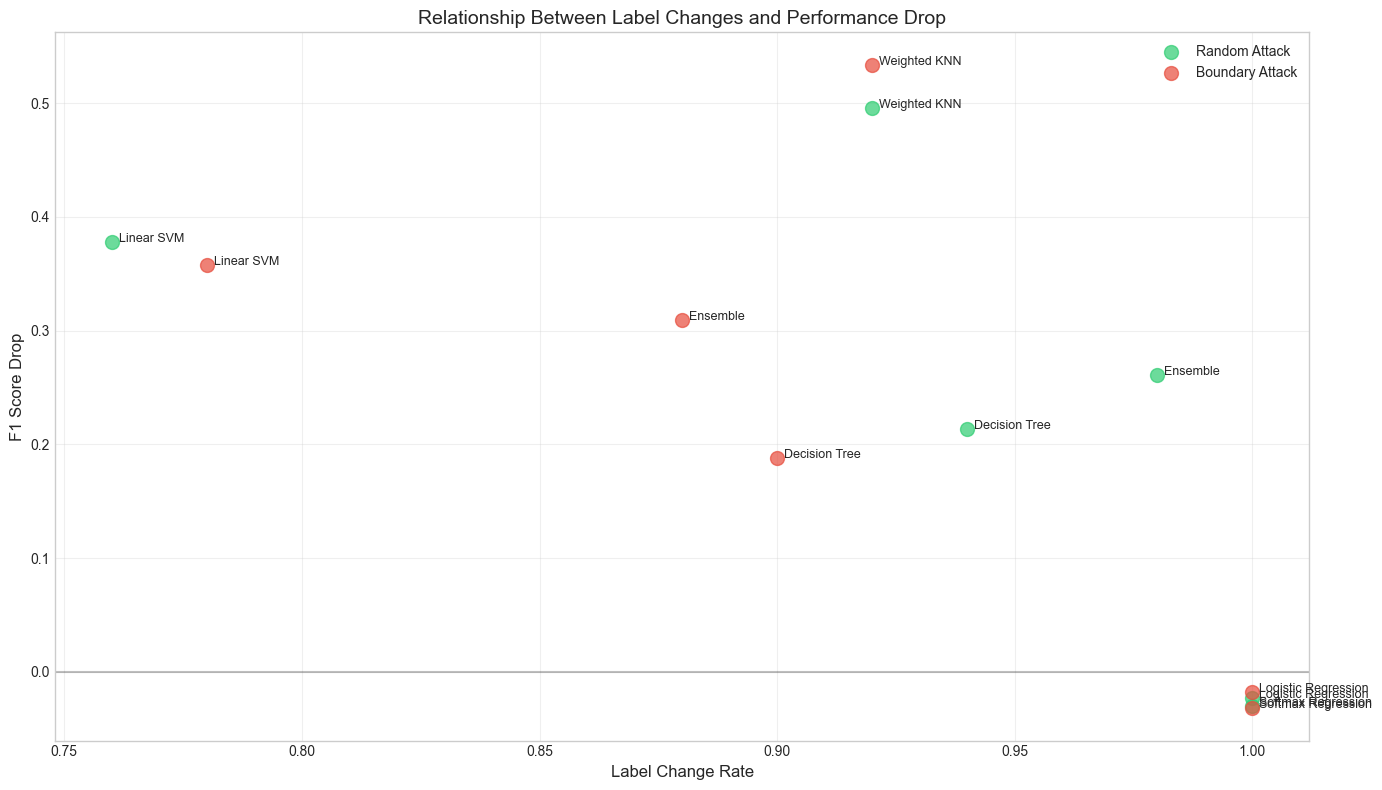

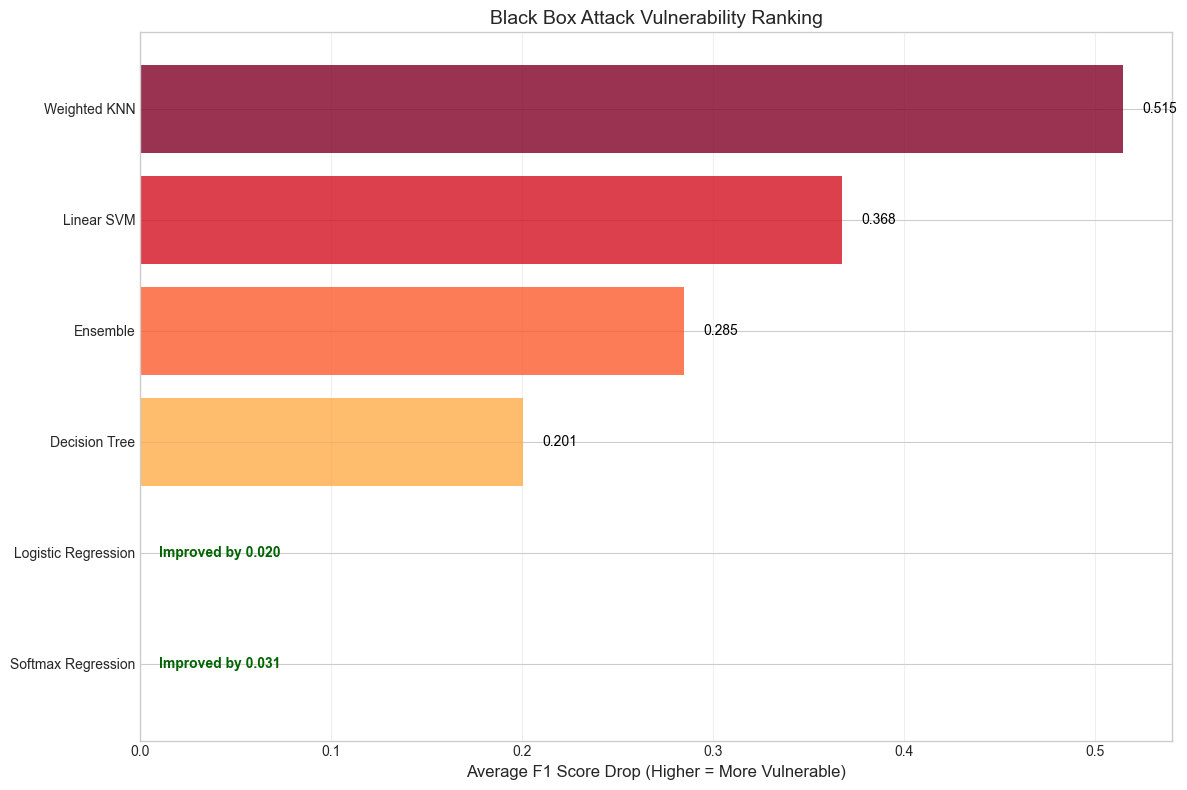

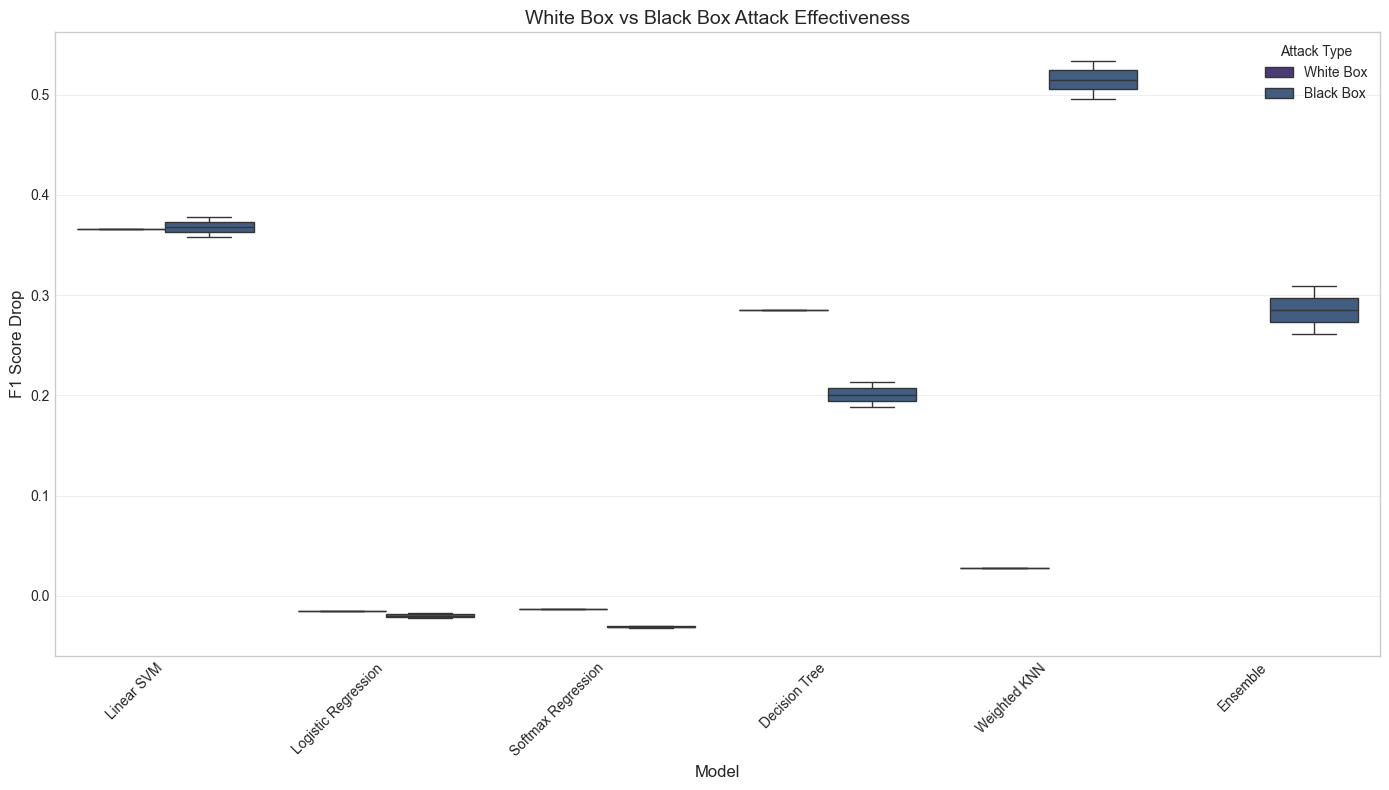

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# 1. Comparison of attack types across models
plt.figure(figsize=(14, 8))

# Extract unique models and attack types
models = blackbox_df['model'].unique()
attacks = blackbox_df['attack_type'].unique()

# Set up the bar chart
x = np.arange(len(models))
width = 0.4  # Width of bars
opacity = 0.8

# Plot bars for each attack type
colors = {'random': '#2ecc71', 'boundary': '#e74c3c', 'transfer': '#3498db'}
for i, attack in enumerate(attacks):
    data = blackbox_df[blackbox_df['attack_type'] == attack]
    
    # Get F1 drops for each model
    f1_drops = []
    for model in models:
        model_data = data[data['model'] == model]
        if not model_data.empty:
            f1_drops.append(model_data['f1_drop'].values[0])
        else:
            f1_drops.append(0)
    
    # Handle negative F1 drops (improvements) for better visualization
    masked_f1_drops = np.ma.masked_less(f1_drops, 0)
    
    # Plot positive values
    plt.bar(x + (i-0.5)*width, masked_f1_drops, width, 
            alpha=opacity, color=colors.get(attack, '#9b59b6'), 
            label=f'{attack.capitalize()} Attack')
    
    # Plot negative values (improvements) as a different bar going down
    if np.any(np.array(f1_drops) < 0):
        improved_models = np.where(np.array(f1_drops) < 0)[0]
        improved_values = np.array(f1_drops)[improved_models]
        plt.bar(improved_models + (i-0.5)*width, improved_values, width, 
                alpha=opacity, color='#2980b9', 
                hatch='///', edgecolor='white')

# Customize plot
plt.xlabel('Model', fontsize=12)
plt.ylabel('F1 Score Drop', fontsize=12)
plt.title('Impact of Black Box Attacks on Model Performance', fontsize=14)
plt.xticks(x, models, rotation=45, ha='right')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.25)
plt.legend()
plt.tight_layout()
plt.savefig('blackbox_f1_drop_comparison.png', dpi=300)
plt.show()

# 2. Heatmap of model vulnerabilities
plt.figure(figsize=(12, 8))

# Create a pivot table with models as rows and attack types as columns
heatmap_data = blackbox_df.pivot_table(
    index='model', 
    columns='attack_type',
    values='f1_drop'
)

# Create custom colormap that handles negative values differently
cmap = sns.diverging_palette(10, 133, as_cmap=True)

# Create the heatmap
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap=cmap, center=0,
            linewidths=.5, cbar_kws={"label": "F1 Score Drop"})

plt.title('Model Vulnerability Heatmap', fontsize=14)
plt.tight_layout()
plt.savefig('blackbox_vulnerability_heatmap.png', dpi=300)
plt.show()

# 3. Label Change Rate vs F1 Drop scatter
plt.figure(figsize=(14, 8))

# Create a scatter plot
for attack in attacks:
    data = blackbox_df[blackbox_df['attack_type'] == attack]
    plt.scatter(data['label_change_rate'], data['f1_drop'], 
                label=f'{attack.capitalize()} Attack',
                s=100, alpha=0.7, c=colors.get(attack, '#9b59b6'))

    # Add model name annotations
    for _, row in data.iterrows():
        plt.annotate(row['model'], 
                    xy=(row['label_change_rate'], row['f1_drop']),
                    xytext=(5, 0), textcoords='offset points',
                    fontsize=9)

plt.axhline(y=0, color='k', linestyle='-', alpha=0.25)
plt.xlabel('Label Change Rate', fontsize=12)
plt.ylabel('F1 Score Drop', fontsize=12)
plt.title('Relationship Between Label Changes and Performance Drop', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('label_change_vs_f1_drop.png', dpi=300)
plt.show()

# 4. Model robustness ranking
plt.figure(figsize=(12, 8))

# Calculate average F1 drop for each model
model_avg_drops = blackbox_df.groupby('model')['f1_drop'].mean().sort_values()

# Handle negative values (improvements)
pos_drops = model_avg_drops.copy()
pos_drops[pos_drops < 0] = 0  # Set negative drops to 0

# Define colors based on vulnerability
colors = plt.cm.YlOrRd(np.linspace(0, 1, len(model_avg_drops)))
colors = [colors[i] if val >= 0 else plt.cm.GnBu(0.6) for i, val in enumerate(model_avg_drops)]

# Plot horizontal bars
bars = plt.barh(model_avg_drops.index, pos_drops, color=colors, alpha=0.8)

# Add text annotations for each bar
for i, (model, value) in enumerate(model_avg_drops.items()):
    text_color = 'black'
    if value < 0:
        # Add positive bar and text showing improvement
        plt.text(0.01, i, f"Improved by {abs(value):.3f}", 
                 va='center', ha='left', color='darkgreen', fontweight='bold')
    else:
        plt.text(max(value + 0.01, 0.01), i, f"{value:.3f}", 
                 va='center', ha='left', color=text_color)

plt.xlabel('Average F1 Score Drop (Higher = More Vulnerable)', fontsize=12)
plt.title('Black Box Attack Vulnerability Ranking', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('model_vulnerability_ranking.png', dpi=300)
plt.show()

# 6. Black Box vs White Box comparison (if white box results are available)
if 'results_df' in globals():
    plt.figure(figsize=(14, 8))
    
    # Prepare data for comparison
    # Add attack category column to both dataframes
    if 'results_df' in globals():
        whitebox_df = results_df.copy()
        whitebox_df['attack_category'] = 'White Box'
    
    blackbox_df_copy = blackbox_df.copy()
    blackbox_df_copy['attack_category'] = 'Black Box'
    
    # Combine dataframes
    combined_df = pd.concat([whitebox_df, blackbox_df_copy])
    
    # Create a grouped boxplot
    sns.boxplot(x='model', y='f1_drop', hue='attack_category', data=combined_df)
    
    plt.title('White Box vs Black Box Attack Effectiveness', fontsize=14)
    plt.xlabel('Model', fontsize=12)
    plt.ylabel('F1 Score Drop', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Attack Type')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('whitebox_vs_blackbox_comparison.png', dpi=300)
    plt.show()

### Targetted Attack

In [53]:
def flip_specific_labels_attack(model, x, y, target_labels, epsilon=0.2, iterations=20, flip_to_one=True):
    """
    Targeted attack that attempts to flip specific labels in a multilabel classification.
    
    Parameters:
    -----------
    model : trained model
        Target model to attack
    x : array-like
        Original input example (single instance)
    y : array-like
        Original labels (multilabel format)
    target_labels : list or array
        Indices of labels to flip
    epsilon : float
        Maximum perturbation size
    iterations : int
        Number of optimization iterations
    flip_to_one : bool
        If True, flip 0→1 (false positive), if False, flip 1→0 (false negative)
        
    Returns:
    --------
    x_adv : array-like
        Adversarial example
    """
    x_adv = x.copy()
    
    # Get original prediction
    orig_pred = model.predict(x.reshape(1, -1))[0]
    
    # Create target prediction vector
    target_pred = orig_pred.copy()
    for label in target_labels:
        if label < len(target_pred):
            target_pred[label] = 1 if flip_to_one else 0
    
    # If target already matches original, no need to attack
    if np.array_equal(orig_pred, target_pred):
        return x_adv
    
    best_score = 0
    best_adv = x_adv.copy()
    
    # Generate multiple perturbation candidates
    for _ in range(iterations):
        # Create a random perturbation direction
        noise = np.random.normal(0, 1, size=x.shape)
        noise = noise / np.linalg.norm(noise) * epsilon * np.random.uniform(0.5, 1.0)
        
        # Apply perturbation
        perturbed = np.clip(x + noise, 0, 1)
        
        # Check how well this perturbation achieves the target
        pred = model.predict(perturbed.reshape(1, -1))[0]
        
        # Calculate score based on how many targeted labels were flipped as desired
        score = 0
        for label in target_labels:
            if label < len(pred):
                if (flip_to_one and pred[label] == 1) or (not flip_to_one and pred[label] == 0):
                    score += 1
        
        # Account for preserving other labels (weight this less)
        for i in range(len(pred)):
            if i not in target_labels and pred[i] == orig_pred[i]:
                score += 0.1
        
        # Update best result
        if score > best_score:
            best_score = score
            best_adv = perturbed.copy()
    
    return best_adv

def targeted_covert_attack(model, x, y, target_labels, epsilon=0.2, iterations=20, 
                          flip_to_one=True, preserve_others=True):
    """
    More sophisticated targeted attack that attempts to be covert by preserving predictions
    for non-targeted labels.
    
    Parameters:
    -----------
    model : trained model
        Target model to attack
    x : array-like
        Original input example (single instance)
    y : array-like
        Original labels (multilabel format)
    target_labels : list or array
        Indices of labels to flip
    epsilon : float
        Maximum perturbation size
    iterations : int
        Number of optimization iterations
    flip_to_one : bool
        If True, flip 0→1 (false positive), if False, flip 1→0 (false negative)
    preserve_others : bool
        If True, try to maintain predictions for non-targeted labels
        
    Returns:
    --------
    x_adv : array-like
        Adversarial example
    """
    x_adv = x.copy()
    
    # Get original prediction
    orig_pred = model.predict(x.reshape(1, -1))[0]
    
    # Initialize perturbation
    delta = np.zeros_like(x)
    best_delta = delta.copy()
    best_score = -float('inf')
    
    # For faster optimization, focus on a subset of features
    n_features = min(100, x.shape[0])
    feature_indices = np.random.choice(x.shape[0], n_features, replace=False)
    
    # Coordinate descent optimization
    for _ in range(iterations):
        for idx in feature_indices:
            # Try different perturbation magnitudes
            for direction in [-1, 1]:
                for step in [0.5, 0.75, 1.0]:
                    test_delta = delta.copy()
                    test_delta[idx] += direction * epsilon * step
                    
                    # Ensure perturbation is within constraints
                    x_test = np.clip(x + test_delta, 0, 1)
                    
                    # Get prediction
                    pred = model.predict(x_test.reshape(1, -1))[0]
                    
                    # Calculate score
                    score = 0
                    
                    # Primary objective: flip target labels
                    for label in target_labels:
                        if label < len(pred):
                            if (flip_to_one and pred[label] == 1) or (not flip_to_one and pred[label] == 0):
                                score += 10  # Higher weight for primary objective
                    
                    # Secondary objective: preserve other labels
                    if preserve_others:
                        for i in range(len(pred)):
                            if i not in target_labels and pred[i] == orig_pred[i]:
                                score += 1
                    
                    # Penalty for L2 norm to encourage minimal perturbation
                    score -= 0.1 * np.sum(test_delta**2)
                    
                    if score > best_score:
                        best_score = score
                        best_delta = test_delta.copy()
        
        # Update perturbation
        delta = best_delta.copy()
    
    # Apply best perturbation
    x_adv = np.clip(x + best_delta, 0, 1)
    
    return x_adv

def targeted_ensemble_attack(models, x, y, target_labels, epsilon=0.2, 
                           iterations=20, flip_to_one=True, model_weights=None):
    """
    Targeted attack optimized for ensemble models - attempts to find adversarial examples
    that work across multiple models.
    
    Parameters:
    -----------
    models : list
        List of models to attack
    x : array-like
        Original input example (single instance)
    y : array-like
        Original labels (multilabel format)
    target_labels : list or array
        Indices of labels to flip
    epsilon : float
        Maximum perturbation size
    iterations : int
        Number of optimization iterations
    flip_to_one : bool
        If True, flip 0→1 (false positive), if False, flip 1→0 (false negative)
    model_weights : list or array, optional
        Weights for each model in the ensemble
        
    Returns:
    --------
    x_adv : array-like
        Adversarial example
    """
    if model_weights is None:
        model_weights = np.ones(len(models)) / len(models)
    
    x_adv = x.copy()
    best_adv = x.copy()
    best_score = -float('inf')
    
    # Multi-step optimization
    for _ in range(iterations):
        # Generate candidate perturbation
        noise = np.random.normal(0, epsilon/3, size=x.shape)
        candidate = np.clip(x_adv + noise, 0, 1)
        
        # Initialize score for this candidate
        score = 0
        
        # Evaluate candidate across all models
        for i, model in enumerate(models):
            pred = model.predict(candidate.reshape(1, -1))[0]
            
            # Score based on targeted label flips
            for label in target_labels:
                if label < len(pred):
                    if (flip_to_one and pred[label] == 1) or (not flip_to_one and pred[label] == 0):
                        score += 10 * model_weights[i]
        
        # Update if better
        if score > best_score:
            best_score = score
            best_adv = candidate.copy()
            
        # Update current position with momentum
        x_adv = 0.8 * x_adv + 0.2 * best_adv
        
        # Project back to epsilon neighborhood
        delta = x_adv - x
        norm = np.linalg.norm(delta)
        if norm > epsilon:
            delta = delta * epsilon / norm
            x_adv = np.clip(x + delta, 0, 1)
    
    return best_adv

In [54]:
def generate_targeted_adversarial_examples(model, X, y, attack_type='flip_specific', 
                                         epsilon=0.2, sample_size=None, progress=True,
                                         target_label_strategy='most_frequent', 
                                         num_target_labels=1, flip_to_one=None,
                                         model_name=None, models_dict=None):
    """
    Generate adversarial examples using targeted attacks.
    
    Parameters:
    -----------
    model : classifier object
        Trained model with predict method
    X : numpy.ndarray
        Input features
    y : numpy.ndarray
        True labels
    attack_type : str
        Type of attack ('flip_specific', 'covert', or 'ensemble')
    epsilon : float
        Attack strength parameter
    sample_size : int, optional
        Number of samples to attack (if None, attack all)
    progress : bool
        Whether to show progress bar
    target_label_strategy : str
        Strategy for selecting target labels ('most_frequent', 'least_frequent', 'random')
    num_target_labels : int
        Number of labels to target
    flip_to_one : bool or None
        If True, flip 0→1 (false positives), if False, flip 1→0 (false negatives)
        If None, mix of both based on original label
    model_name : str
        Name of model (for ensemble attack)
    models_dict : dict
        Dictionary of models (for ensemble attack)
    
    Returns:
    --------
    tuple
        (X_adv, indices, target_label_indices) - Adversarial examples, their indices,
        and the indices of targeted labels
    """
    if sample_size is None:
        sample_size = X.shape[0]
    else:
        sample_size = min(sample_size, X.shape[0])
    
    # Randomly select samples
    indices = np.random.choice(X.shape[0], sample_size, replace=False)
    X_selected = X[indices]
    y_selected = y[indices]
    
    X_adv = np.zeros_like(X_selected)
    all_target_labels = []
    
    # Get label frequencies from the full dataset
    label_counts = np.sum(y, axis=0)
    label_frequencies = label_counts / len(y)
    
    iterator = tqdm(range(sample_size)) if progress else range(sample_size)
    for i in iterator:
        x = X_selected[i]
        true_y = y_selected[i]
        
        # Select target labels based on strategy
        target_labels = []
        
        if target_label_strategy == 'most_frequent':
            # Target most frequent labels
            active_label_indices = np.argsort(label_frequencies)[::-1]
            
            # For false positives, select from inactive labels
            # For false negatives, select from active labels
            if flip_to_one is None:
                # Mix of false positives and false negatives
                candidate_indices = np.random.choice(len(true_y), 
                                                   min(num_target_labels * 3, len(true_y)), 
                                                   replace=False)
                
                for idx in candidate_indices:
                    if len(target_labels) >= num_target_labels:
                        break
                    target_labels.append(idx)
                    
            elif flip_to_one:
                # Target inactive labels (looking for false positives)
                inactive_indices = np.where(true_y == 0)[0]
                if len(inactive_indices) > 0:
                    # Sort by frequency
                    sorted_indices = sorted(inactive_indices, 
                                          key=lambda idx: label_frequencies[idx], 
                                          reverse=True)
                    target_labels = sorted_indices[:num_target_labels]
            else:
                # Target active labels (looking for false negatives)
                active_indices = np.where(true_y == 1)[0]
                if len(active_indices) > 0:
                    target_labels = active_indices[:num_target_labels]
        
        elif target_label_strategy == 'least_frequent':
            # Similar logic but with least frequent labels
            active_label_indices = np.argsort(label_frequencies)
            
            if flip_to_one is None:
                candidate_indices = np.random.choice(len(true_y), 
                                                   min(num_target_labels * 3, len(true_y)), 
                                                   replace=False)
                
                for idx in candidate_indices:
                    if len(target_labels) >= num_target_labels:
                        break
                    target_labels.append(idx)
            
            elif flip_to_one:
                inactive_indices = np.where(true_y == 0)[0]
                if len(inactive_indices) > 0:
                    sorted_indices = sorted(inactive_indices, 
                                          key=lambda idx: label_frequencies[idx])
                    target_labels = sorted_indices[:num_target_labels]
            else:
                active_indices = np.where(true_y == 1)[0]
                if len(active_indices) > 0:
                    # Sort by rarity
                    sorted_indices = sorted(active_indices, 
                                          key=lambda idx: label_frequencies[idx])
                    target_labels = sorted_indices[:num_target_labels]
        
        else:  # 'random'
            if flip_to_one is None:
                # Mix of false positives and false negatives
                target_labels = np.random.choice(len(true_y), 
                                              min(num_target_labels, len(true_y)), 
                                              replace=False)
            elif flip_to_one:
                # Target inactive labels (looking for false positives)
                inactive_indices = np.where(true_y == 0)[0]
                if len(inactive_indices) > 0:
                    target_labels = np.random.choice(inactive_indices, 
                                                   min(num_target_labels, len(inactive_indices)), 
                                                   replace=False)
            else:
                # Target active labels (looking for false negatives)
                active_indices = np.where(true_y == 1)[0]
                if len(active_indices) > 0:
                    target_labels = np.random.choice(active_indices, 
                                                   min(num_target_labels, len(active_indices)), 
                                                   replace=False)
        
        # Use appropriate flip direction
        use_flip_to_one = flip_to_one
        if flip_to_one is None:
            # Decide based on the target label's current value
            use_flip_to_one = (true_y[target_labels[0]] == 0) if len(target_labels) > 0 else True
        
        # Apply the appropriate attack
        if attack_type == 'flip_specific':
            X_adv[i] = flip_specific_labels_attack(
                model, x, true_y, target_labels, epsilon, 
                iterations=20, flip_to_one=use_flip_to_one
            )
        elif attack_type == 'covert':
            X_adv[i] = targeted_covert_attack(
                model, x, true_y, target_labels, epsilon, 
                iterations=15, flip_to_one=use_flip_to_one
            )
        elif attack_type == 'ensemble' and models_dict:
            # For ensemble attack, use multiple models
            if model_name == 'Ensemble':
                # If attacking the ensemble itself, use constituent models
                model_list = [m for name, m in models_dict.items() if name != 'Ensemble']
            else:
                # If attacking a specific model, include the ensemble and a few others
                other_models = [m for name, m in models_dict.items() 
                               if name != model_name and name != 'Ensemble']
                
                # Use at most 3 additional models
                selected_models = np.random.choice(other_models, 
                                                min(3, len(other_models)), 
                                                replace=False).tolist()
                
                # Always include target model first
                model_list = [model] + selected_models
            
            X_adv[i] = targeted_ensemble_attack(
                model_list, x, true_y, target_labels, epsilon, 
                iterations=15, flip_to_one=use_flip_to_one
            )
        else:
            # Default to flip specific
            X_adv[i] = flip_specific_labels_attack(
                model, x, true_y, target_labels, epsilon, 
                iterations=20, flip_to_one=use_flip_to_one
            )
        
        all_target_labels.append(target_labels)
    
    return X_adv, indices, all_target_labels

In [55]:
def evaluate_targeted_adversarial_examples(model, X_clean, X_adv, y_true, target_labels_list, 
                                         model_name, attack_name, flip_to_one=None):
    """
    Evaluate a model's performance on targeted adversarial examples.
    
    Parameters:
    -----------
    model : classifier object
        Model to evaluate
    X_clean : numpy.ndarray
        Original test examples
    X_adv : numpy.ndarray
        Adversarial examples
    y_true : numpy.ndarray
        True labels
    target_labels_list : list of lists
        List of targeted label indices for each example
    model_name : str
        Name of the model
    attack_name : str
        Name of the attack
    flip_to_one : bool or None
        Whether attack was targeting false positives, false negatives, or both
        
    Returns:
    --------
    dict
        Dictionary containing evaluation metrics
    """
    # Predict on clean examples
    y_pred_clean = model.predict(X_clean)
    
    # Predict on adversarial examples
    y_pred_adv = model.predict(X_adv)
    
    # Calculate overall performance metrics (same as before)
    clean_metrics = {
        'accuracy': accuracy_score(y_true, y_pred_clean),
        'precision_micro': precision_score(y_true, y_pred_clean, average='micro'),
        'recall_micro': recall_score(y_true, y_pred_clean, average='micro'),
        'f1_micro': f1_score(y_true, y_pred_clean, average='micro'),
        'hamming_loss': hamming_loss(y_true, y_pred_clean)
    }
    
    adv_metrics = {
        'accuracy': accuracy_score(y_true, y_pred_adv),
        'precision_micro': precision_score(y_true, y_pred_adv, average='micro'),
        'recall_micro': recall_score(y_true, y_pred_adv, average='micro'),
        'f1_micro': f1_score(y_true, y_pred_adv, average='micro'),
        'hamming_loss': hamming_loss(y_true, y_pred_adv)
    }
    
    # Calculate targeted attack success metrics
    target_success_count = 0
    total_targeted_labels = 0
    
    fp_count = 0  # False positives
    fn_count = 0  # False negatives
    fp_total = 0
    fn_total = 0
    
    # For each example, check if target labels were flipped
    for i in range(len(X_clean)):
        for target_label in target_labels_list[i]:
            if target_label < len(y_true[i]):
                total_targeted_labels += 1
                
                # Check if the prediction flipped as intended
                orig_pred = y_pred_clean[i][target_label]
                adv_pred = y_pred_adv[i][target_label]
                
                # Determine if this is targeting a false positive or false negative
                if flip_to_one is None:
                    # Dynamically determined based on the original prediction
                    target_flip_to_one = (orig_pred == 0)
                else:
                    target_flip_to_one = flip_to_one
                
                # Count success based on intended direction
                if target_flip_to_one:
                    # Targeting false positive
                    fp_total += 1
                    if orig_pred == 0 and adv_pred == 1:
                        target_success_count += 1
                        fp_count += 1
                else:
                    # Targeting false negative
                    fn_total += 1
                    if orig_pred == 1 and adv_pred == 0:
                        target_success_count += 1
                        fn_count += 1
    
    # Calculate attack success rate
    target_success_rate = target_success_count / total_targeted_labels if total_targeted_labels > 0 else 0
    fp_success_rate = fp_count / fp_total if fp_total > 0 else 0
    fn_success_rate = fn_count / fn_total if fn_total > 0 else 0
    
    # Calculate how many other (non-targeted) labels changed
    non_target_change_count = 0
    non_target_total = 0
    
    for i in range(len(X_clean)):
        target_labels = target_labels_list[i]
        for j in range(len(y_true[i])):
            if j not in target_labels:
                non_target_total += 1
                if y_pred_clean[i][j] != y_pred_adv[i][j]:
                    non_target_change_count += 1
    
    non_target_change_rate = non_target_change_count / non_target_total if non_target_total > 0 else 0
    
    # L2 distortion
    l2_distortion = np.mean(np.sqrt(np.sum((X_adv - X_clean)**2, axis=1)))
    
    # Calculate performance drops
    accuracy_drop = clean_metrics['accuracy'] - adv_metrics['accuracy']
    f1_drop = clean_metrics['f1_micro'] - adv_metrics['f1_micro']
    
    # Compile results
    results = {
        'model': model_name,
        'attack': attack_name,
        'clean_f1': clean_metrics['f1_micro'],
        'adv_f1': adv_metrics['f1_micro'],
        'clean_precision': clean_metrics['precision_micro'],
        'adv_precision': adv_metrics['precision_micro'], 
        'clean_recall': clean_metrics['recall_micro'],
        'adv_recall': adv_metrics['recall_micro'],
        'f1_drop': f1_drop,
        'target_success_rate': target_success_rate,
        'fp_success_rate': fp_success_rate,
        'fn_success_rate': fn_success_rate, 
        'non_target_change_rate': non_target_change_rate,
        'l2_distortion': l2_distortion,
        'total_targeted_labels': total_targeted_labels,
        'false_positive_attempts': fp_total,
        'false_negative_attempts': fn_total
    }
    
    return results

In [58]:
# Create an ensemble model if not already created
if 'ensemble_model' not in globals():
    models_for_ensemble = {name: model for name, model in trained_models.items() 
                          if name != 'Weighted KNN'}
    ensemble_model = EnsembleModel(models_for_ensemble)
    
    # Add the ensemble to our models
    all_models = trained_models.copy()
    all_models['Ensemble'] = ensemble_model

# Define attack parameters
sample_size = 50  # Use a smaller subset for demonstration
epsilons = [0.2]  # Keep epsilon consistent with previous attacks
attack_types = ['flip_specific']
target_strategies = ['most_frequent']
flip_modes = [True]  # True=false positives, False=false negatives

# Create results storage
targeted_results = []

# Run attacks on all models
print("\n" + "="*70)
print("RUNNING TARGETED ADVERSARIAL ATTACKS ON ALL MODELS")
print("="*70)

for model_name, model in all_models.items():
    print(f"\n{'='*50}")
    print(f"Targeted attacking {model_name}...")
    print(f"{'='*50}")
    
    # Select appropriate features based on model
    if model_name != 'Weighted KNN':
        features = X_test_scaled
    else:
        features = X_test_reduced
    
    # Run attacks with different types and target strategies
    for attack_type in attack_types:
        for strategy in target_strategies:
            for flip_to_one in flip_modes:
                for epsilon in epsilons:
                    # Define attack name
                    flip_direction = "FP" if flip_to_one else "FN"
                    attack_name = f"{attack_type.upper()}-{strategy}-{flip_direction}-ε{epsilon}"
                    
                    print(f"\nRunning {attack_name} on {model_name}...")
                    
                    try:
                        # Generate adversarial examples
                        start_time = time.time()
                        
                        # Number of labels to target (1-3 based on attack type)
                        num_targets = 1
                        if attack_type == 'covert':
                            num_targets = 2
                        elif attack_type == 'ensemble':
                            num_targets = 3
                        
                        X_adv, indices, target_labels_list = generate_targeted_adversarial_examples(
                            model, features, test_labels,
                            attack_type=attack_type,
                            epsilon=epsilon,
                            sample_size=sample_size,
                            target_label_strategy=strategy,
                            num_target_labels=num_targets,
                            flip_to_one=flip_to_one,
                            model_name=model_name,
                            models_dict=all_models
                        )
                        
                        attack_time = time.time() - start_time
                        
                        # Evaluate attack
                        results = evaluate_targeted_adversarial_examples(
                            model, features[indices], X_adv, test_labels[indices],
                            target_labels_list, model_name, attack_name, flip_to_one
                        )
                        
                        # Add timing and attack configuration information
                        results['attack_time'] = attack_time
                        results['epsilon'] = epsilon
                        results['attack_type'] = attack_type
                        results['target_strategy'] = strategy
                        results['flip_to_one'] = flip_to_one
                        
                        # Print results
                        success_rate_label = "FP Success" if flip_to_one else "FN Success"
                        print(f"  Clean F1: {results['clean_f1']:.4f}")
                        print(f"  Adversarial F1: {results['adv_f1']:.4f}")
                        print(f"  Target Success Rate: {results['target_success_rate']:.4f}")
                        print(f"  {success_rate_label}: {results['fp_success_rate' if flip_to_one else 'fn_success_rate']:.4f}")
                        print(f"  Non-Target Change Rate: {results['non_target_change_rate']:.4f}")
                        print(f"  Time: {attack_time:.2f}s")
                        
                        targeted_results.append(results)
                        
                    except Exception as e:
                        print(f"  Attack failed: {str(e)}")
                        import traceback
                        traceback.print_exc()

# Convert results to DataFrame
targeted_df = pd.DataFrame(targeted_results)

# Save full results to CSV
targeted_df.to_csv("targeted_attack_results.csv", index=False)

# Create a summary table
summary_columns = ['model', 'attack', 'clean_f1', 'adv_f1', 'target_success_rate', 
                  'fp_success_rate', 'fn_success_rate', 'non_target_change_rate',
                  'l2_distortion', 'attack_time']
                  
summary_df = targeted_df[summary_columns].sort_values(
    by=['model', 'attack', 'target_success_rate'], 
    ascending=[True, True, False]
)

print("\nTargeted Attack Summary:")
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)
print(summary_df)


RUNNING TARGETED ADVERSARIAL ATTACKS ON ALL MODELS

Targeted attacking Linear SVM...

Running FLIP_SPECIFIC-most_frequent-FP-ε0.2 on Linear SVM...


  0%|          | 0/50 [00:00<?, ?it/s]

  Clean F1: 0.3978
  Adversarial F1: 0.0360
  Target Success Rate: 0.0000
  FP Success: 0.0000
  Non-Target Change Rate: 0.0061
  Time: 17.53s

Targeted attacking Logistic Regression...

Running FLIP_SPECIFIC-most_frequent-FP-ε0.2 on Logistic Regression...


  0%|          | 0/50 [00:00<?, ?it/s]

  Clean F1: 0.1456
  Adversarial F1: 0.1548
  Target Success Rate: 0.0600
  FP Success: 0.0600
  Non-Target Change Rate: 0.0786
  Time: 11.38s

Targeted attacking Softmax Regression...

Running FLIP_SPECIFIC-most_frequent-FP-ε0.2 on Softmax Regression...


  0%|          | 0/50 [00:00<?, ?it/s]

  Clean F1: 0.1322
  Adversarial F1: 0.1345
  Target Success Rate: 0.0800
  FP Success: 0.0800
  Non-Target Change Rate: 0.0724
  Time: 10.28s

Targeted attacking Decision Tree...

Running FLIP_SPECIFIC-most_frequent-FP-ε0.2 on Decision Tree...


  0%|          | 0/50 [00:00<?, ?it/s]

  Clean F1: 0.3440
  Adversarial F1: 0.1690
  Target Success Rate: 0.0400
  FP Success: 0.0400
  Non-Target Change Rate: 0.0079
  Time: 22.38s

Targeted attacking Weighted KNN...

Running FLIP_SPECIFIC-most_frequent-FP-ε0.2 on Weighted KNN...


  0%|          | 0/50 [00:00<?, ?it/s]

  Clean F1: 0.5486
  Adversarial F1: 0.0491
  Target Success Rate: 0.0000
  FP Success: 0.0000
  Non-Target Change Rate: 0.0080
  Time: 21.65s

Targeted attacking Ensemble...

Running FLIP_SPECIFIC-most_frequent-FP-ε0.2 on Ensemble...


  0%|          | 0/50 [00:00<?, ?it/s]

  Clean F1: 0.3910
  Adversarial F1: 0.1859
  Target Success Rate: 0.0000
  FP Success: 0.0000
  Non-Target Change Rate: 0.0072
  Time: 64.58s

Targeted Attack Summary:
                 model                               attack  clean_f1    adv_f1  target_success_rate  fp_success_rate  fn_success_rate  non_target_change_rate  l2_distortion  attack_time
3        Decision Tree  FLIP_SPECIFIC-most_frequent-FP-ε0.2  0.344037  0.169014                 0.04             0.04                0                0.007931      31.505107    22.378158
5             Ensemble  FLIP_SPECIFIC-most_frequent-FP-ε0.2  0.391011  0.185915                 0.00             0.00                0                0.007172      30.437490    64.579482
0           Linear SVM  FLIP_SPECIFIC-most_frequent-FP-ε0.2  0.397820  0.035971                 0.00             0.00                0                0.006138      30.635776    17.533878
1  Logistic Regression  FLIP_SPECIFIC-most_frequent-FP-ε0.2  0.145578  0.154787    

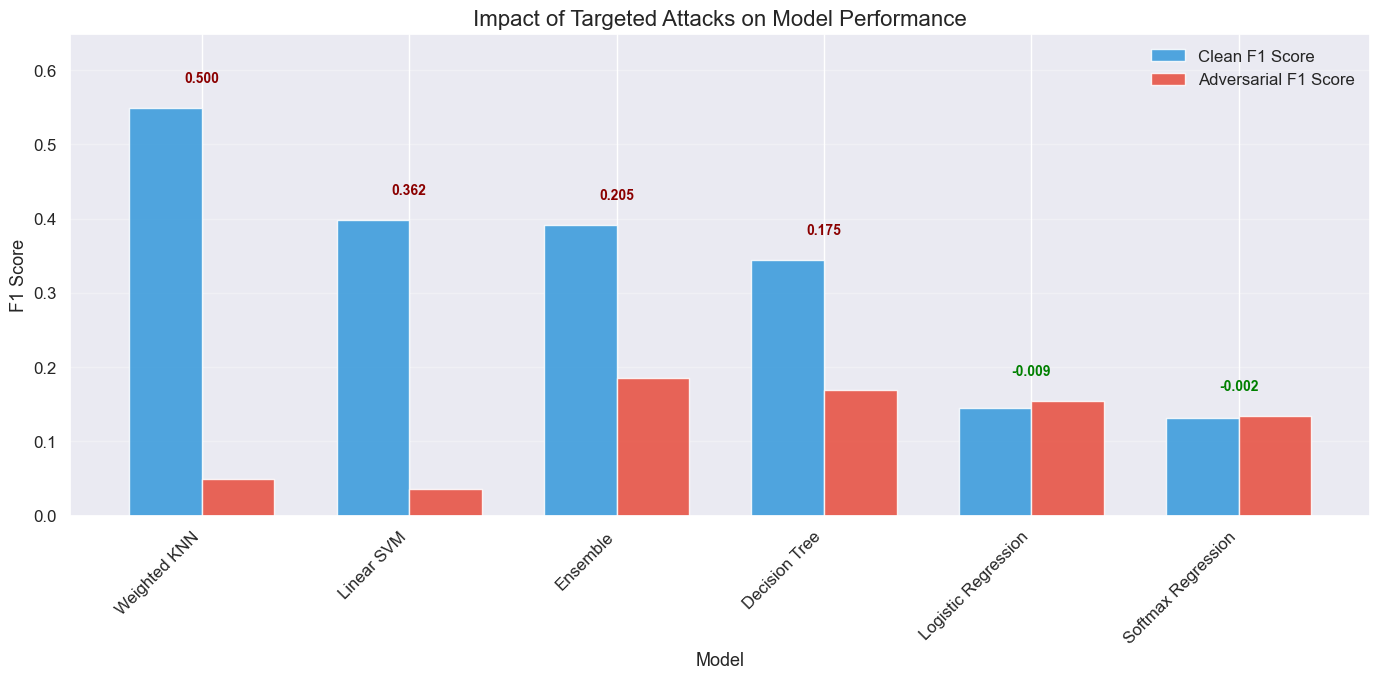

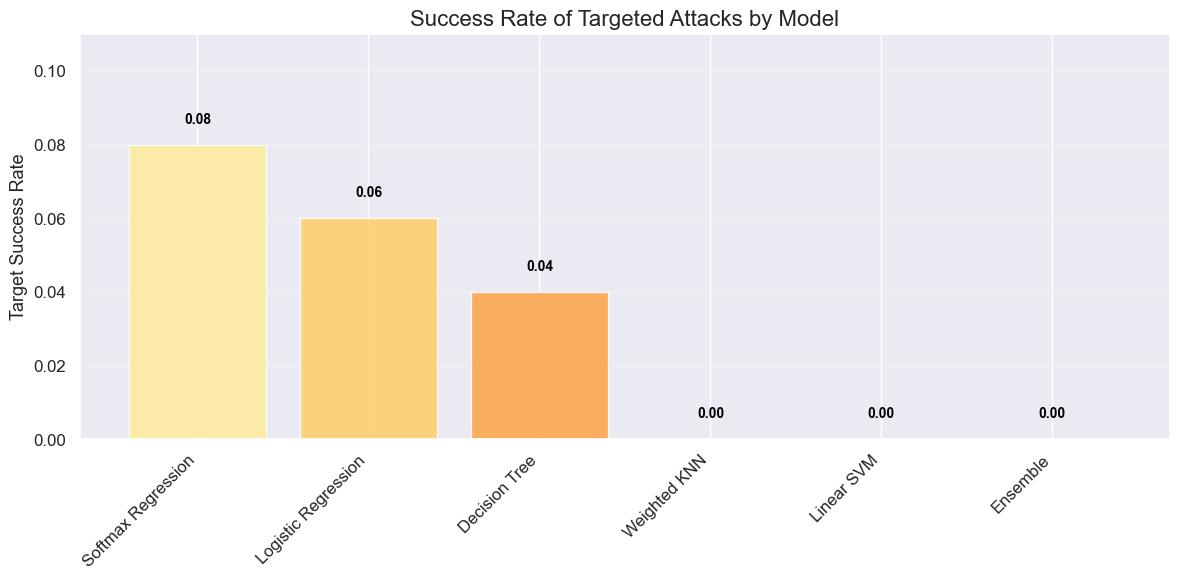

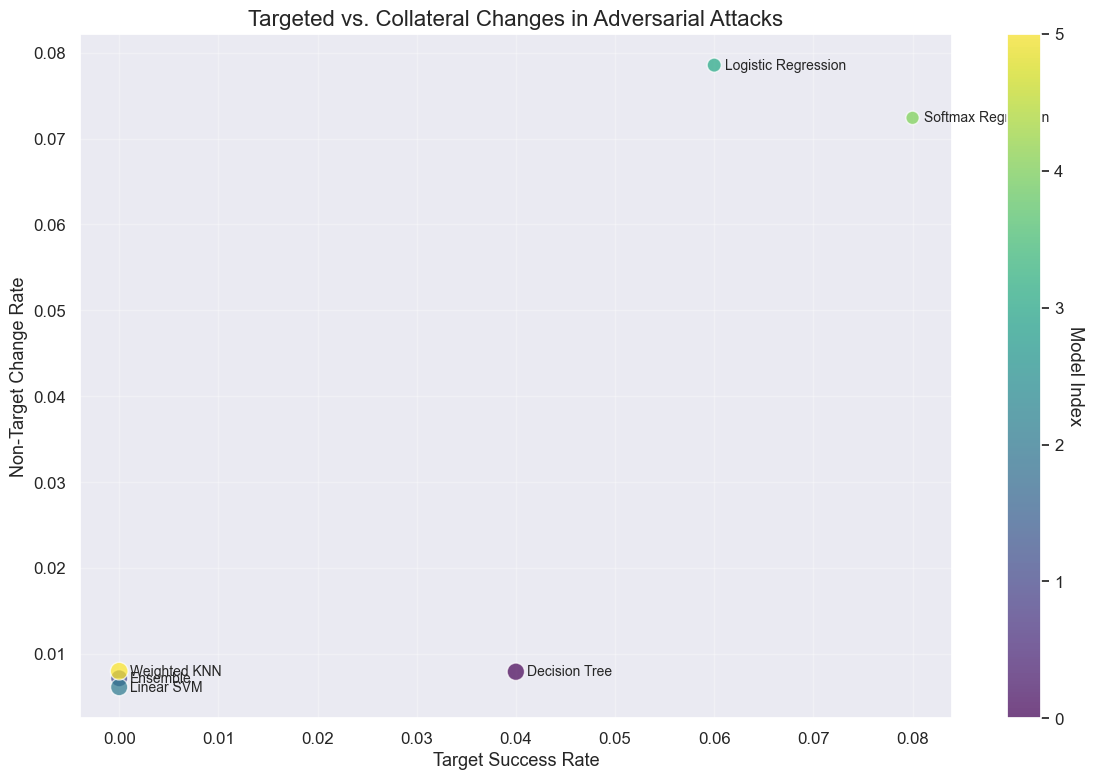

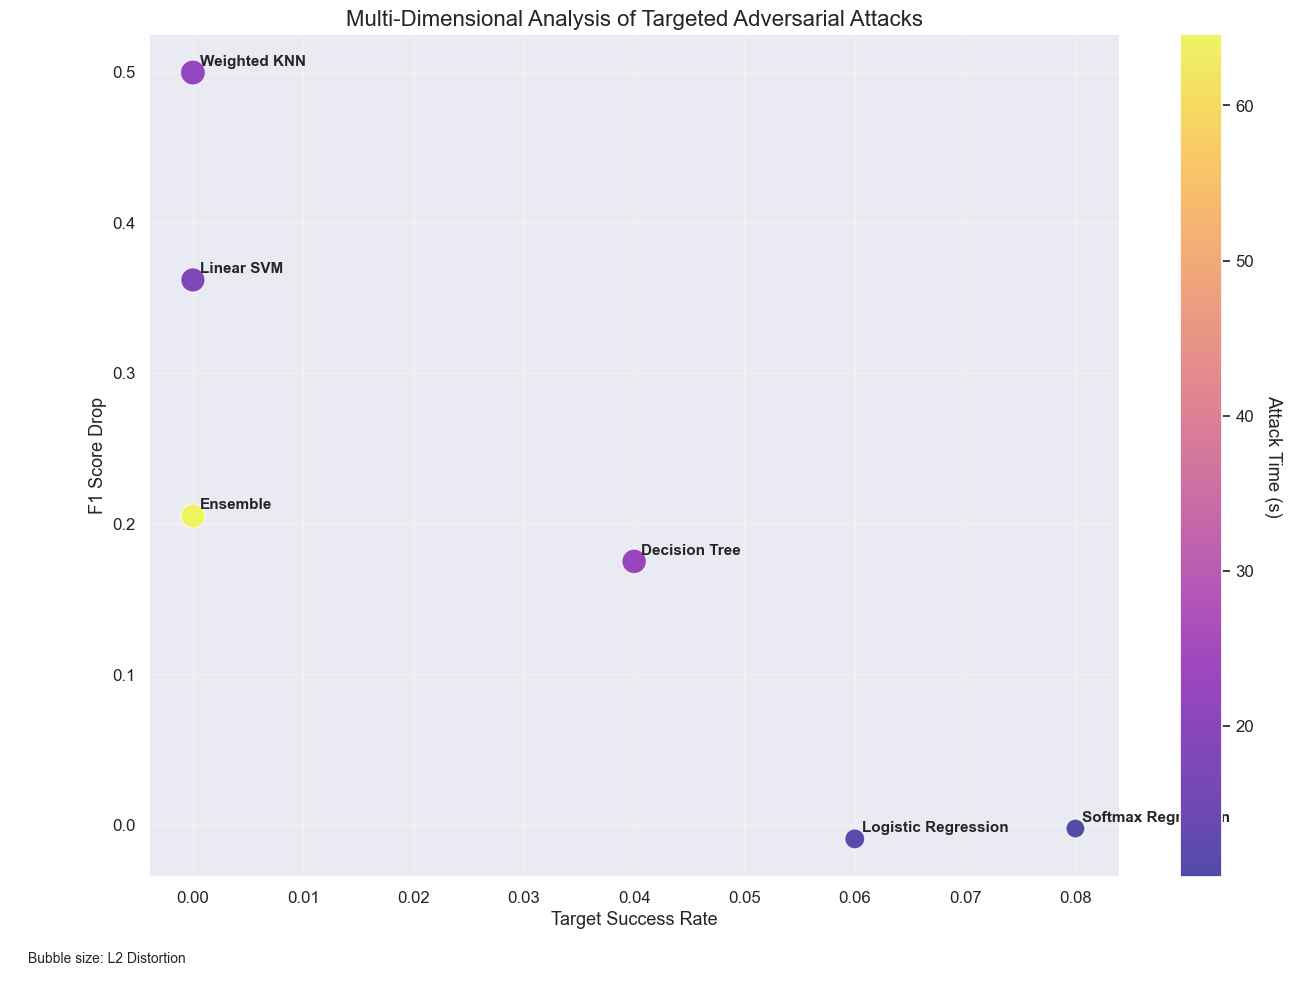

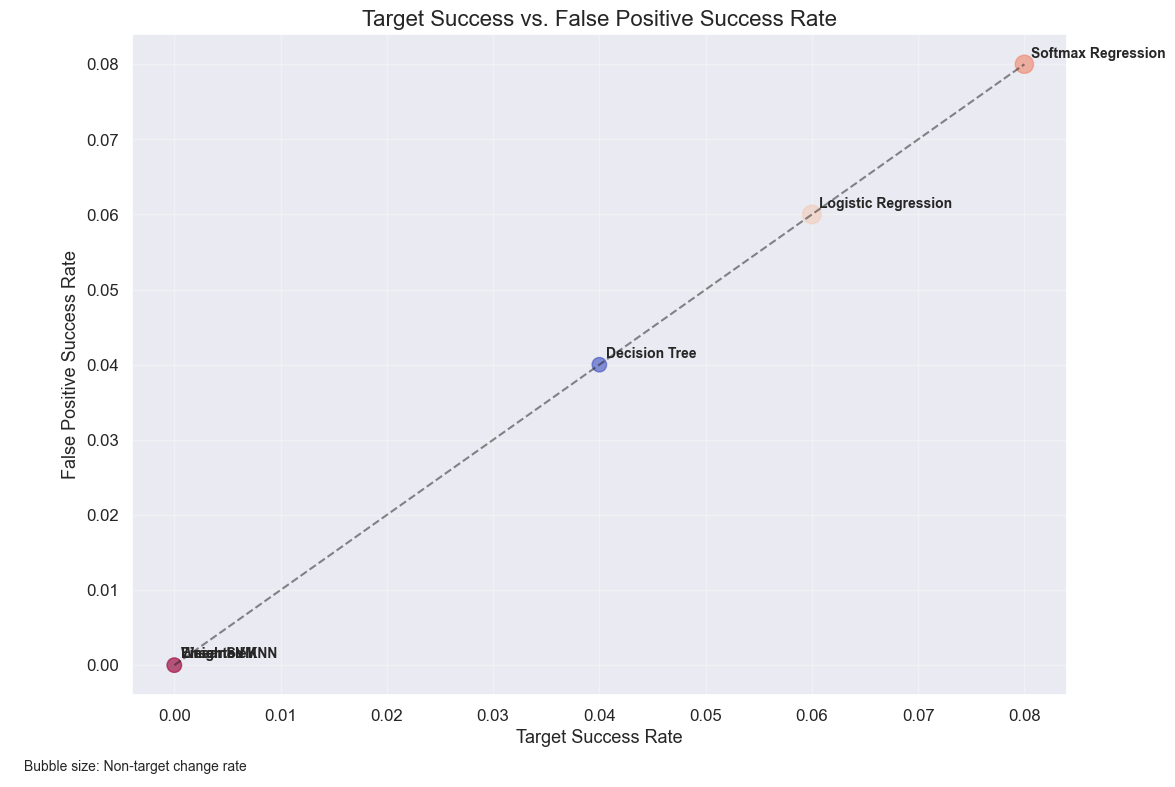

In [60]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.1)
colors = sns.color_palette("viridis", 6)

# Convert to DataFrame if it's not already
if not isinstance(summary_df, pd.DataFrame):
    summary_df = pd.DataFrame(summary_df)

# 1. F1 scores before and after attacks
plt.figure(figsize=(14, 7))
models = summary_df['model'].values
x = np.arange(len(models))
bar_width = 0.35

# Sort by clean F1 score
sorted_idx = summary_df['clean_f1'].argsort()[::-1]
sorted_df = summary_df.iloc[sorted_idx].reset_index(drop=True)

clean_f1 = sorted_df['clean_f1'].values
adv_f1 = sorted_df['adv_f1'].values
models = sorted_df['model'].values

# Create bars
plt.bar(x - bar_width/2, clean_f1, bar_width, label='Clean F1 Score', color='#3498db', alpha=0.85)
plt.bar(x + bar_width/2, adv_f1, bar_width, label='Adversarial F1 Score', color='#e74c3c', alpha=0.85)

# Add F1 drop annotations
for i in range(len(models)):
    drop = clean_f1[i] - adv_f1[i]
    color = 'darkred' if drop > 0.1 else ('red' if drop > 0 else 'green')
    plt.annotate(f"{drop:.3f}", 
                xy=(i, max(clean_f1[i], adv_f1[i]) + 0.03),
                ha='center', va='bottom', fontsize=10,
                color=color, fontweight='bold')

# Customize plot
plt.title('Impact of Targeted Attacks on Model Performance', fontsize=16)
plt.xlabel('Model', fontsize=13)
plt.ylabel('F1 Score', fontsize=13)
plt.xticks(x, models, rotation=45, ha='right')
plt.legend(loc='upper right')
plt.ylim(0, max(max(clean_f1), max(adv_f1)) + 0.1)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('targeted_attack_f1_impact.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Target success rate visualization
plt.figure(figsize=(12, 6))

# Sort by target success rate
sorted_idx = summary_df['target_success_rate'].argsort()[::-1]
sorted_df = summary_df.iloc[sorted_idx].reset_index(drop=True)

models = sorted_df['model'].values
success_rates = sorted_df['target_success_rate'].values

# Create bars with color gradient
plt.bar(models, success_rates, color=sns.color_palette("YlOrRd", len(models)), alpha=0.85)

# Add value labels
for i, rate in enumerate(success_rates):
    plt.annotate(f"{rate:.2f}", 
                xy=(i, rate + 0.005),
                ha='center', va='bottom', fontsize=10,
                color='black', fontweight='bold')

# Customize plot
plt.title('Success Rate of Targeted Attacks by Model', fontsize=16)
plt.ylabel('Target Success Rate', fontsize=13)
plt.ylim(0, max(success_rates) + 0.03)
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('targeted_attack_success_rate.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Multi-dimensional scatter plot (Target success vs. non-target changes)
plt.figure(figsize=(12, 8))

# Prepare data
models = summary_df['model'].values
target_success = summary_df['target_success_rate'].values
non_target_changes = summary_df['non_target_change_rate'].values
f1_drops = summary_df['clean_f1'].values - summary_df['adv_f1'].values
l2_dist = summary_df['l2_distortion'].values

# Create size values for markers based on L2 distortion
sizes = l2_dist * 5  # Scale for visibility

# Create scatter plot with varying colors by model
scatter = plt.scatter(target_success, non_target_changes, s=sizes, 
                     c=range(len(models)), cmap='viridis', 
                     alpha=0.7, edgecolors='white', linewidth=1)

# Add model labels
for i, model in enumerate(models):
    plt.annotate(model, (target_success[i], non_target_changes[i]),
                xytext=(8, 0), textcoords='offset points',
                ha='left', va='center', fontsize=10)

# Add colorbar legend
cbar = plt.colorbar(scatter)
cbar.set_label('Model Index', rotation=270, labelpad=15)
cbar.set_ticks(range(len(models)))
cbar.set_ticklabels(range(len(models)))

# Customize plot
plt.title('Targeted vs. Collateral Changes in Adversarial Attacks', fontsize=16)
plt.xlabel('Target Success Rate', fontsize=13)
plt.ylabel('Non-Target Change Rate', fontsize=13)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('targeted_vs_collateral.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Bubble chart with multiple metrics
plt.figure(figsize=(14, 10))

# Prepare data (normalize metrics for consistent comparison)
models = summary_df['model'].values
x = summary_df['target_success_rate'].values  
y = summary_df['clean_f1'].values - summary_df['adv_f1'].values  # F1 drop
sizes = summary_df['l2_distortion'].values * 10  # Bubble size
colors = summary_df['attack_time'].values  # Color by attack time

# Create bubble chart
scatter = plt.scatter(x, y, s=sizes, c=colors, cmap='plasma', 
                     alpha=0.7, edgecolors='white')

# Add model labels
for i, model in enumerate(models):
    plt.annotate(model, (x[i], y[i]),
               xytext=(5, 5), textcoords='offset points',
               fontsize=11, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Attack Time (s)', rotation=270, labelpad=20)

# Add size legend
plt.annotate('Bubble size: L2 Distortion', xy=(0.02, 0.02), 
           xycoords='figure fraction', fontsize=10)

# Customize plot
plt.title('Multi-Dimensional Analysis of Targeted Adversarial Attacks', fontsize=16)
plt.xlabel('Target Success Rate', fontsize=13)
plt.ylabel('F1 Score Drop', fontsize=13)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('targeted_attack_bubble.png', dpi=300, bbox_inches='tight')
plt.show()

# 6. Comparing targeted vs general metrics
plt.figure(figsize=(12, 8))

# Organize data
x = summary_df['target_success_rate'].values
y = summary_df['fp_success_rate'].values
sizes = summary_df['non_target_change_rate'].values * 1000 + 100  # Scale for visibility

# Create scatter plot
plt.scatter(x, y, s=sizes, alpha=0.6, c=range(len(models)), cmap='coolwarm')

# Draw diagonal line (y=x) to show when target and FP rates are equal
plt.plot([0, max(max(x), max(y))], [0, max(max(x), max(y))], 'k--', alpha=0.5)

# Add annotations
for i, model in enumerate(models):
    plt.annotate(model, (x[i], y[i]),
               xytext=(5, 5), textcoords='offset points',
               fontsize=10, fontweight='bold')

# Add size legend
plt.annotate('Bubble size: Non-target change rate', xy=(0.02, 0.02), 
           xycoords='figure fraction', fontsize=10)

# Customize plot
plt.title('Target Success vs. False Positive Success Rate', fontsize=16)
plt.xlabel('Target Success Rate', fontsize=13)
plt.ylabel('False Positive Success Rate', fontsize=13)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('target_vs_fp_success.png', dpi=300, bbox_inches='tight')
plt.show()

### Untargetted Attack

In [61]:
def any_label_flip_attack(model, x, y, epsilon=0.2, iterations=20):
    """
    Untargeted attack that attempts to flip any labels in multilabel classification.
    
    Parameters:
    -----------
    model : trained model
        Target model to attack
    x : array-like
        Original input example (single instance)
    y : array-like
        Original labels (multilabel format)
    epsilon : float
        Maximum perturbation size
    iterations : int
        Number of iterations to try different perturbations
        
    Returns:
    --------
    x_adv : array-like
        Adversarial example
    """
    x_adv = x.copy()
    
    # Get original prediction
    original_pred = model.predict(x.reshape(1, -1))[0]
    
    # Keep track of best perturbation
    best_x_adv = x.copy()
    max_flipped = 0
    
    # Try different random perturbations
    for _ in range(iterations):
        # Generate random perturbation
        delta = np.random.uniform(-epsilon, epsilon, size=x.shape)
        
        # Apply perturbation
        x_perturbed = x + delta
        
        # Clip to valid range
        x_perturbed = np.clip(x_perturbed, 0, 1)
        
        # Check new prediction
        new_pred = model.predict(x_perturbed.reshape(1, -1))[0]
        
        # Count flipped labels
        flipped_count = np.sum(new_pred != original_pred)
        
        # Update if better
        if flipped_count > max_flipped:
            max_flipped = flipped_count
            best_x_adv = x_perturbed.copy()
    
    return best_x_adv

In [63]:
def generate_untargeted_adversarial_examples(model, X, y, attack_type='label_flip', 
                                           epsilon=0.2, sample_size=None, progress=True):
    """
    Generate adversarial examples using untargeted attacks.
    
    Parameters:
    -----------
    model : classifier object
        Trained model with predict method
    X : numpy.ndarray
        Input features
    y : numpy.ndarray
        True labels (multilabel format)
    attack_type : str, default='label_flip'
        Type of untargeted attack ('label_flip', 'max_error', 'confidence')
    epsilon : float, default=0.2
        Maximum perturbation size
    sample_size : int, optional
        Number of samples to attack (if None, attack all)
    progress : bool, default=True
        Whether to show progress bar
        
    Returns:
    --------
    tuple
        (X_adv, indices) - Adversarial examples and their indices
    """
    if sample_size is None:
        sample_size = X.shape[0]
    else:
        sample_size = min(sample_size, X.shape[0])
    
    # Randomly select samples
    indices = np.random.choice(X.shape[0], sample_size, replace=False)
    X_selected = X[indices]
    y_selected = y[indices]
    
    X_adv = np.zeros_like(X_selected)
    
    iterator = tqdm(range(sample_size)) if progress else range(sample_size)
    for i in iterator:
        # Select attack function
        if attack_type.lower() == 'label_flip':
            X_adv[i] = any_label_flip_attack(model, X_selected[i], y_selected[i], epsilon)
        
    return X_adv, indices

In [64]:
def evaluate_untargeted_adversarial_examples(model, X_clean, X_adv, y_true, model_name, attack_name):
    """
    Evaluate untargeted adversarial examples with specific metrics for multilabel classification.
    
    Parameters:
    -----------
    model : classifier object
        Model to evaluate
    X_clean : numpy.ndarray
        Original test examples
    X_adv : numpy.ndarray
        Adversarial examples
    y_true : numpy.ndarray
        True labels
    model_name : str
        Name of the model
    attack_name : str
        Name of the attack
        
    Returns:
    --------
    dict
        Dictionary containing evaluation metrics
    """
    # Predict on clean examples
    y_pred_clean = model.predict(X_clean)
    
    # Predict on adversarial examples
    y_pred_adv = model.predict(X_adv)
    
    # Calculate standard metrics
    clean_metrics = {
        'accuracy': accuracy_score(y_true, y_pred_clean),
        'precision_micro': precision_score(y_true, y_pred_clean, average='micro'),
        'recall_micro': recall_score(y_true, y_pred_clean, average='micro'),
        'f1_micro': f1_score(y_true, y_pred_clean, average='micro'),
        'hamming_loss': hamming_loss(y_true, y_pred_clean)
    }
    
    adv_metrics = {
        'accuracy': accuracy_score(y_true, y_pred_adv),
        'precision_micro': precision_score(y_true, y_pred_adv, average='micro'),
        'recall_micro': recall_score(y_true, y_pred_adv, average='micro'),
        'f1_micro': f1_score(y_true, y_pred_adv, average='micro'),
        'hamming_loss': hamming_loss(y_true, y_pred_adv)
    }
    
    # Calculate untargeted attack specific metrics
    
    # 1. Label flip rate - percentage of predictions that changed
    label_flip_rate = np.mean(y_pred_clean != y_pred_adv)
    
    # 2. Error increase - how much the error increased due to the attack
    clean_errors = np.sum(y_pred_clean != y_true)
    adv_errors = np.sum(y_pred_adv != y_true)
    error_increase_rate = (adv_errors - clean_errors) / max(clean_errors, 1)
    
    # 3. Hamming distance - between clean and adversarial predictions
    hamming_distance = np.mean(np.sum(y_pred_clean != y_pred_adv, axis=1))
    
    # 4. False positive and false negative increases
    clean_fp = np.sum((y_pred_clean == 1) & (y_true == 0))
    adv_fp = np.sum((y_pred_adv == 1) & (y_true == 0))
    fp_increase = adv_fp - clean_fp
    
    clean_fn = np.sum((y_pred_clean == 0) & (y_true == 1))
    adv_fn = np.sum((y_pred_adv == 0) & (y_true == 1))
    fn_increase = adv_fn - clean_fn
    
    # 5. L2 distortion
    l2_distortion = np.mean(np.sqrt(np.sum((X_adv - X_clean)**2, axis=1)))
    
    # Compile results
    results = {
        'model': model_name,
        'attack': attack_name,
        'clean_accuracy': clean_metrics['accuracy'],
        'clean_f1': clean_metrics['f1_micro'],
        'clean_hamming_loss': clean_metrics['hamming_loss'],
        'adv_accuracy': adv_metrics['accuracy'],
        'adv_f1': adv_metrics['f1_micro'],
        'adv_hamming_loss': adv_metrics['hamming_loss'],
        'f1_drop': clean_metrics['f1_micro'] - adv_metrics['f1_micro'],
        'error_increase_rate': error_increase_rate,
        'label_flip_rate': label_flip_rate,
        'hamming_distance': hamming_distance,
        'fp_increase': fp_increase,
        'fn_increase': fn_increase,
        'l2_distortion': l2_distortion
    }
    
    return results

In [65]:
# Create an ensemble model if not already created
if 'ensemble_model' not in globals():
    models_for_ensemble = {name: model for name, model in trained_models.items() 
                          if name != 'Weighted KNN'}
    ensemble_model = EnsembleModel(models_for_ensemble)
    
    # Add the ensemble to our models
    all_models = trained_models.copy()
    all_models['Ensemble'] = ensemble_model

# Define attack parameters
sample_size = 50  # Use a smaller subset for demonstration
epsilons = [0.2]  # Keep epsilon consistent with previous attacks
attack_types = ['label_flip']

# Create results storage
untargeted_results = []

# Run attacks on all models
print("\n" + "="*70)
print("RUNNING UNTARGETED ADVERSARIAL ATTACKS ON ALL MODELS")
print("="*70)

for model_name, model in all_models.items():
    print(f"\n{'='*50}")
    print(f"Untargeted attacking {model_name}...")
    print(f"{'='*50}")
    
    # Select appropriate features based on model
    if model_name != 'Weighted KNN':
        features = X_test_scaled
    else:
        features = X_test_reduced
    
    # Run attacks with different types
    for attack_type in attack_types:
        for epsilon in epsilons:
            print(f"\nRunning {attack_type.upper()} attack with ε={epsilon} on {model_name}...")
            
            try:
                # Generate adversarial examples
                start_time = time.time()
                X_adv, indices = generate_untargeted_adversarial_examples(
                    model, features, test_labels, 
                    attack_type=attack_type, 
                    epsilon=epsilon, 
                    sample_size=sample_size
                )
                attack_time = time.time() - start_time
                
                # Evaluate attack
                results = evaluate_untargeted_adversarial_examples(
                    model, features[indices], X_adv, test_labels[indices], 
                    model_name, f"{attack_type.upper()}-ε{epsilon}"
                )
                
                # Add timing information
                results['attack_time'] = attack_time
                results['epsilon'] = epsilon
                results['attack_type'] = attack_type
                
                # Print results
                print(f"  Clean F1: {results['clean_f1']:.4f}")
                print(f"  Adversarial F1: {results['adv_f1']:.4f}")
                print(f"  F1 Drop: {results['f1_drop']:.4f}")
                print(f"  Label Flip Rate: {results['label_flip_rate']:.4f}")
                print(f"  Hamming Distance: {results['hamming_distance']:.4f}")
                print(f"  Attack Time: {attack_time:.2f}s")
                
                untargeted_results.append(results)
                
            except Exception as e:
                print(f"  Attack failed: {str(e)}")

# Convert results to DataFrame
untargeted_df = pd.DataFrame(untargeted_results)

# Save full results to CSV
untargeted_df.to_csv("untargeted_attack_results.csv", index=False)

# Create a summary table
summary_columns = ['model', 'attack', 'attack_type', 'clean_f1', 'adv_f1', 'f1_drop', 
                  'label_flip_rate', 'hamming_distance', 'error_increase_rate', 
                  'l2_distortion', 'attack_time']
                  
summary_df = untargeted_df[summary_columns].sort_values(
    by=['model', 'f1_drop'], 
    ascending=[True, False]
)

print("\nUntargeted Attack Summary:")
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)
print(summary_df)


RUNNING UNTARGETED ADVERSARIAL ATTACKS ON ALL MODELS

Untargeted attacking Linear SVM...

Running LABEL_FLIP attack with ε=0.2 on Linear SVM...


  0%|          | 0/50 [00:00<?, ?it/s]

  Clean F1: 0.3881
  Adversarial F1: 0.0000
  F1 Drop: 0.3881
  Label Flip Rate: 0.0068
  Hamming Distance: 1.9800
  Attack Time: 18.05s

Untargeted attacking Logistic Regression...

Running LABEL_FLIP attack with ε=0.2 on Logistic Regression...


  0%|          | 0/50 [00:00<?, ?it/s]

  Clean F1: 0.1340
  Adversarial F1: 0.1311
  F1 Drop: 0.0028
  Label Flip Rate: 0.1693
  Hamming Distance: 49.2800
  Attack Time: 17.32s

Untargeted attacking Softmax Regression...

Running LABEL_FLIP attack with ε=0.2 on Softmax Regression...


  0%|          | 0/50 [00:00<?, ?it/s]

  Clean F1: 0.1202
  Adversarial F1: 0.1278
  F1 Drop: -0.0075
  Label Flip Rate: 0.1509
  Hamming Distance: 43.9200
  Attack Time: 16.08s

Untargeted attacking Decision Tree...

Running LABEL_FLIP attack with ε=0.2 on Decision Tree...


  0%|          | 0/50 [00:00<?, ?it/s]

  Clean F1: 0.3654
  Adversarial F1: 0.1212
  F1 Drop: 0.2442
  Label Flip Rate: 0.0096
  Hamming Distance: 2.8000
  Attack Time: 21.55s

Untargeted attacking Weighted KNN...

Running LABEL_FLIP attack with ε=0.2 on Weighted KNN...


  0%|          | 0/50 [00:00<?, ?it/s]

  Clean F1: 0.5187
  Adversarial F1: 0.0000
  F1 Drop: 0.5187
  Label Flip Rate: 0.0086
  Hamming Distance: 2.5000
  Attack Time: 20.67s

Untargeted attacking Ensemble...

Running LABEL_FLIP attack with ε=0.2 on Ensemble...


  0%|          | 0/50 [00:00<?, ?it/s]

  Clean F1: 0.3868
  Adversarial F1: 0.0900
  F1 Drop: 0.2968
  Label Flip Rate: 0.0093
  Hamming Distance: 2.7200
  Attack Time: 61.80s

Untargeted Attack Summary:
                 model           attack attack_type  clean_f1    adv_f1   f1_drop  label_flip_rate  hamming_distance  error_increase_rate  l2_distortion  attack_time
3        Decision Tree  LABEL_FLIP-ε0.2  label_flip  0.365385  0.121212  0.244172         0.009622              2.80             0.098485      30.134899    21.554442
5             Ensemble  LABEL_FLIP-ε0.2  label_flip  0.386768  0.089965  0.296803         0.009347              2.72             0.091286      32.929799    61.801665
0           Linear SVM  LABEL_FLIP-ε0.2  label_flip  0.388060  0.000000  0.388060         0.006804              1.98             0.231707      27.343822    18.049524
1  Logistic Regression  LABEL_FLIP-ε0.2  label_flip  0.133990  0.131148  0.002842         0.169347             49.28            -0.380802      32.709178    17.316845
2   S

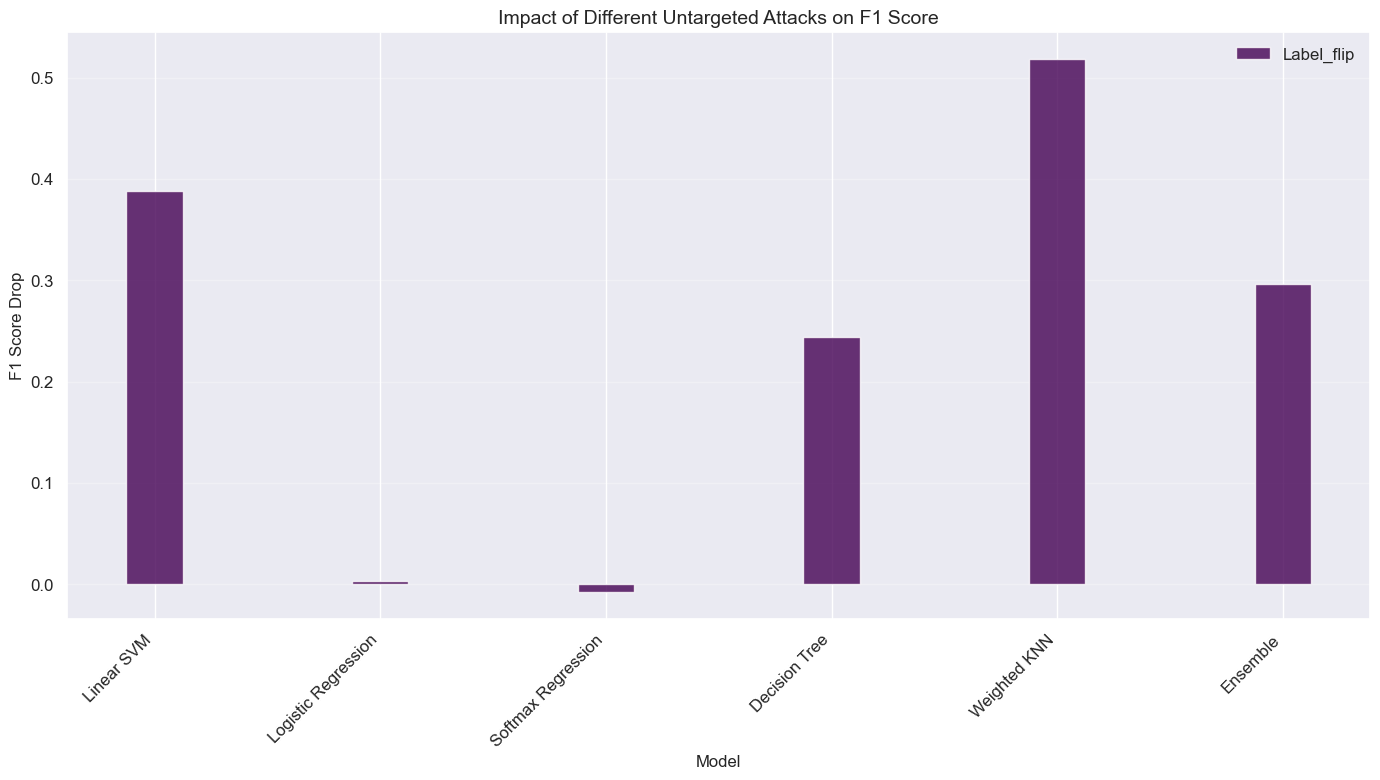

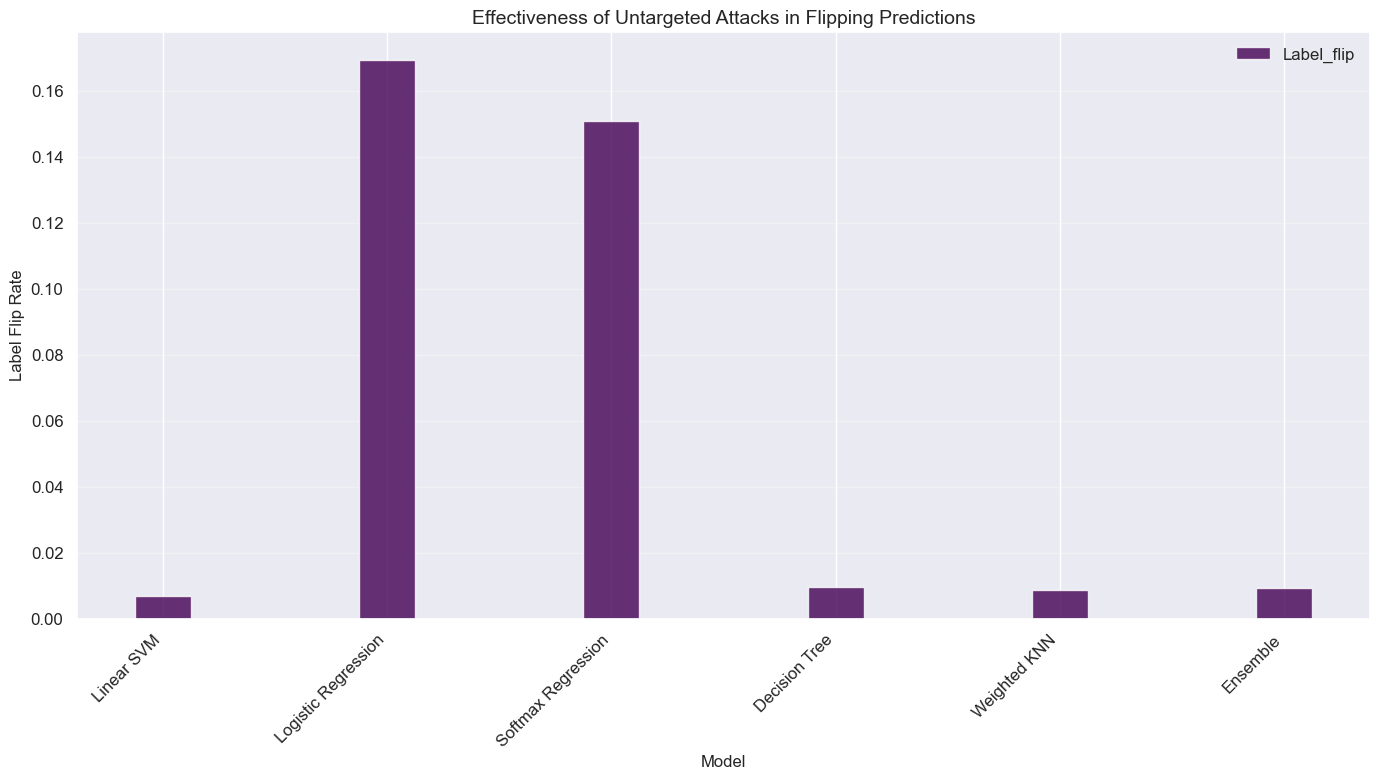

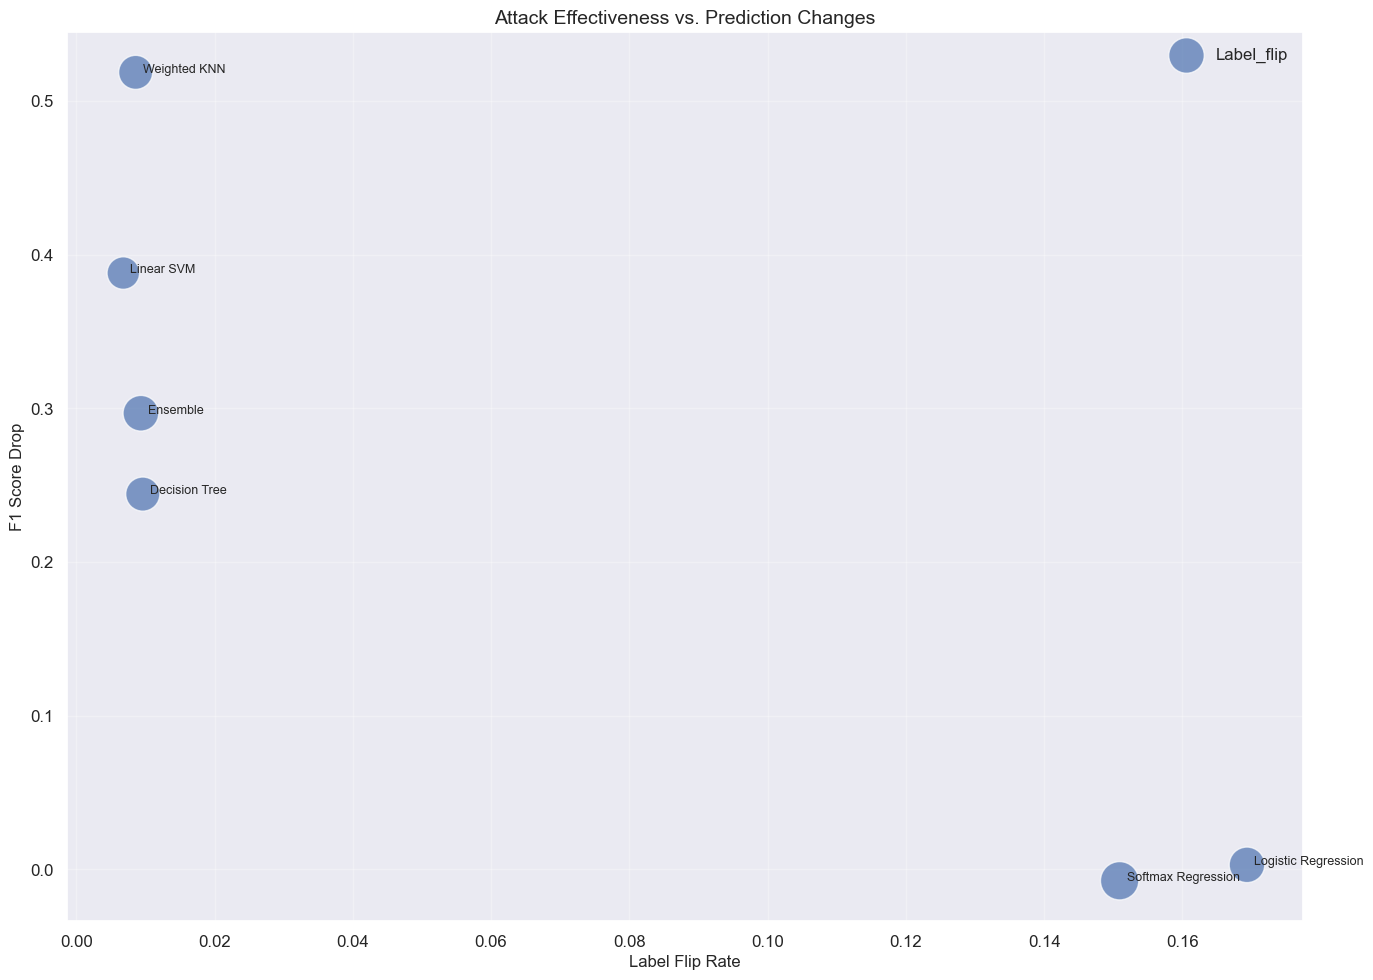

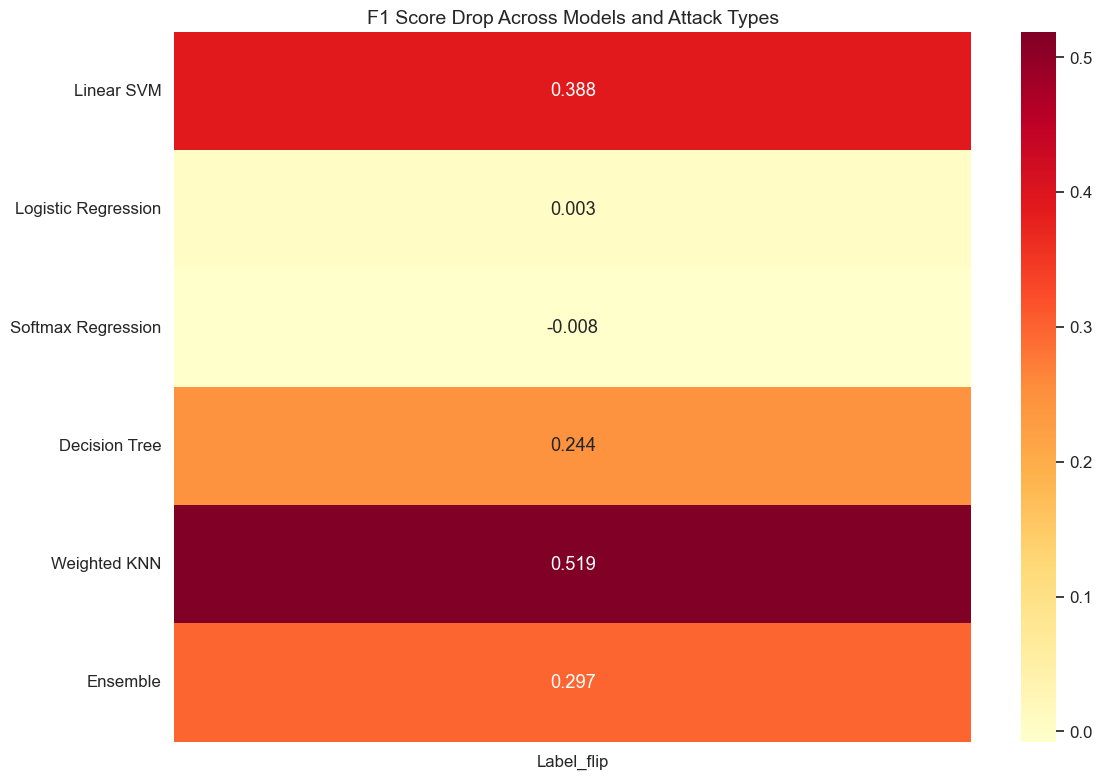

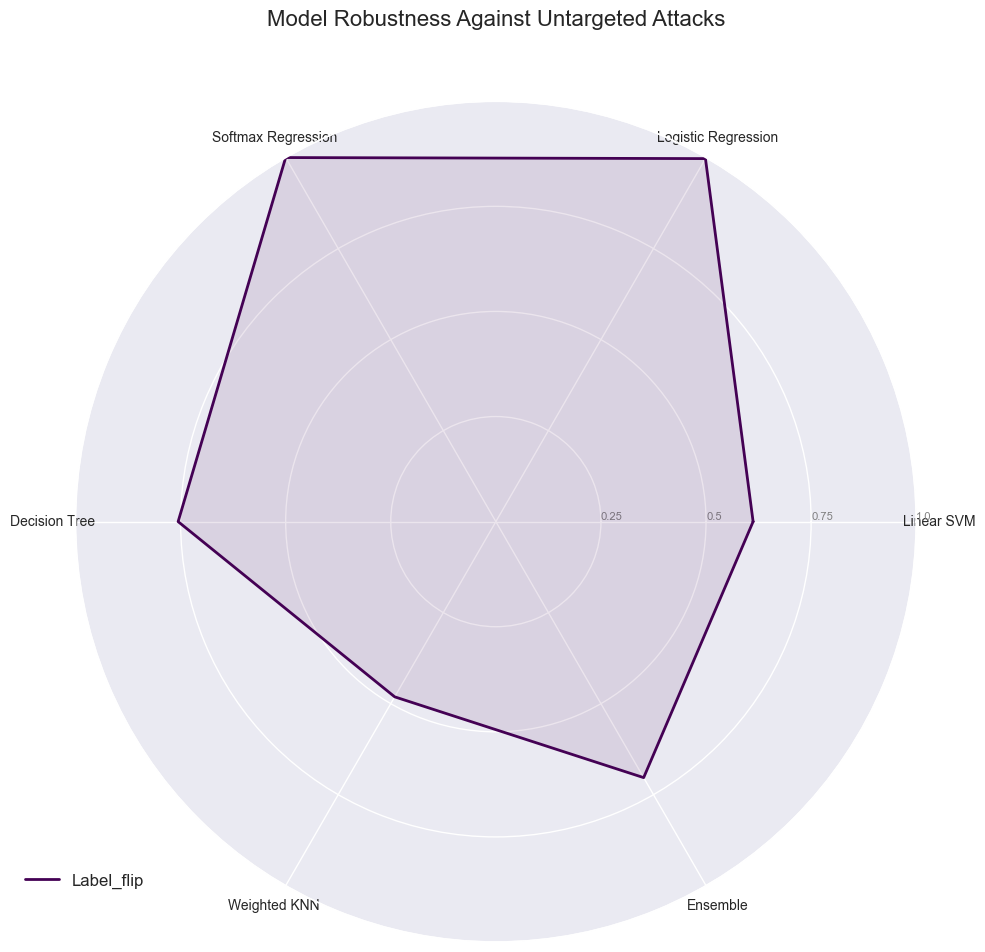

In [66]:
# Set visual style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.1)

# 1. F1 drop comparison across attack types
plt.figure(figsize=(14, 8))

# Group by model and attack type
models = untargeted_df['model'].unique()
attack_types = untargeted_df['attack_type'].unique()

# Set up the plot
x = np.arange(len(models))
width = 0.25
colors = plt.cm.viridis(np.linspace(0, 1, len(attack_types)))

# Create grouped bar chart for F1 drops
for i, attack_type in enumerate(attack_types):
    f1_drops = []
    for model in models:
        model_data = untargeted_df[(untargeted_df['model'] == model) & 
                                  (untargeted_df['attack_type'] == attack_type)]
        if not model_data.empty:
            f1_drops.append(model_data['f1_drop'].values[0])
        else:
            f1_drops.append(0)
    
    plt.bar(x + (i - len(attack_types)/2 + 0.5) * width, f1_drops, width, 
            label=attack_type.capitalize(), color=colors[i], alpha=0.8)

plt.xlabel('Model', fontsize=12)
plt.ylabel('F1 Score Drop', fontsize=12)
plt.title('Impact of Different Untargeted Attacks on F1 Score', fontsize=14)
plt.xticks(x, models, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('untargeted_f1_drop_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Label flip rates across models and attacks
plt.figure(figsize=(14, 8))

for i, attack_type in enumerate(attack_types):
    flip_rates = []
    for model in models:
        model_data = untargeted_df[(untargeted_df['model'] == model) & 
                                  (untargeted_df['attack_type'] == attack_type)]
        if not model_data.empty:
            flip_rates.append(model_data['label_flip_rate'].values[0])
        else:
            flip_rates.append(0)
    
    plt.bar(x + (i - len(attack_types)/2 + 0.5) * width, flip_rates, width, 
            label=attack_type.capitalize(), color=colors[i], alpha=0.8)

plt.xlabel('Model', fontsize=12)
plt.ylabel('Label Flip Rate', fontsize=12)
plt.title('Effectiveness of Untargeted Attacks in Flipping Predictions', fontsize=14)
plt.xticks(x, models, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('untargeted_flip_rates.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Bubble chart comparing multiple metrics
plt.figure(figsize=(14, 10))

# Create plot for each attack type
for attack_type in attack_types:
    attack_data = untargeted_df[untargeted_df['attack_type'] == attack_type]
    
    if attack_data.empty:
        continue
    
    # Prepare data
    x = attack_data['label_flip_rate'].values
    y = attack_data['f1_drop'].values
    sizes = attack_data['l2_distortion'].values * 20  # Scale for visibility
    models_list = attack_data['model'].values
    
    # Plot bubbles
    plt.scatter(x, y, s=sizes, alpha=0.7, 
              label=attack_type.capitalize(),
              edgecolors='white', linewidth=1)
    
    # Add model names as annotations
    for i, model in enumerate(models_list):
        plt.annotate(model, (x[i], y[i]), 
                    xytext=(5, 0), textcoords='offset points',
                    fontsize=9)

plt.xlabel('Label Flip Rate', fontsize=12)
plt.ylabel('F1 Score Drop', fontsize=12)
plt.title('Attack Effectiveness vs. Prediction Changes', fontsize=14)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('untargeted_bubble_chart.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Heatmap of attack effectiveness across models
plt.figure(figsize=(12, 8))

# Prepare data for heatmap
heatmap_data = []
for model in models:
    model_row = []
    for attack_type in attack_types:
        model_attack_data = untargeted_df[(untargeted_df['model'] == model) & 
                                        (untargeted_df['attack_type'] == attack_type)]
        if not model_attack_data.empty:
            model_row.append(model_attack_data['f1_drop'].values[0])
        else:
            model_row.append(0)
    heatmap_data.append(model_row)

# Create heatmap
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlOrRd',
           xticklabels=[at.capitalize() for at in attack_types],
           yticklabels=models)

plt.title('F1 Score Drop Across Models and Attack Types', fontsize=14)
plt.tight_layout()
plt.savefig('untargeted_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Radar chart of model robustness
from math import pi

# Prepare radar chart data - use the model as the "categories" and 
# different attacks as the "variables" with 1-F1 drop as the value (higher means more robust)
categories = models
attacks = [at.capitalize() for at in attack_types]

# Calculate robustness scores (1 - F1 drop, higher is better)
values = []
for attack_type in attack_types:
    attack_values = []
    for model in models:
        model_attack_data = untargeted_df[(untargeted_df['model'] == model) & 
                                        (untargeted_df['attack_type'] == attack_type)]
        if not model_attack_data.empty:
            # Convert F1 drop to robustness score (normalize to 0-1)
            # Clip negative drops to 0 (improvements shouldn't count as vulnerability)
            drop = max(0, model_attack_data['f1_drop'].values[0])
            # Cap at 1 to avoid extreme values
            drop = min(drop, 1)
            robustness = 1 - drop
        else:
            robustness = 1  # Assume robust if no data
        attack_values.append(robustness)
    values.append(attack_values)

# Create radar chart
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Number of categories
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Close the loop

# Plot each attack type
for i, (attack, attack_values) in enumerate(zip(attacks, values)):
    values_for_plot = attack_values + [attack_values[0]]  # Close the loop
    ax.plot(angles, values_for_plot, linewidth=2, label=attack, color=colors[i])
    ax.fill(angles, values_for_plot, color=colors[i], alpha=0.1)

# Set chart properties
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=10)
ax.set_yticks([0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(["0.25", "0.5", "0.75", "1.0"], color="grey", size=8)
ax.set_rlabel_position(0)
plt.ylim(0, 1)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('Model Robustness Against Untargeted Attacks', fontsize=16, y=1.08)
plt.tight_layout()
plt.savefig('untargeted_radar_chart.png', dpi=300, bbox_inches='tight')
plt.show()

### Sample specific attack

In [70]:
def sample_specific_attack(model, x, y, epsilon=0.2, iterations=15, step_size=0.05):
    """
    Optimized sample-specific perturbation attack with early stopping and adaptive search.
    
    Parameters:
    -----------
    model : trained model
        Target model to attack
    x : array-like
        Original input example (single instance)
    y : array-like
        Original labels (multilabel format)
    epsilon : float
        Maximum perturbation magnitude
    iterations : int
        Maximum number of optimization iterations
    step_size : float
        Initial step size for perturbation
        
    Returns:
    --------
    x_adv : array-like
        Adversarial example
    """
    # Get original prediction
    original_pred = model.predict(x.reshape(1, -1))[0]
    
    # Start with a random perturbation to avoid local minima
    best_delta = np.random.normal(0, epsilon/3, size=x.shape)
    best_delta = epsilon * best_delta / (np.linalg.norm(best_delta) + 1e-8)
    best_adv = np.clip(x + best_delta, 0, 1)
    
    # Get prediction for initial perturbation
    best_pred = model.predict(best_adv.reshape(1, -1))[0]
    best_score = np.sum(best_pred != original_pred)
    
    # Early stopping if we already found a successful attack
    if best_score > 0:
        return best_adv
    
    # Key optimization: Precompute feature importance by checking correlation with labels
    # This helps us focus on features most likely to affect predictions
    n_features = min(100, x.shape[0])  # Limit feature count for efficiency
    feature_indices = np.random.choice(x.shape[0], n_features, replace=False)
    
    # Use coordinates with higher variance first (more likely to impact decision)
    feature_indices = sorted(feature_indices, key=lambda idx: abs(x[idx] - 0.5), reverse=True)
    
    # Mini-batch approach: process features in small batches
    batch_size = 10
    
    # Track improvement for dynamic step size
    last_improvement = 0
    
    # Main optimization loop
    for i in range(iterations):
        # Reduce step size over time for better convergence
        current_step = step_size * (1.0 - i/iterations)
        improved = False
        
        # Process features in batches
        for start_idx in range(0, len(feature_indices), batch_size):
            end_idx = min(start_idx + batch_size, len(feature_indices))
            batch_indices = feature_indices[start_idx:end_idx]
            
            # Create a batch of candidate perturbations
            candidates = []
            for idx in batch_indices:
                # Try both positive and negative perturbations
                for direction in [1, -1]:
                    delta = best_delta.copy()
                    delta[idx] += direction * current_step * epsilon
                    
                    # Project to epsilon ball
                    norm = np.linalg.norm(delta)
                    if norm > epsilon:
                        delta = delta * epsilon / norm
                        
                    candidate = np.clip(x + delta, 0, 1)
                    candidates.append((candidate, delta))
            
            # Batch prediction to reduce overhead
            batch_x = np.array([c[0] for c in candidates])
            batch_preds = model.predict(batch_x)
            
            # Evaluate each candidate
            for j, pred in enumerate(batch_preds):
                candidate, delta = candidates[j]
                score = np.sum(pred != original_pred)
                
                if score > best_score:
                    best_score = score
                    best_delta = delta.copy()
                    best_adv = candidate.copy()
                    improved = True
                    last_improvement = i
        
        # Early stopping if we've found a good adversarial example
        if best_score > 0:
            # Try to refine it by reducing the perturbation magnitude
            refinement_steps = 5
            for _ in range(refinement_steps):
                scaled_delta = best_delta * 0.8  # Try a smaller perturbation
                candidate = np.clip(x + scaled_delta, 0, 1)
                pred = model.predict(candidate.reshape(1, -1))[0]
                if np.any(pred != original_pred):
                    best_delta = scaled_delta
                    best_adv = candidate
                else:
                    break
            return best_adv
            
        # If no improvement for several iterations, try larger step size
        if not improved:
            if i - last_improvement > 3:
                current_step *= 2.0  # Double step size
            
            # If still no improvement, try a new random direction
            if i - last_improvement > 5:
                random_delta = np.random.normal(0, 1, size=x.shape)
                random_delta = random_delta / (np.linalg.norm(random_delta) + 1e-8)
                best_delta = best_delta * 0.5 + random_delta * epsilon * 0.5
    
    return best_adv

In [68]:
def generate_sample_specific_examples(model, X, y, epsilon=0.2, sample_size=None, progress=True):
    """
    Generate adversarial examples using sample-specific perturbations.
    
    Parameters:
    -----------
    model : classifier object
        Trained model with predict method
    X : numpy.ndarray
        Input features
    y : numpy.ndarray
        True labels
    epsilon : float
        Maximum perturbation size
    sample_size : int, optional
        Number of samples to attack (if None, attack all)
    progress : bool
        Whether to show progress bar
        
    Returns:
    --------
    tuple
        (X_adv, indices) - Adversarial examples and their indices
    """
    if sample_size is None:
        sample_size = X.shape[0]
    else:
        sample_size = min(sample_size, X.shape[0])
    
    # Randomly select samples
    indices = np.random.choice(X.shape[0], sample_size, replace=False)
    X_selected = X[indices]
    y_selected = y[indices]
    
    X_adv = np.zeros_like(X_selected)
    
    iterator = tqdm(range(sample_size)) if progress else range(sample_size)
    for i in iterator:
        X_adv[i] = sample_specific_attack(model, X_selected[i], y_selected[i], epsilon)
    
    return X_adv, indices

In [71]:
if 'ensemble_model' not in globals():
    models_for_ensemble = {name: model for name, model in trained_models.items() 
                          if name != 'Weighted KNN'}
    ensemble_model = EnsembleModel(models_for_ensemble)
    
    # Add the ensemble to our models
    all_models = trained_models.copy()
    all_models['Ensemble'] = ensemble_model

# Define attack parameters
sample_size = 50  # Use a smaller subset for demonstration
epsilons = [0.2]  # Keep epsilon consistent with previous attacks
attack_name = 'SAMPLE_SPECIFIC'

# Create results storage
specific_results = []

# Run attacks on all models
print("\n" + "="*70)
print("RUNNING SAMPLE-SPECIFIC ADVERSARIAL ATTACKS ON ALL MODELS")
print("="*70)

for model_name, model in all_models.items():
    print(f"\n{'='*50}")
    print(f"Attacking {model_name} with sample-specific perturbations...")
    print(f"{'='*50}")
    
    # Select appropriate features based on model
    if model_name != 'Weighted KNN':
        features = X_test_scaled
    else:
        features = X_test_reduced
    
    # Run attacks with different epsilon values
    for epsilon in epsilons:
        print(f"\nRunning sample-specific attack with ε={epsilon} on {model_name}...")
        
        try:
            # Generate adversarial examples
            start_time = time.time()
            X_adv, indices = generate_sample_specific_examples(
                model, features, test_labels, 
                epsilon=epsilon, 
                sample_size=sample_size
            )
            attack_time = time.time() - start_time
            
            # Evaluate attack
            results = evaluate_adversarial_examples(
                model, features[indices], X_adv, test_labels[indices], 
                model_name, f"{attack_name}-ε{epsilon}"
            )
            
            # Add timing information
            results['attack_time'] = attack_time
            results['epsilon'] = epsilon
            results['attack_type'] = 'sample_specific'
            
            # Print results
            print(f"  Clean F1: {results['clean_f1']:.4f}")
            print(f"  Adversarial F1: {results['adv_f1']:.4f}")
            print(f"  F1 Drop: {results['f1_drop']:.4f}")
            print(f"  Label Change Rate: {results['label_change_rate']:.4f}")
            print(f"  Prediction Flip Rate: {results['prediction_flip_rate']:.4f}")
            print(f"  Time: {attack_time:.2f}s")
            
            specific_results.append(results)
            
        except Exception as e:
            print(f"  Attack failed: {str(e)}")
            print(f"  Error details: {type(e).__name__}")

# Convert results to DataFrame
specific_df = pd.DataFrame(specific_results)

# Save full results to CSV
specific_df.to_csv("sample_specific_attack_results.csv", index=False)

# Create a summary table
summary_columns = ['model', 'attack', 'epsilon', 'clean_f1', 'adv_f1', 'f1_drop', 
                  'label_change_rate', 'prediction_flip_rate', 'l2_distortion', 'attack_time']
summary_df = specific_df[summary_columns].sort_values(by=['model', 'f1_drop'], ascending=[True, False])

print("\nSample-Specific Attack Summary:")
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)
print(summary_df)


RUNNING SAMPLE-SPECIFIC ADVERSARIAL ATTACKS ON ALL MODELS

Attacking Linear SVM with sample-specific perturbations...

Running sample-specific attack with ε=0.2 on Linear SVM...


  0%|          | 0/50 [00:00<?, ?it/s]

  Clean F1: 0.3216
  Adversarial F1: 0.0000
  F1 Drop: 0.3216
  Label Change Rate: 0.7800
  Prediction Flip Rate: 0.0056
  Time: 88.76s

Attacking Logistic Regression with sample-specific perturbations...

Running sample-specific attack with ε=0.2 on Logistic Regression...


  0%|          | 0/50 [00:00<?, ?it/s]

  Clean F1: 0.1192
  Adversarial F1: 0.1274
  F1 Drop: -0.0082
  Label Change Rate: 1.0000
  Prediction Flip Rate: 0.1583
  Time: 1.99s

Attacking Softmax Regression with sample-specific perturbations...

Running sample-specific attack with ε=0.2 on Softmax Regression...


  0%|          | 0/50 [00:00<?, ?it/s]

  Clean F1: 0.1204
  Adversarial F1: 0.1343
  F1 Drop: -0.0139
  Label Change Rate: 1.0000
  Prediction Flip Rate: 0.1736
  Time: 1.87s

Attacking Decision Tree with sample-specific perturbations...

Running sample-specific attack with ε=0.2 on Decision Tree...


  0%|          | 0/50 [00:00<?, ?it/s]

  Clean F1: 0.3384
  Adversarial F1: 0.1553
  F1 Drop: 0.1830
  Label Change Rate: 0.9200
  Prediction Flip Rate: 0.0090
  Time: 28.33s

Attacking Weighted KNN with sample-specific perturbations...

Running sample-specific attack with ε=0.2 on Weighted KNN...


  0%|          | 0/50 [00:00<?, ?it/s]

  Clean F1: 0.5528
  Adversarial F1: 0.0000
  F1 Drop: 0.5528
  Label Change Rate: 0.9600
  Prediction Flip Rate: 0.0080
  Time: 10.99s

Attacking Ensemble with sample-specific perturbations...

Running sample-specific attack with ε=0.2 on Ensemble...


  0%|          | 0/50 [00:00<?, ?it/s]

  Clean F1: 0.3682
  Adversarial F1: 0.0446
  F1 Drop: 0.3236
  Label Change Rate: 0.9600
  Prediction Flip Rate: 0.0099
  Time: 87.32s

Sample-Specific Attack Summary:
                 model                attack  epsilon  clean_f1    adv_f1   f1_drop  label_change_rate  prediction_flip_rate  l2_distortion  attack_time
3        Decision Tree  SAMPLE_SPECIFIC-ε0.2      0.2  0.338384  0.155340  0.183044               0.92              0.009003      33.638472    28.327563
5             Ensemble  SAMPLE_SPECIFIC-ε0.2      0.2  0.368182  0.044586  0.323596               0.96              0.009897      32.772817    87.316773
0           Linear SVM  SAMPLE_SPECIFIC-ε0.2      0.2  0.321637  0.000000  0.321637               0.78              0.005636      34.163567    88.756691
1  Logistic Regression  SAMPLE_SPECIFIC-ε0.2      0.2  0.119158  0.127379 -0.008221               1.00              0.158282      33.010964     1.994884
2   Softmax Regression  SAMPLE_SPECIFIC-ε0.2      0.2  0.120390  0

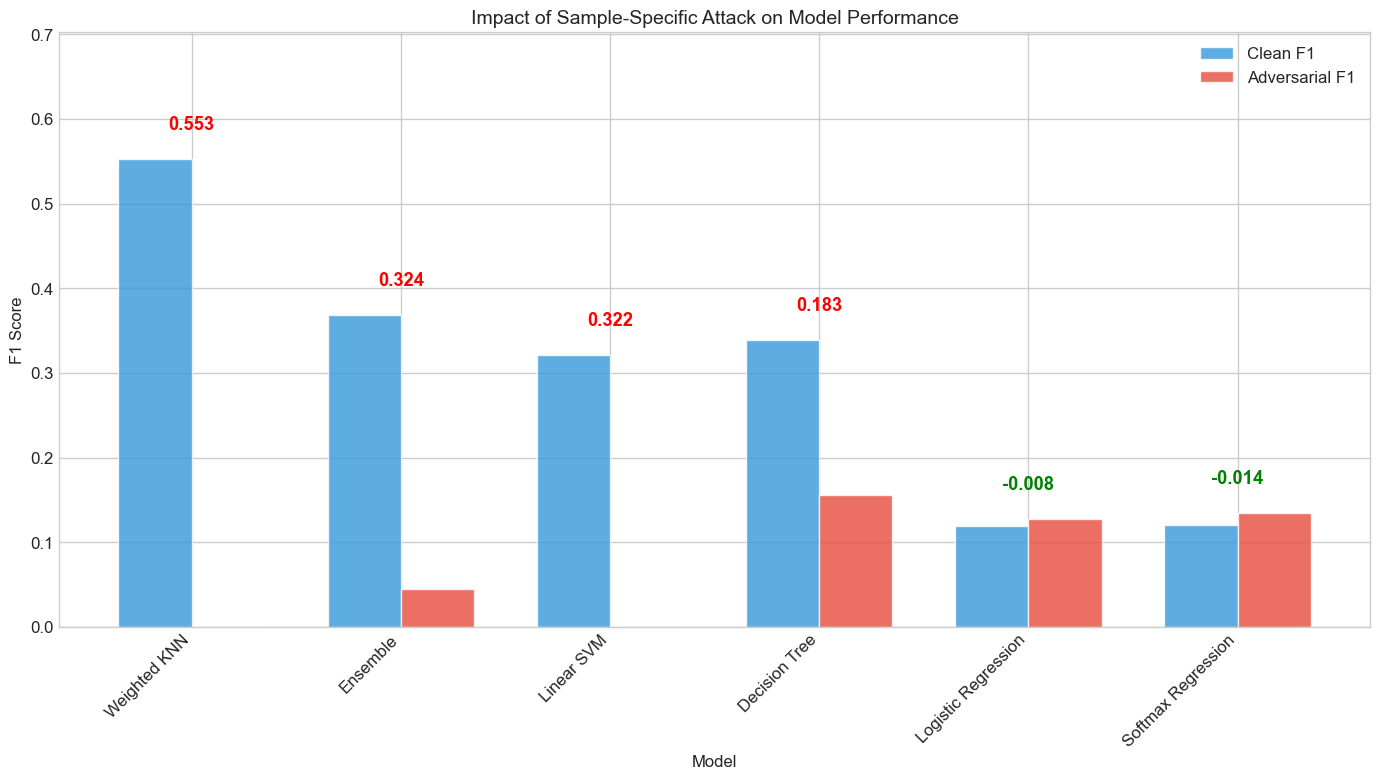

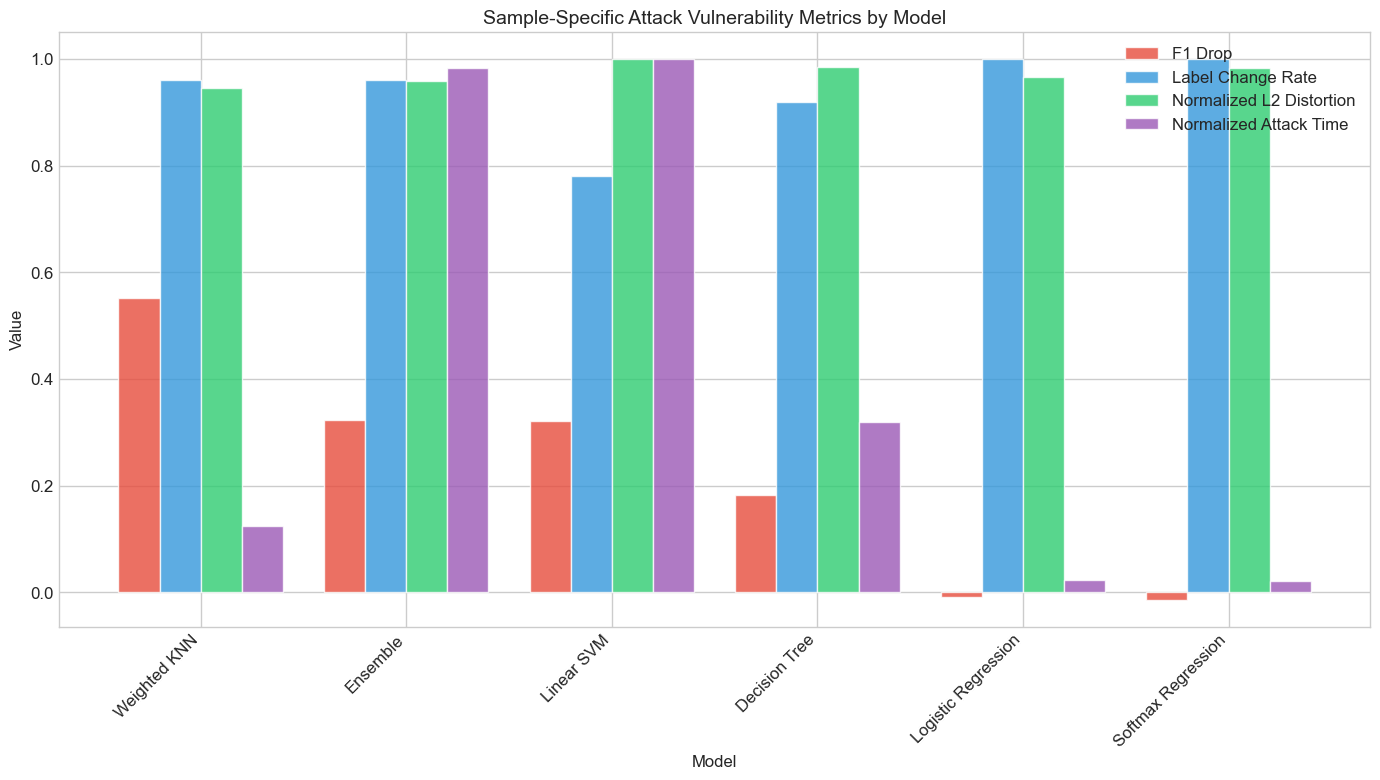

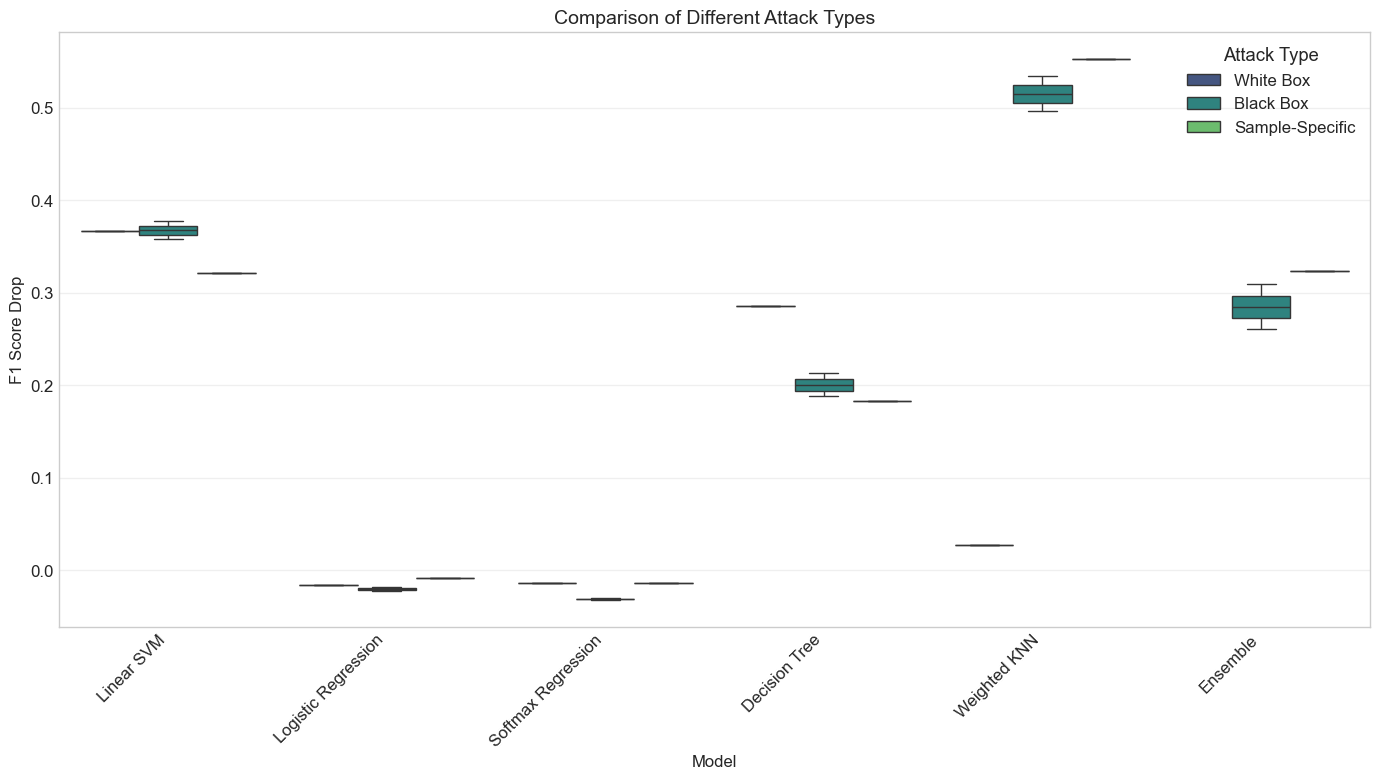

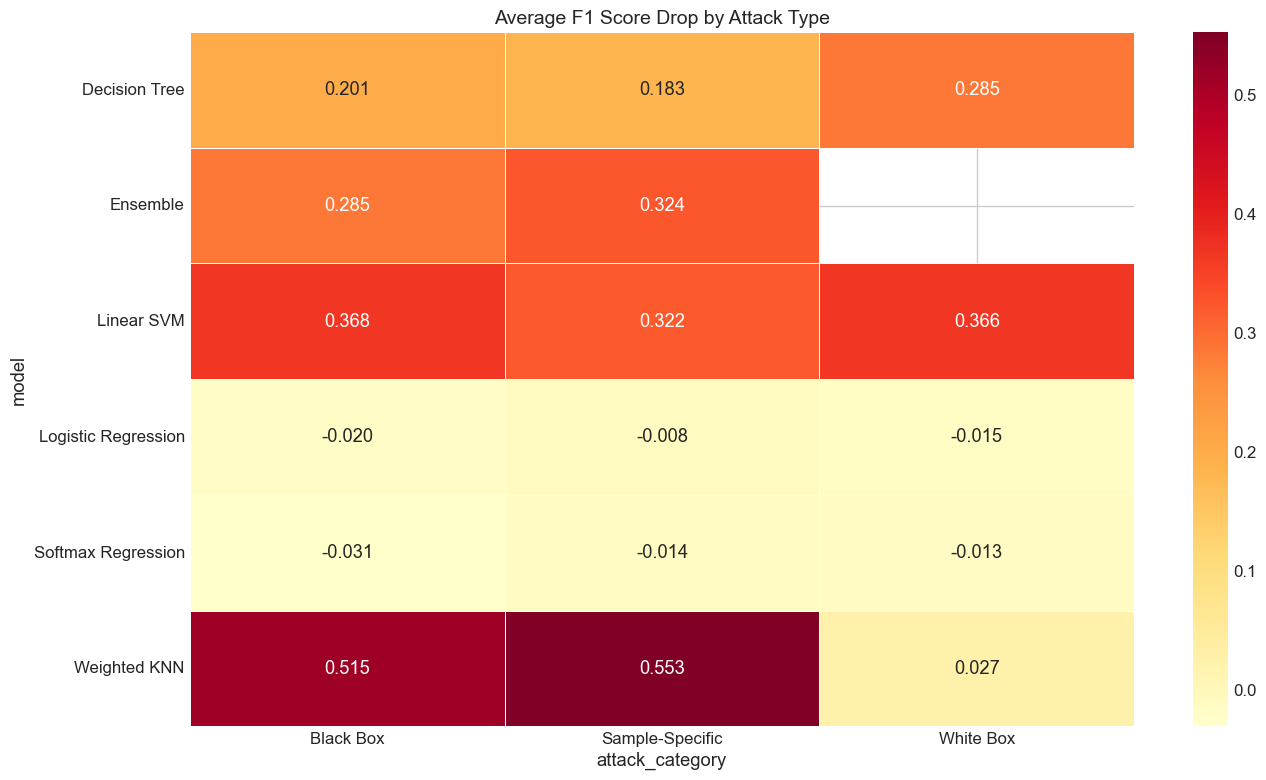

In [72]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# 1. Performance Comparison (Clean vs Adversarial)
plt.figure(figsize=(14, 8))

# Models and their F1 scores
models = specific_df['model'].values
x = np.arange(len(models))
bar_width = 0.35

# Sort by F1 drop for better visualization
sorted_indices = specific_df['f1_drop'].argsort()[::-1]
models = specific_df['model'].values[sorted_indices]
clean_f1 = specific_df['clean_f1'].values[sorted_indices]
adv_f1 = specific_df['adv_f1'].values[sorted_indices]
f1_drops = specific_df['f1_drop'].values[sorted_indices]

# Create bars
plt.bar(x - bar_width/2, clean_f1, bar_width, label='Clean F1', color='#3498db', alpha=0.8)
plt.bar(x + bar_width/2, adv_f1, bar_width, label='Adversarial F1', color='#e74c3c', alpha=0.8)

# Add F1 drop annotations
for i, drop in enumerate(f1_drops):
    color = 'red' if drop > 0 else 'green'
    plt.annotate(f'{drop:.3f}', 
                 xy=(i, max(clean_f1[i], adv_f1[i]) + 0.03),
                 ha='center', va='bottom',
                 color=color, fontweight='bold')

# Customize plot
plt.xlabel('Model', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('Impact of Sample-Specific Attack on Model Performance', fontsize=14)
plt.xticks(x, models, rotation=45, ha='right')
plt.legend(loc='upper right')
plt.ylim(0, max(max(clean_f1), max(adv_f1)) + 0.15)
plt.tight_layout()
plt.savefig('sample_specific_f1_comparison.png', dpi=300)
plt.show()

# 2. Model Vulnerability Metrics
plt.figure(figsize=(14, 8))

# Prepare data
models = specific_df['model'].values[sorted_indices]
label_changes = specific_df['label_change_rate'].values[sorted_indices]
flip_rates = specific_df['prediction_flip_rate'].values[sorted_indices]
l2_distortions = specific_df['l2_distortion'].values[sorted_indices]
attack_times = specific_df['attack_time'].values[sorted_indices]

# Normalize metrics for better comparison
max_l2 = np.max(l2_distortions)
max_time = np.max(attack_times)
norm_l2 = l2_distortions / max_l2 if max_l2 > 0 else l2_distortions
norm_time = attack_times / max_time if max_time > 0 else attack_times

# Set width of bars
barWidth = 0.2
r1 = np.arange(len(models))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

# Create bars
plt.bar(r1, f1_drops, width=barWidth, label='F1 Drop', color='#e74c3c', alpha=0.8)
plt.bar(r2, label_changes, width=barWidth, label='Label Change Rate', color='#3498db', alpha=0.8)
plt.bar(r3, norm_l2, width=barWidth, label='Normalized L2 Distortion', color='#2ecc71', alpha=0.8)
plt.bar(r4, norm_time, width=barWidth, label='Normalized Attack Time', color='#9b59b6', alpha=0.8)

# Add labels and customize plot
plt.xlabel('Model', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.title('Sample-Specific Attack Vulnerability Metrics by Model', fontsize=14)
plt.xticks([r + barWidth*1.5 for r in range(len(models))], models, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.savefig('sample_specific_vulnerability_metrics.png', dpi=300)
plt.show()

# 3. Compare sample-specific attack to previous attacks
if 'results_df' in globals() and 'blackbox_df' in globals():
    plt.figure(figsize=(14, 8))
    
    # Combine all attack results - add attack category column
    if 'results_df' in globals():
        whitebox_df = results_df.copy()
        whitebox_df['attack_category'] = 'White Box'
    
    if 'blackbox_df' in globals():
        blackbox_copy = blackbox_df.copy()
        blackbox_copy['attack_category'] = 'Black Box'
    
    specific_copy = specific_df.copy()
    specific_copy['attack_category'] = 'Sample-Specific'
    
    # Combine dataframes
    combined_df = pd.concat([whitebox_df, blackbox_copy, specific_copy])
    
    # Create a grouped boxplot for F1 drop
    sns.boxplot(x='model', y='f1_drop', hue='attack_category', data=combined_df, palette='viridis')
    
    plt.title('Comparison of Different Attack Types', fontsize=14)
    plt.xlabel('Model', fontsize=12)
    plt.ylabel('F1 Score Drop', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Attack Type')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('attack_type_comparison.png', dpi=300)
    plt.show()
    
    # Create a heatmap comparing attack types across models
    plt.figure(figsize=(14, 8))
    
    # Calculate average F1 drop by model and attack category
    heatmap_data = combined_df.groupby(['model', 'attack_category'])['f1_drop'].mean().unstack()
    
    # Create heatmap
    sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlOrRd', linewidths=0.5)
    plt.title('Average F1 Score Drop by Attack Type', fontsize=14)
    plt.tight_layout()
    plt.savefig('attack_type_heatmap.png', dpi=300)
    plt.show()

### Sample Agnostic Perturbation

In [73]:
def compute_fooling_rate(model, X, y, perturbation):
    """
    Compute the fooling rate of a perturbation on a set of samples.
    
    Parameters:
    -----------
    model : trained model
        Target model to evaluate
    X : array-like
        Set of samples to evaluate
    y : array-like
        True labels
    perturbation : array-like
        Perturbation to apply to each sample
        
    Returns:
    --------
    fooling_rate : float
        Rate of successful misclassification
    """
    # Apply perturbation
    X_perturbed = np.clip(X + perturbation, 0, 1)
    
    # Get predictions
    y_pred_clean = model.predict(X)
    y_pred_pert = model.predict(X_perturbed)
    
    # Check if predictions changed
    changed = [not np.array_equal(y_pred_clean[i], y_pred_pert[i]) for i in range(len(X))]
    fooling_rate = np.mean(changed)
    
    return fooling_rate

def create_universal_perturbation(model, X_train, y_train, epsilon=0.2, max_iter=10, 
                                delta=0.2, num_samples=100, batch_size=10):
    """
    Create a sample-agnostic (universal) adversarial perturbation.
    
    Parameters:
    -----------
    model : trained model
        Target model to attack
    X_train : array-like
        Set of samples to craft the universal perturbation (subset of training data)
    y_train : array-like
        True labels corresponding to X_train samples
    epsilon : float
        Maximum magnitude of the perturbation
    max_iter : int 
        Number of iterations to perform
    delta : float
        Desired fooling rate (0.0 to 1.0)
    num_samples : int
        Number of samples to use for crafting the perturbation
    batch_size : int
        Batch size for processing samples
        
    Returns:
    --------
    v : array-like
        Universal adversarial perturbation
    fooling_rate : float
        Rate of successful misclassification
    """
    # Subset of training data to craft the perturbation
    if num_samples < len(X_train):
        indices = np.random.choice(len(X_train), num_samples, replace=False)
        X_subset = X_train[indices]
        y_subset = y_train[indices]
    else:
        X_subset = X_train
        y_subset = y_train
    
    # Initialize universal perturbation vector
    v = np.zeros(X_train[0].shape)
    
    # Iteratively build the universal perturbation
    for iteration in range(max_iter):
        print(f"Universal perturbation - Iteration {iteration+1}/{max_iter}")
        
        # Process samples in batches for efficiency
        num_batches = int(np.ceil(len(X_subset) / batch_size))
        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, len(X_subset))
            
            X_batch = X_subset[start_idx:end_idx]
            y_batch = y_subset[start_idx:end_idx]
            
            # Compute current predictions with perturbation
            X_perturbed = np.clip(X_batch + v, 0, 1)
            y_pred = model.predict(X_perturbed)
            
            # For each sample in batch that is correctly classified despite perturbation
            for i in range(len(X_batch)):
                # If prediction still matches true labels, update perturbation
                if np.sum(y_pred[i] != y_batch[i]) < 1:  # If perturbation isn't sufficiently fooling the model
                    # Find minimal perturbation to change this sample's prediction
                    sample_perturbation = np.zeros_like(v)
                    
                    # Since we can't use gradients directly in sklearn, use random search
                    best_disagreement = 0
                    for _ in range(10):  # Try several random directions
                        # Random perturbation direction
                        direction = np.random.normal(0, 1, size=v.shape)
                        direction = direction / np.linalg.norm(direction)
                        
                        # Try different magnitudes
                        for magnitude in [0.1, 0.2, 0.3, 0.4, 0.5]:
                            test_pert = direction * magnitude * epsilon
                            test_x = np.clip(X_batch[i] + v + test_pert, 0, 1)
                            
                            test_pred = model.predict(test_x.reshape(1, -1))[0]
                            disagreement = np.sum(test_pred != y_batch[i])
                            
                            if disagreement > best_disagreement:
                                best_disagreement = disagreement
                                sample_perturbation = test_pert
                    
                    # Update universal perturbation
                    v = v + sample_perturbation
                    
                    # Project perturbation onto epsilon-ball
                    norm = np.linalg.norm(v)
                    if norm > epsilon:
                        v = v * epsilon / norm
        
        # Compute fooling rate
        fooling_rate = compute_fooling_rate(model, X_subset, y_subset, v)
        print(f"  Current fooling rate: {fooling_rate:.4f}")
        
        # If desired fooling rate is achieved, break
        if fooling_rate >= delta:
            print(f"Desired fooling rate {delta} achieved! Breaking.")
            break
    
    # Final evaluation of the universal perturbation
    final_fooling_rate = compute_fooling_rate(model, X_subset, y_subset, v)
    print(f"Final universal perturbation created with fooling rate: {final_fooling_rate:.4f}")
    
    return v, final_fooling_rate

In [74]:
def apply_universal_perturbation(X, perturbation):
    """
    Apply a universal perturbation to samples.
    
    Parameters:
    -----------
    X : array-like
        Samples to perturb
    perturbation : array-like
        Universal perturbation to apply
        
    Returns:
    --------
    X_adv : array-like
        Perturbed samples
    """
    X_adv = np.clip(X + perturbation, 0, 1)
    return X_adv

In [75]:
if 'ensemble_model' not in globals():
    models_for_ensemble = {name: model for name, model in trained_models.items() 
                          if name != 'Weighted KNN'}
    ensemble_model = EnsembleModel(models_for_ensemble)
    
    # Add the ensemble to our models
    all_models = trained_models.copy()
    all_models['Ensemble'] = ensemble_model

# Define attack parameters
sample_size_crafting = 100  # Samples to use for creating the universal perturbation
sample_size_eval = 50       # Samples to use for evaluation
epsilons = [0.2]            # Perturbation magnitude
attack_type = 'universal'

# Create results storage
universal_results = []

# Run attacks on all models
print("\n" + "="*70)
print("RUNNING SAMPLE AGNOSTIC (UNIVERSAL) ADVERSARIAL ATTACKS")
print("="*70)

for model_name, model in all_models.items():
    print(f"\n{'='*50}")
    print(f"Attacking {model_name}...")
    print(f"{'='*50}")
    
    # Select appropriate features based on model
    if model_name != 'Weighted KNN':
        train_features = X_test_scaled[:500]  # Using part of test set for crafting (you can use validation set instead)
        test_features = X_test_scaled[500:500+sample_size_eval]  # Different part for evaluation
        train_labels = test_labels[:500]
        test_labels_subset = test_labels[500:500+sample_size_eval]
    else:
        train_features = X_test_reduced[:500]
        test_features = X_test_reduced[500:500+sample_size_eval]
        train_labels = test_labels[:500]
        test_labels_subset = test_labels[500:500+sample_size_eval]
    
    # Run attack with different epsilon values
    for epsilon in epsilons:
        print(f"\nCreating universal perturbation with ε={epsilon} for {model_name}...")
        
        try:
            # Generate universal perturbation
            start_time = time.time()
            
            # Create the universal perturbation
            universal_pert, fooling_rate = create_universal_perturbation(
                model, train_features, train_labels,
                epsilon=epsilon, 
                max_iter=5,  # Reduced iterations for runtime
                delta=0.2,   # Target fooling rate of 20%
                num_samples=min(sample_size_crafting, len(train_features)),
                batch_size=10
            )
            
            # Apply the perturbation to evaluation samples
            X_adv = apply_universal_perturbation(test_features, universal_pert)
            
            attack_time = time.time() - start_time
            
            # Evaluate attack
            results = evaluate_adversarial_examples(
                model, test_features, X_adv, test_labels_subset,
                model_name, f"{attack_type.upper()}-ε{epsilon}"
            )
            
            # Add specific universal attack metrics
            results['attack_time'] = attack_time
            results['epsilon'] = epsilon
            results['attack_type'] = attack_type
            results['fooling_rate_crafting'] = fooling_rate
            
            # Print results
            print(f"  Universal perturbation created in {attack_time:.2f}s")
            print(f"  Clean F1: {results['clean_f1']:.4f}")
            print(f"  Adversarial F1: {results['adv_f1']:.4f}")
            print(f"  F1 Drop: {results['f1_drop']:.4f}")
            print(f"  Label Change Rate: {results['label_change_rate']:.4f}")
            
            universal_results.append(results)
            
        except Exception as e:
            print(f"  Attack failed: {str(e)}")
            traceback.print_exc()

# Convert results to DataFrame
universal_df = pd.DataFrame(universal_results)

# Save full results to CSV
universal_df.to_csv("universal_attack_results.csv", index=False)

# Create a summary table
summary_columns = ['model', 'attack', 'epsilon', 'clean_f1', 'adv_f1', 'f1_drop', 
                  'label_change_rate', 'prediction_flip_rate', 'l2_distortion', 
                  'fooling_rate_crafting', 'attack_time']
summary_df = universal_df[summary_columns].sort_values(by=['model', 'f1_drop'], 
                                                    ascending=[True, False])

print("\nUniversal Attack Summary:")
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)
print(summary_df)


RUNNING SAMPLE AGNOSTIC (UNIVERSAL) ADVERSARIAL ATTACKS

Attacking Linear SVM...

Creating universal perturbation with ε=0.2 for Linear SVM...
Universal perturbation - Iteration 1/5
  Current fooling rate: 0.7300
Desired fooling rate 0.2 achieved! Breaking.
Final universal perturbation created with fooling rate: 0.7300
  Universal perturbation created in 0.83s
  Clean F1: 0.2904
  Adversarial F1: 0.0000
  F1 Drop: 0.2904
  Label Change Rate: 0.6800

Attacking Logistic Regression...

Creating universal perturbation with ε=0.2 for Logistic Regression...
Universal perturbation - Iteration 1/5
  Current fooling rate: 1.0000
Desired fooling rate 0.2 achieved! Breaking.
Final universal perturbation created with fooling rate: 1.0000
  Universal perturbation created in 1.05s
  Clean F1: 0.1107
  Adversarial F1: 0.1110
  F1 Drop: -0.0004
  Label Change Rate: 1.0000

Attacking Softmax Regression...

Creating universal perturbation with ε=0.2 for Softmax Regression...
Universal perturbation - It

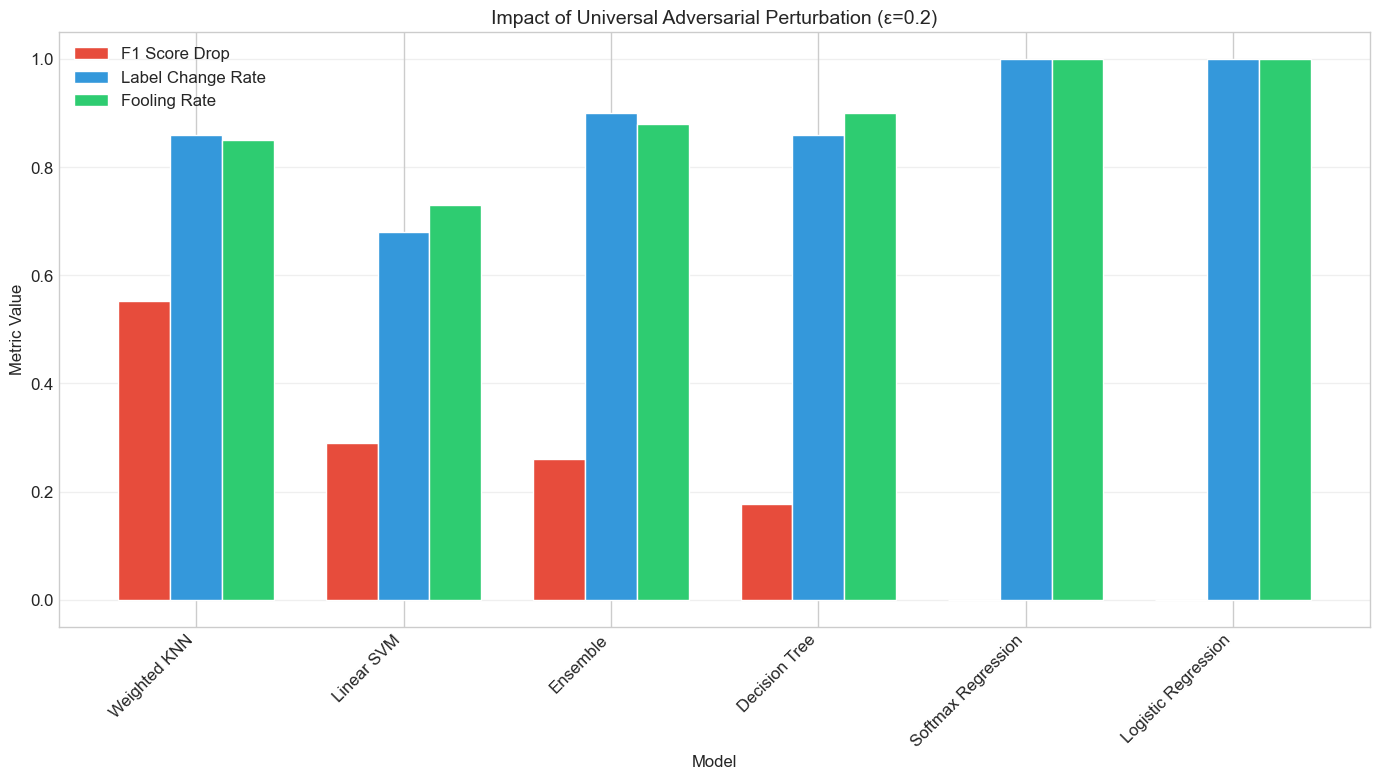

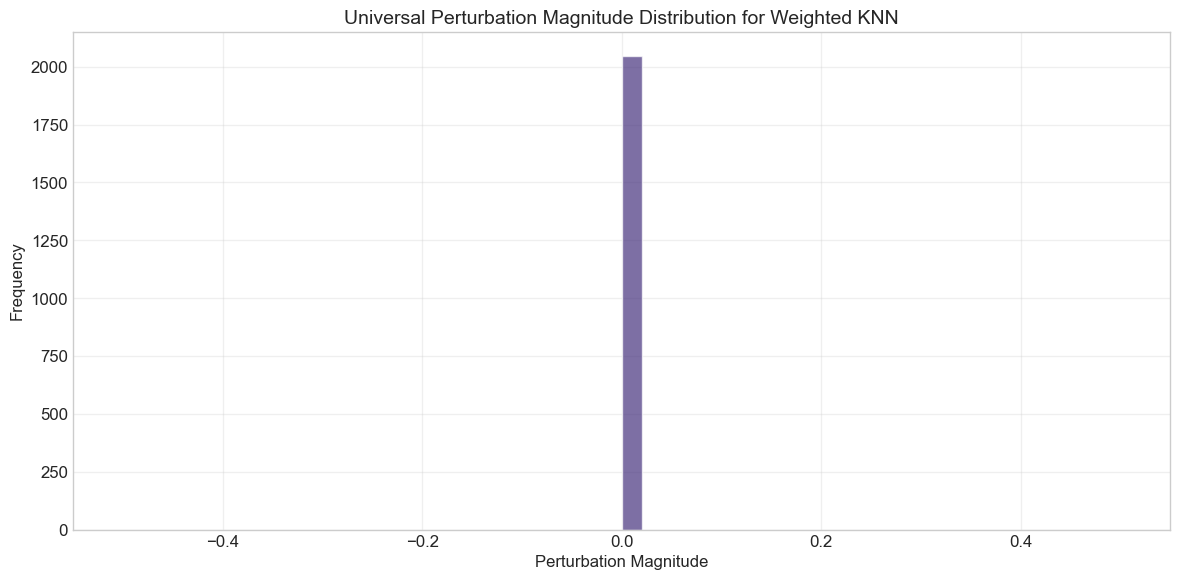

In [77]:
plt.figure(figsize=(14, 8))

# Extract data for plotting
models = universal_df['model'].values
f1_drops = universal_df['f1_drop'].values
label_changes = universal_df['label_change_rate'].values
fooling_rates = universal_df['fooling_rate_crafting'].values

# Sort for better visualization
sort_idx = np.argsort(f1_drops)[::-1]
models = models[sort_idx]
f1_drops = f1_drops[sort_idx]
label_changes = label_changes[sort_idx]
fooling_rates = fooling_rates[sort_idx]

# Create bar width
x = np.arange(len(models))
width = 0.25

# Create grouped bars
plt.bar(x - width, f1_drops, width, label='F1 Score Drop', color='#e74c3c')
plt.bar(x, label_changes, width, label='Label Change Rate', color='#3498db')
plt.bar(x + width, fooling_rates, width, label='Fooling Rate', color='#2ecc71')

# Add labels and customize
plt.xlabel('Model', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.title('Impact of Universal Adversarial Perturbation (ε=0.2)', fontsize=14)
plt.xticks(x, models, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('universal_attack_metrics.png', dpi=300)
plt.show()

# Show the perturbation magnitude by feature
plt.figure(figsize=(12, 6))

# Get one of the universal perturbations (from the first model)
if len(universal_results) > 0:
    # Visualize perturbation distribution
    plt.hist(np.abs(universal_pert).flatten(), bins=50, alpha=0.7)
    plt.xlabel('Perturbation Magnitude', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title(f'Universal Perturbation Magnitude Distribution for {models[0]}', fontsize=14)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('universal_perturbation_distribution.png', dpi=300)
    plt.show()